In [1]:
!pip install visualkeras
from IPython.display import clear_output
clear_output(wait=False)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Nadam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [3]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

# Training batch size
epochs = 64

# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

In [4]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels
# Setting up file paths for training and testing
USER_PATH = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = USER_PATH + "/Training/"
test_dir = USER_PATH + "/Testing/"
save_path = './Optimizer_MRI_E128_BS32_Nadam'
# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [5]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)    

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Image shape: (150, 150, 3)
Epochs: 64
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d has kernel size: (4, 4)
Layer conv2d_1 has kernel size: (4, 4)
Layer conv2d_2 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734095545.489595      83 service.cc:145] XLA service 0x7ae3ac004d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734095545.489653      83 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/178 ━━━━━━━━━━━━━━━━━━━━ 23:36 8s/step - accuracy: 0.2188 - loss: 1.3792

I0000 00:00:1734095549.289766      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 400ms/step - accuracy: 0.5792 - loss: 0.9529 - val_accuracy: 0.6656 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 2/64
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.3866

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.3866 - val_accuracy: 0.5806 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.8028 - loss: 0.5197 - val_accuracy: 0.7625 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.7812 - loss: 0.6629 - val_accuracy: 0.8710 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.8343 - loss: 0.4264 - val_accuracy: 0.7883 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.9062 - loss: 0.2151 - val_accuracy: 0.8065 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.8793 - loss: 0.3108 - val_accuracy: 0.8266 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 8/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.8125 - loss: 0.452

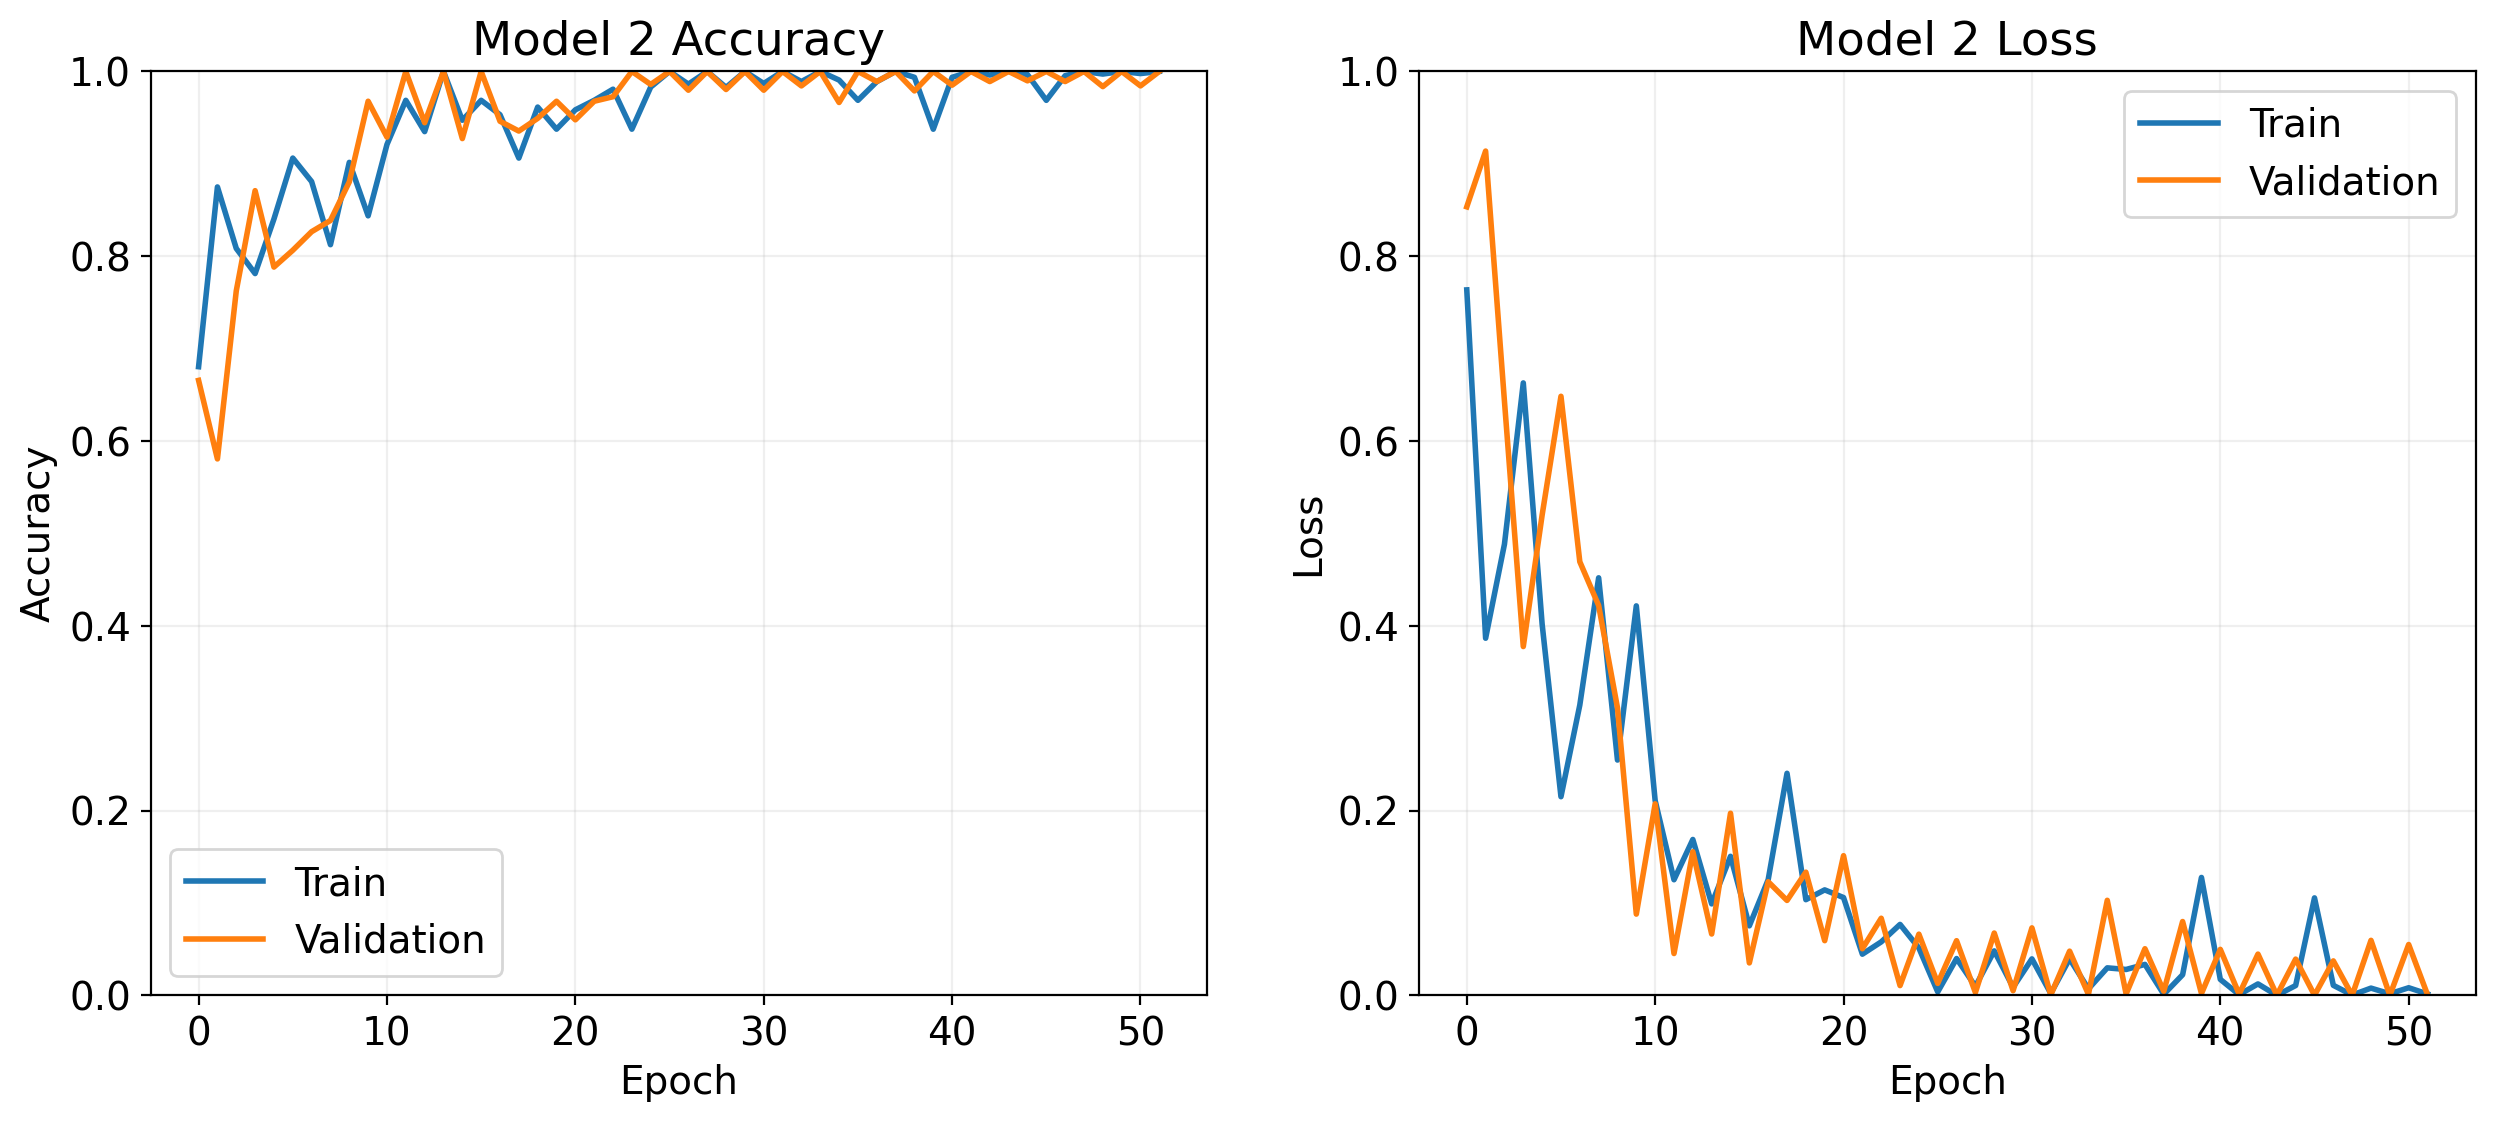

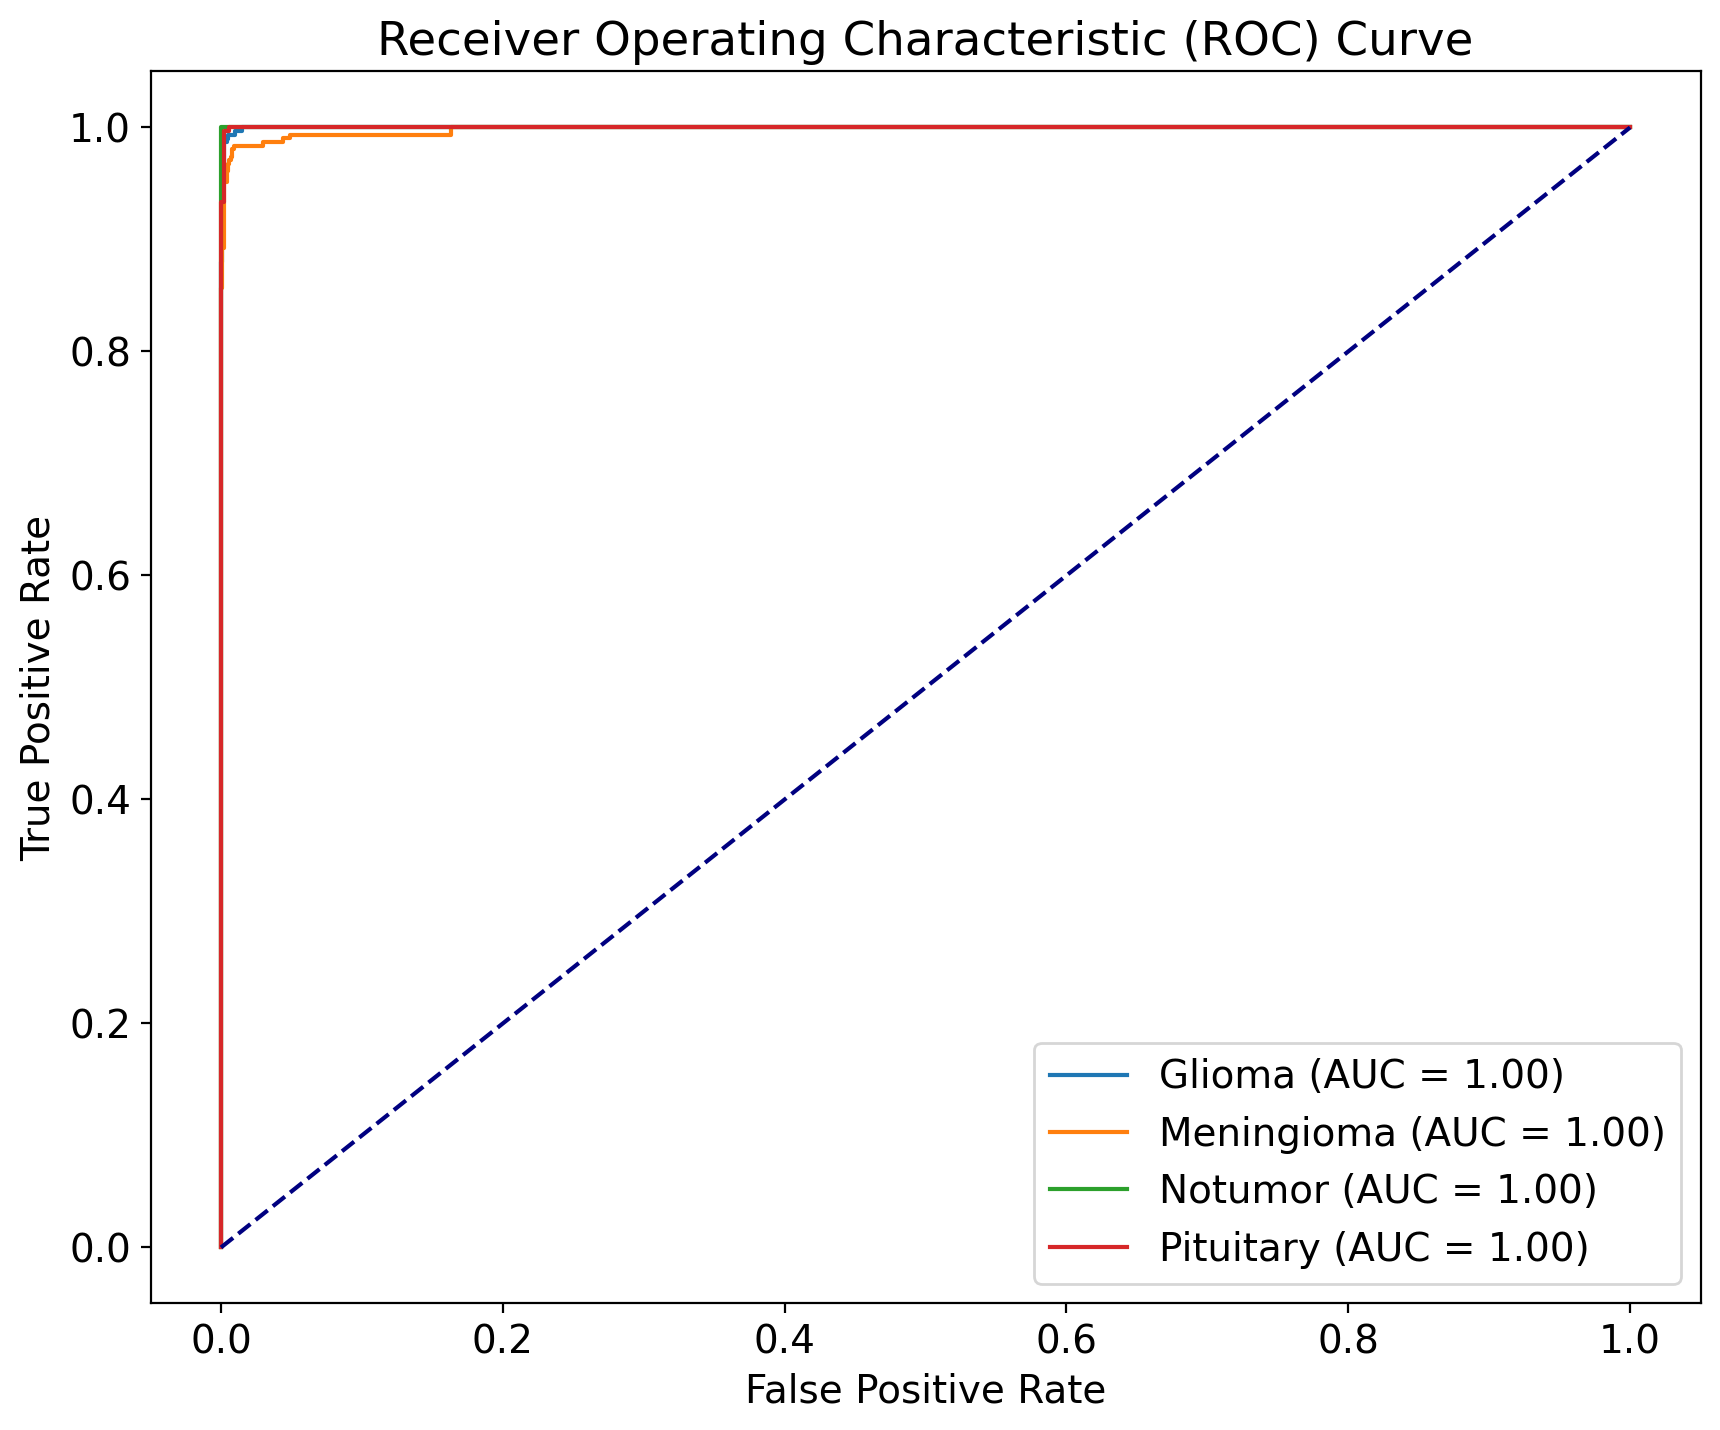

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


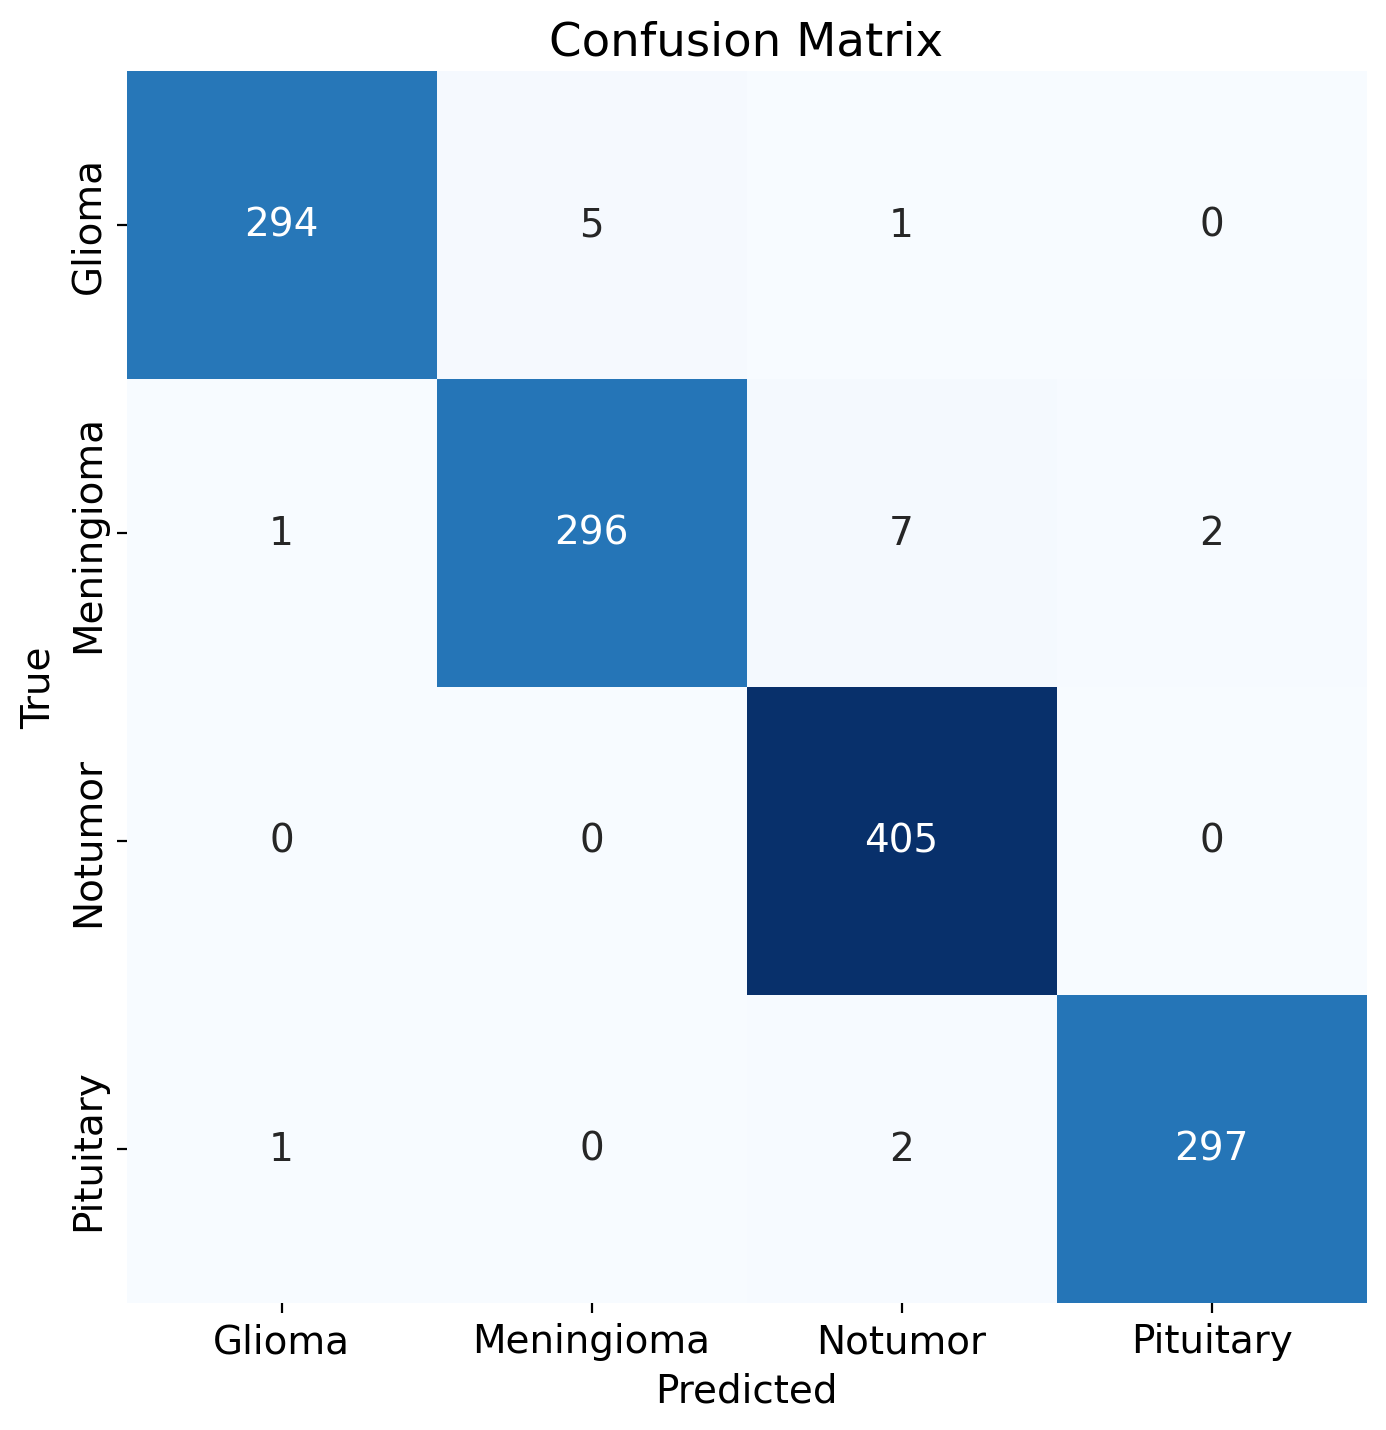

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
Model saved in HDF5 format to /kaggle/working/model.h5


In [6]:

model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

# Get predictions
y_true = test_generator.classes
#y_pred_prob = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size), verbose=1)
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], linewidth=2)
ax[0].plot(history.history['val_accuracy'], linewidth=2)
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)  # Set y-axis range
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'], linewidth=2)
ax[1].plot(history.history['val_loss'], linewidth=2)
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0, 1)  # Set y-axis range
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()
# Classification Report
from sklearn.metrics import classification_report

# Assuming `test_generator` provides true labels and your model outputs predictions
# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

model_save_path = '/kaggle/working/model.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


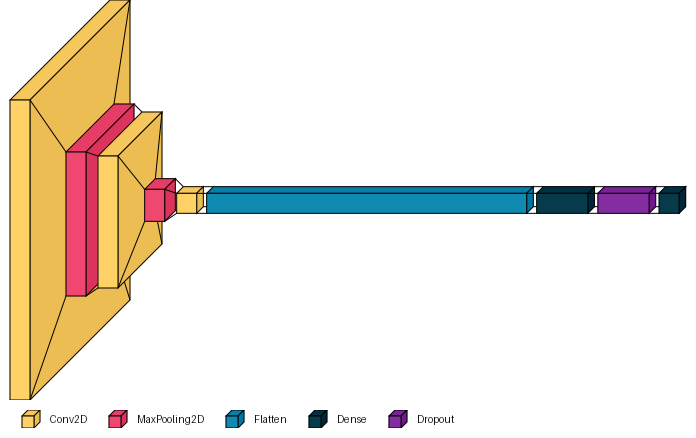

In [7]:
from visualkeras import layered_view
layered_view(model, legend=True, max_xy=300)

# Training batch size = 2

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_3 has kernel size: (4, 4)
Layer conv2d_4 has kernel size: (4, 4)
Layer conv2d_5 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3177 - loss: 1.3137 - val_accuracy: 0.9000 - val_loss: 1.1742 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5065 - loss: 1.1178 - val_accuracy: 0.0125 - val_loss: 1.4357 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5861 - loss: 0.9469 - val_accuracy: 0.2000 - val_loss: 1.7297 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7306 - loss: 0.7237 - val_accuracy: 0.1375 - val_loss: 1.7180 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7410 - loss: 0.6621 - val_accuracy: 0.2250 - val_loss: 2.5442 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7174 - loss: 0.7051
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7174 - loss: 0.7051 - val_a

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.7392 - val_accuracy: 0.8065 - val_loss: 0.5224 - learning_rate: 2.5000e-04
Epoch 18/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8041 - loss: 0.4614 - val_accuracy: 0.8000 - val_loss: 0.4154 - learning_rate: 2.5000e-04
Epoch 19/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8362 - loss: 0.4091 - val_accuracy: 0.8000 - val_loss: 0.7233 - learning_rate: 2.5000e-04
Epoch 20/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7986 - loss: 0.4449
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7987 - loss: 0.4449 - val_accuracy: 0.6250 - val_loss: 0.6974 - learning_rate: 2.5000e-04
Epoch 21/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7938 - loss: 0.4769 - val_accuracy: 0.2875 - val_loss: 1.5480 - learning_rate: 1.2500e-04
Epoch 22/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.85

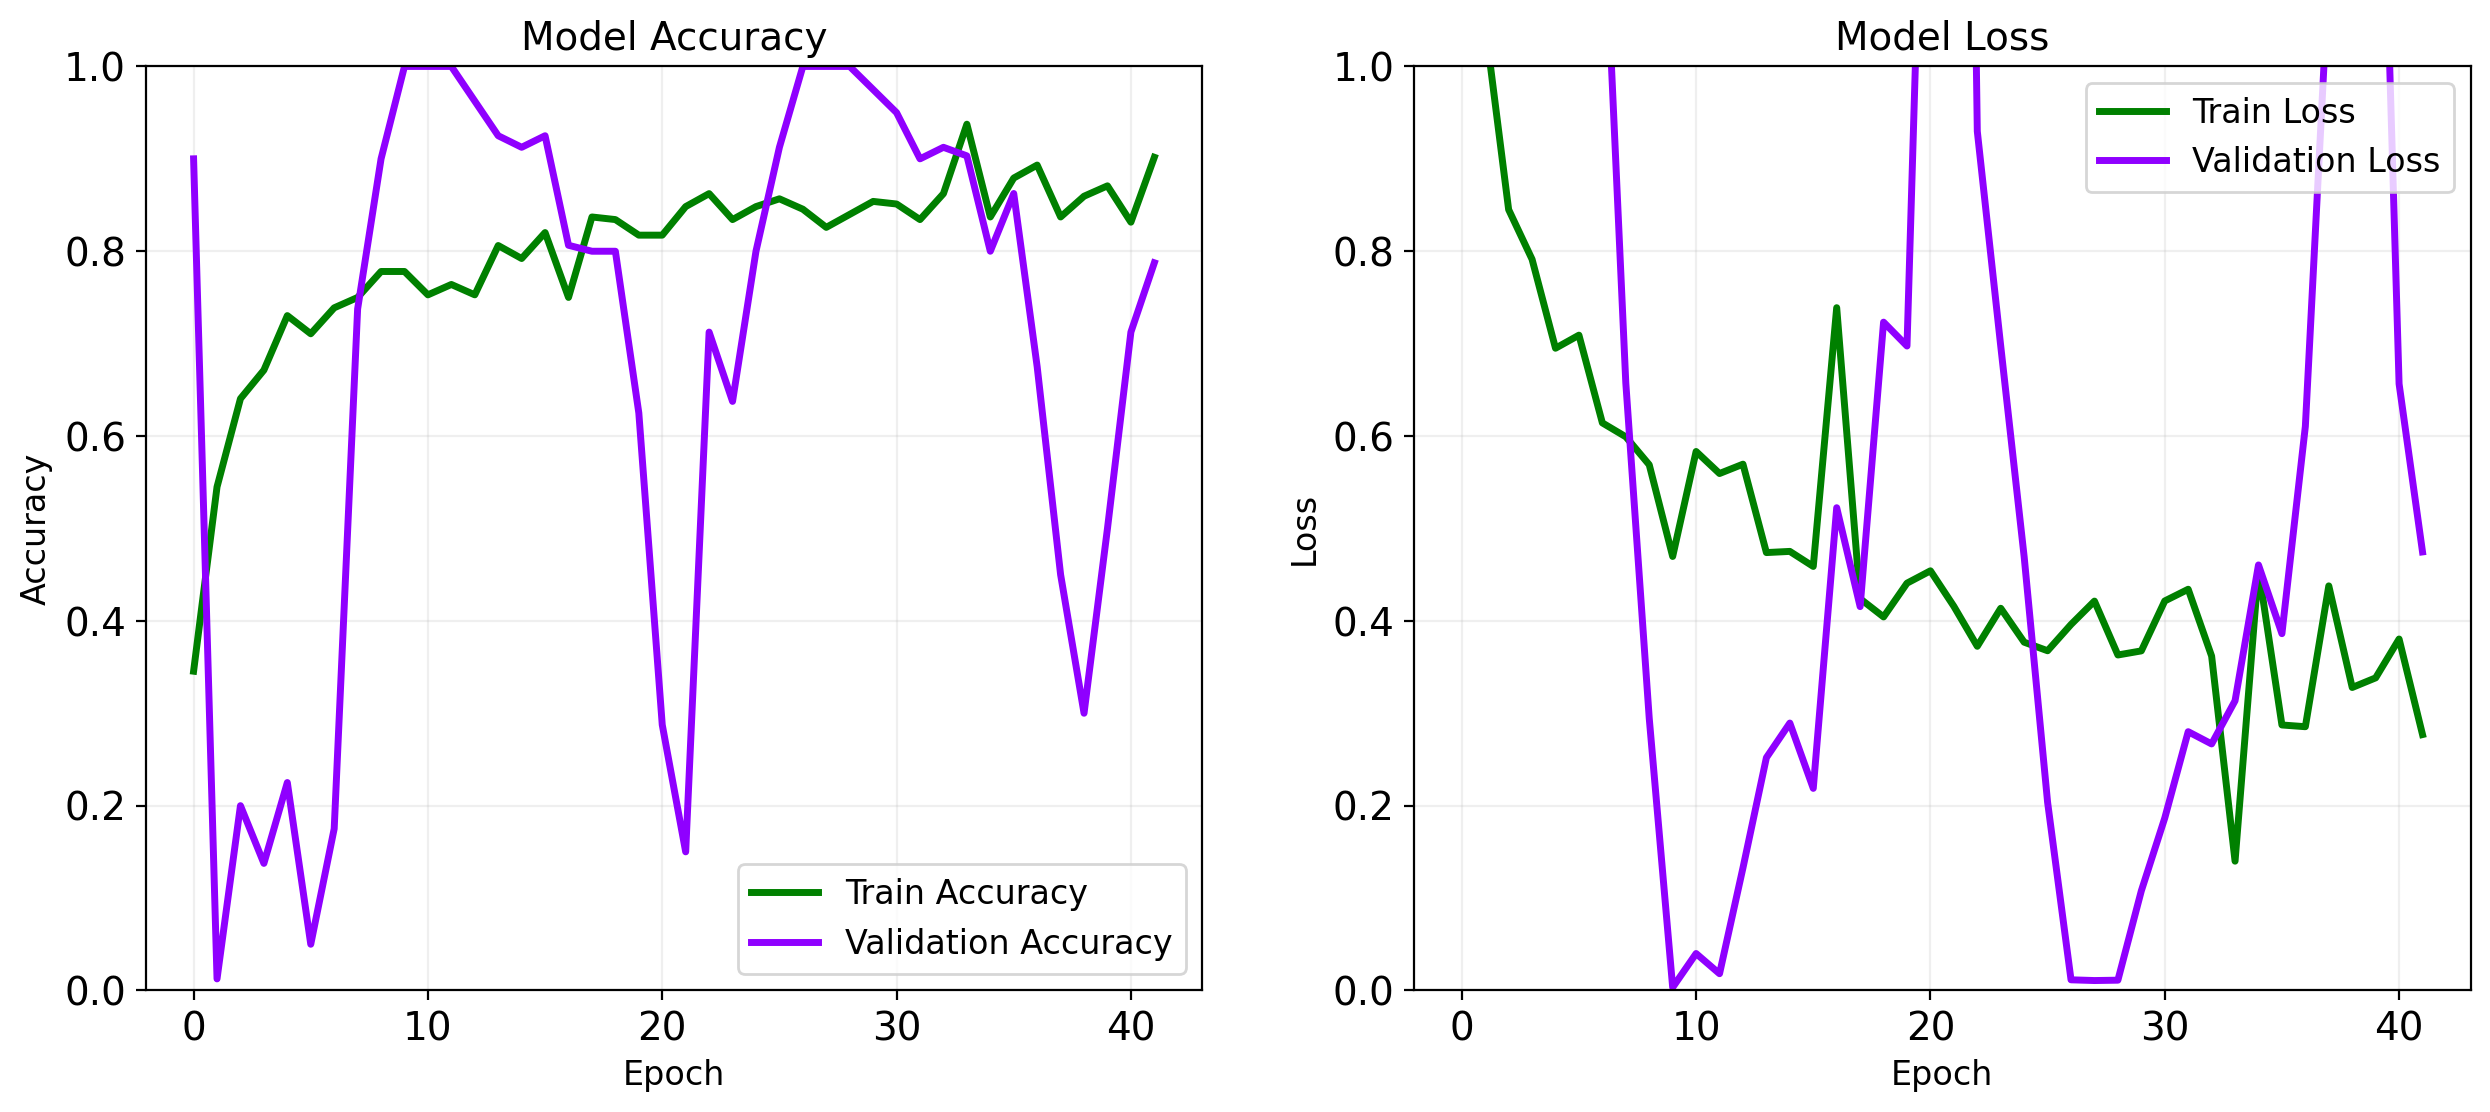

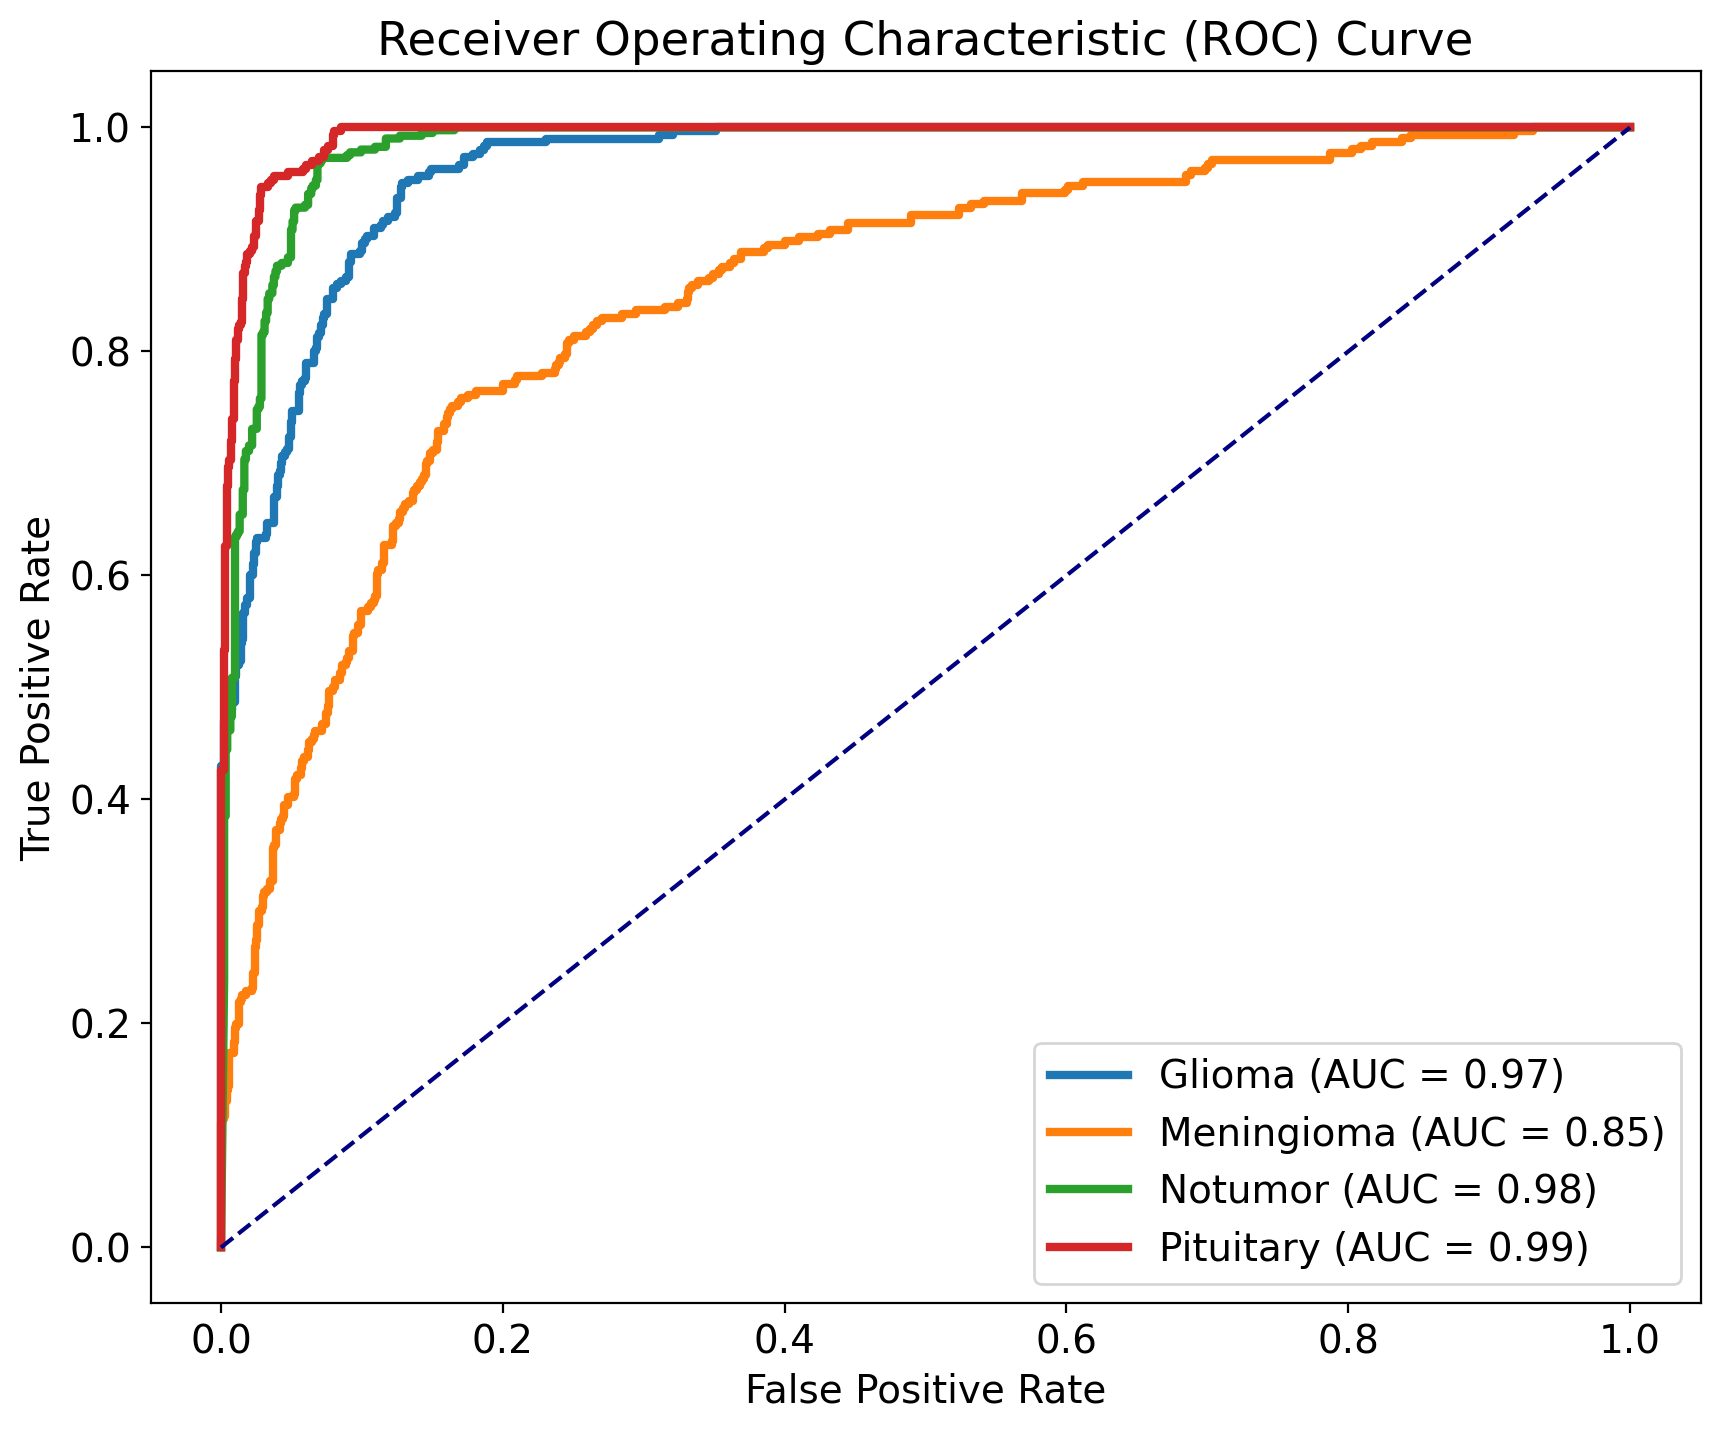

656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


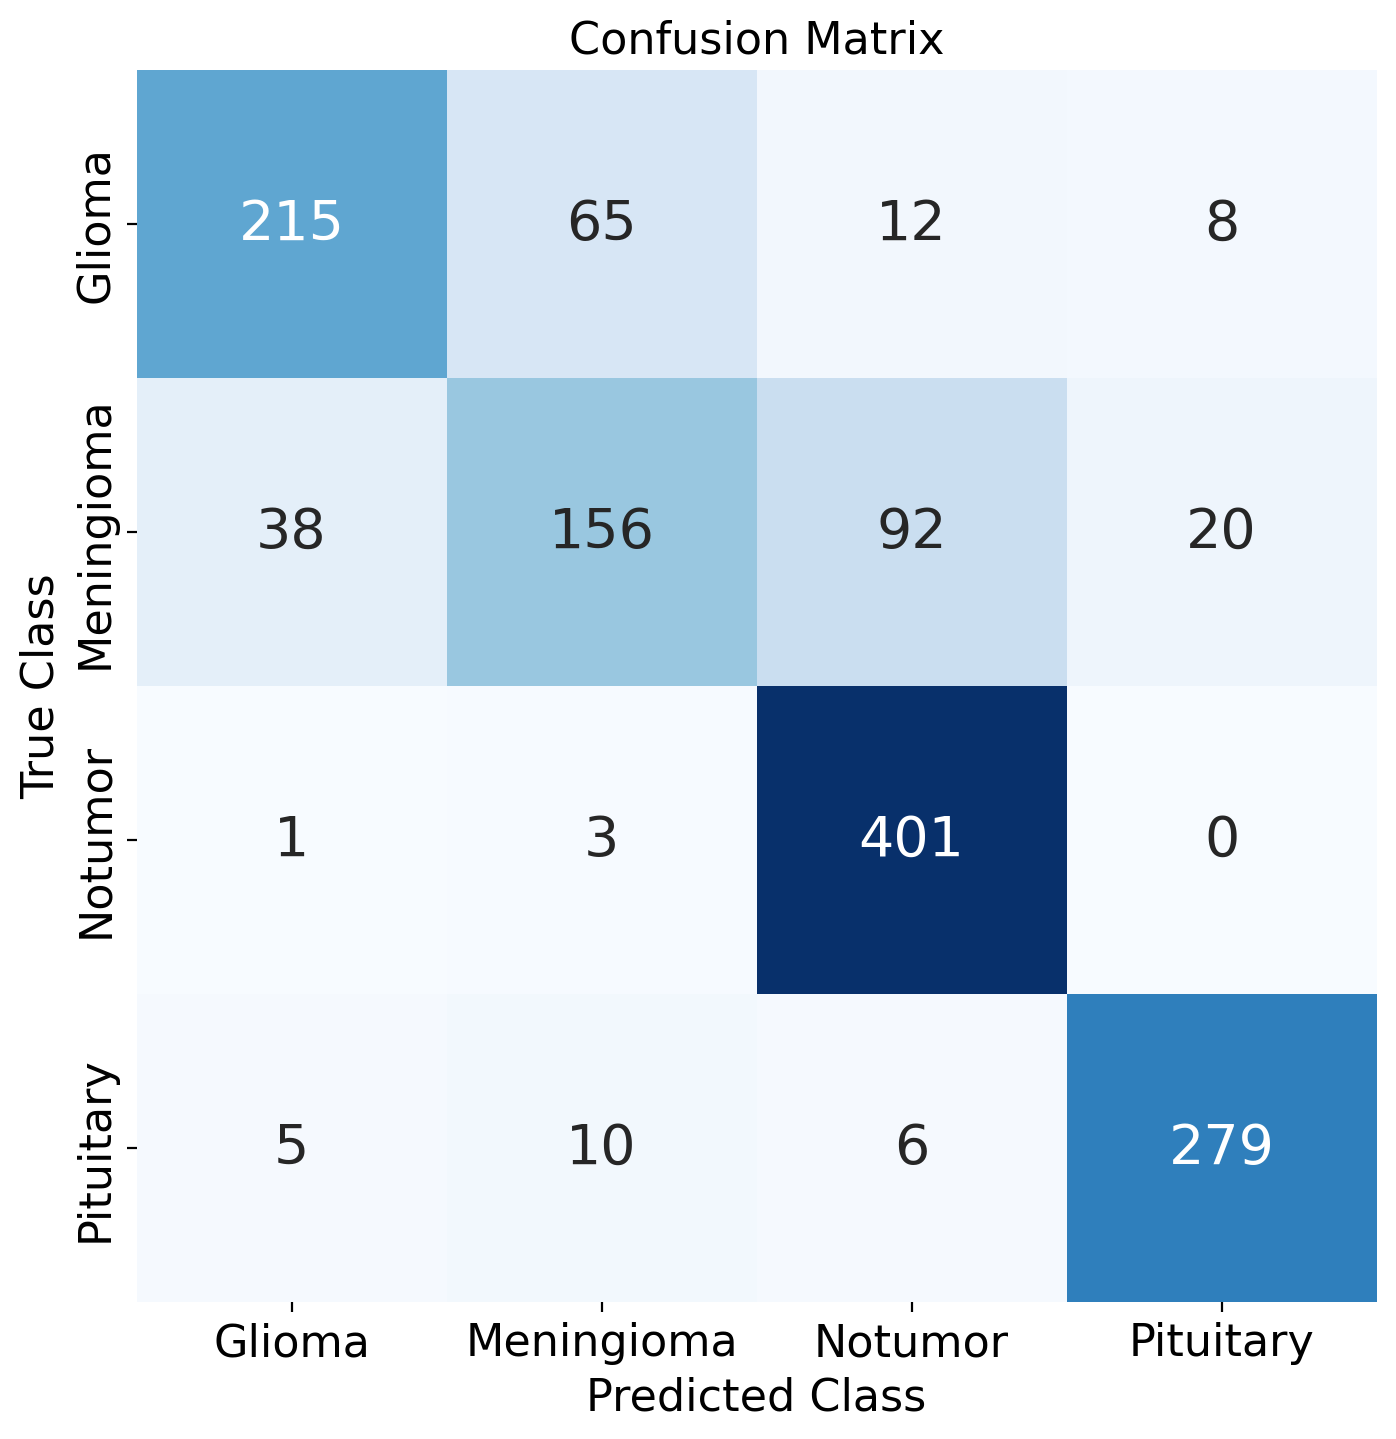

656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.830116  0.716667  0.769231       300
  Meningioma   0.666667  0.509804  0.577778       306
     Notumor   0.784736  0.990123  0.875546       405
   Pituitary   0.908795  0.930000  0.919275       300

    accuracy                       0.801678      1311
   macro avg   0.797578  0.786649  0.785457      1311
weighted avg   0.795951  0.801678  0.791722      1311

Model saved in HDF5 format to /kaggle/working/model_2.h5


In [8]:
# Training batch size
batch_size = 2
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_2.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

# Training batch size = 4

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_6 has kernel size: (4, 4)
Layer conv2d_7 has kernel size: (4, 4)
Layer conv2d_8 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3416 - loss: 1.3298 - val_accuracy: 0.4875 - val_loss: 1.1359 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6480 - loss: 0.8905 - val_accuracy: 0.0250 - val_loss: 2.1936 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7241 - loss: 0.7306 - val_accuracy: 0.0688 - val_loss: 1.6428 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6948 - loss: 0.7118 - val_accuracy: 0.4062 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7344 - loss: 0.5863 - val_accuracy: 0.9688 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7420 - loss: 0.7057 - val_accuracy: 1.0000 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7991 - loss: 0.5267 - val

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8114 - loss: 0.3403 - val_accuracy: 1.0000 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 10/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7762 - loss: 0.5466 - val_accuracy: 0.1688 - val_loss: 1.8244 - learning_rate: 0.0010
Epoch 11/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7899 - loss: 0.5241
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7899 - loss: 0.5240 - val_accuracy: 0.2062 - val_loss: 1.7843 - learning_rate: 0.0010
Epoch 12/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8426 - loss: 0.3801 - val_accuracy: 0.4500 - val_loss: 1.8624 - learning_rate: 5.0000e-04
Epoch 13/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8669 - loss: 0.3541 - val_accuracy: 0.8250 - val_loss: 0.4749 - learning_rate: 5.0000e-04
Epoch 14/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8275 - loss: 0

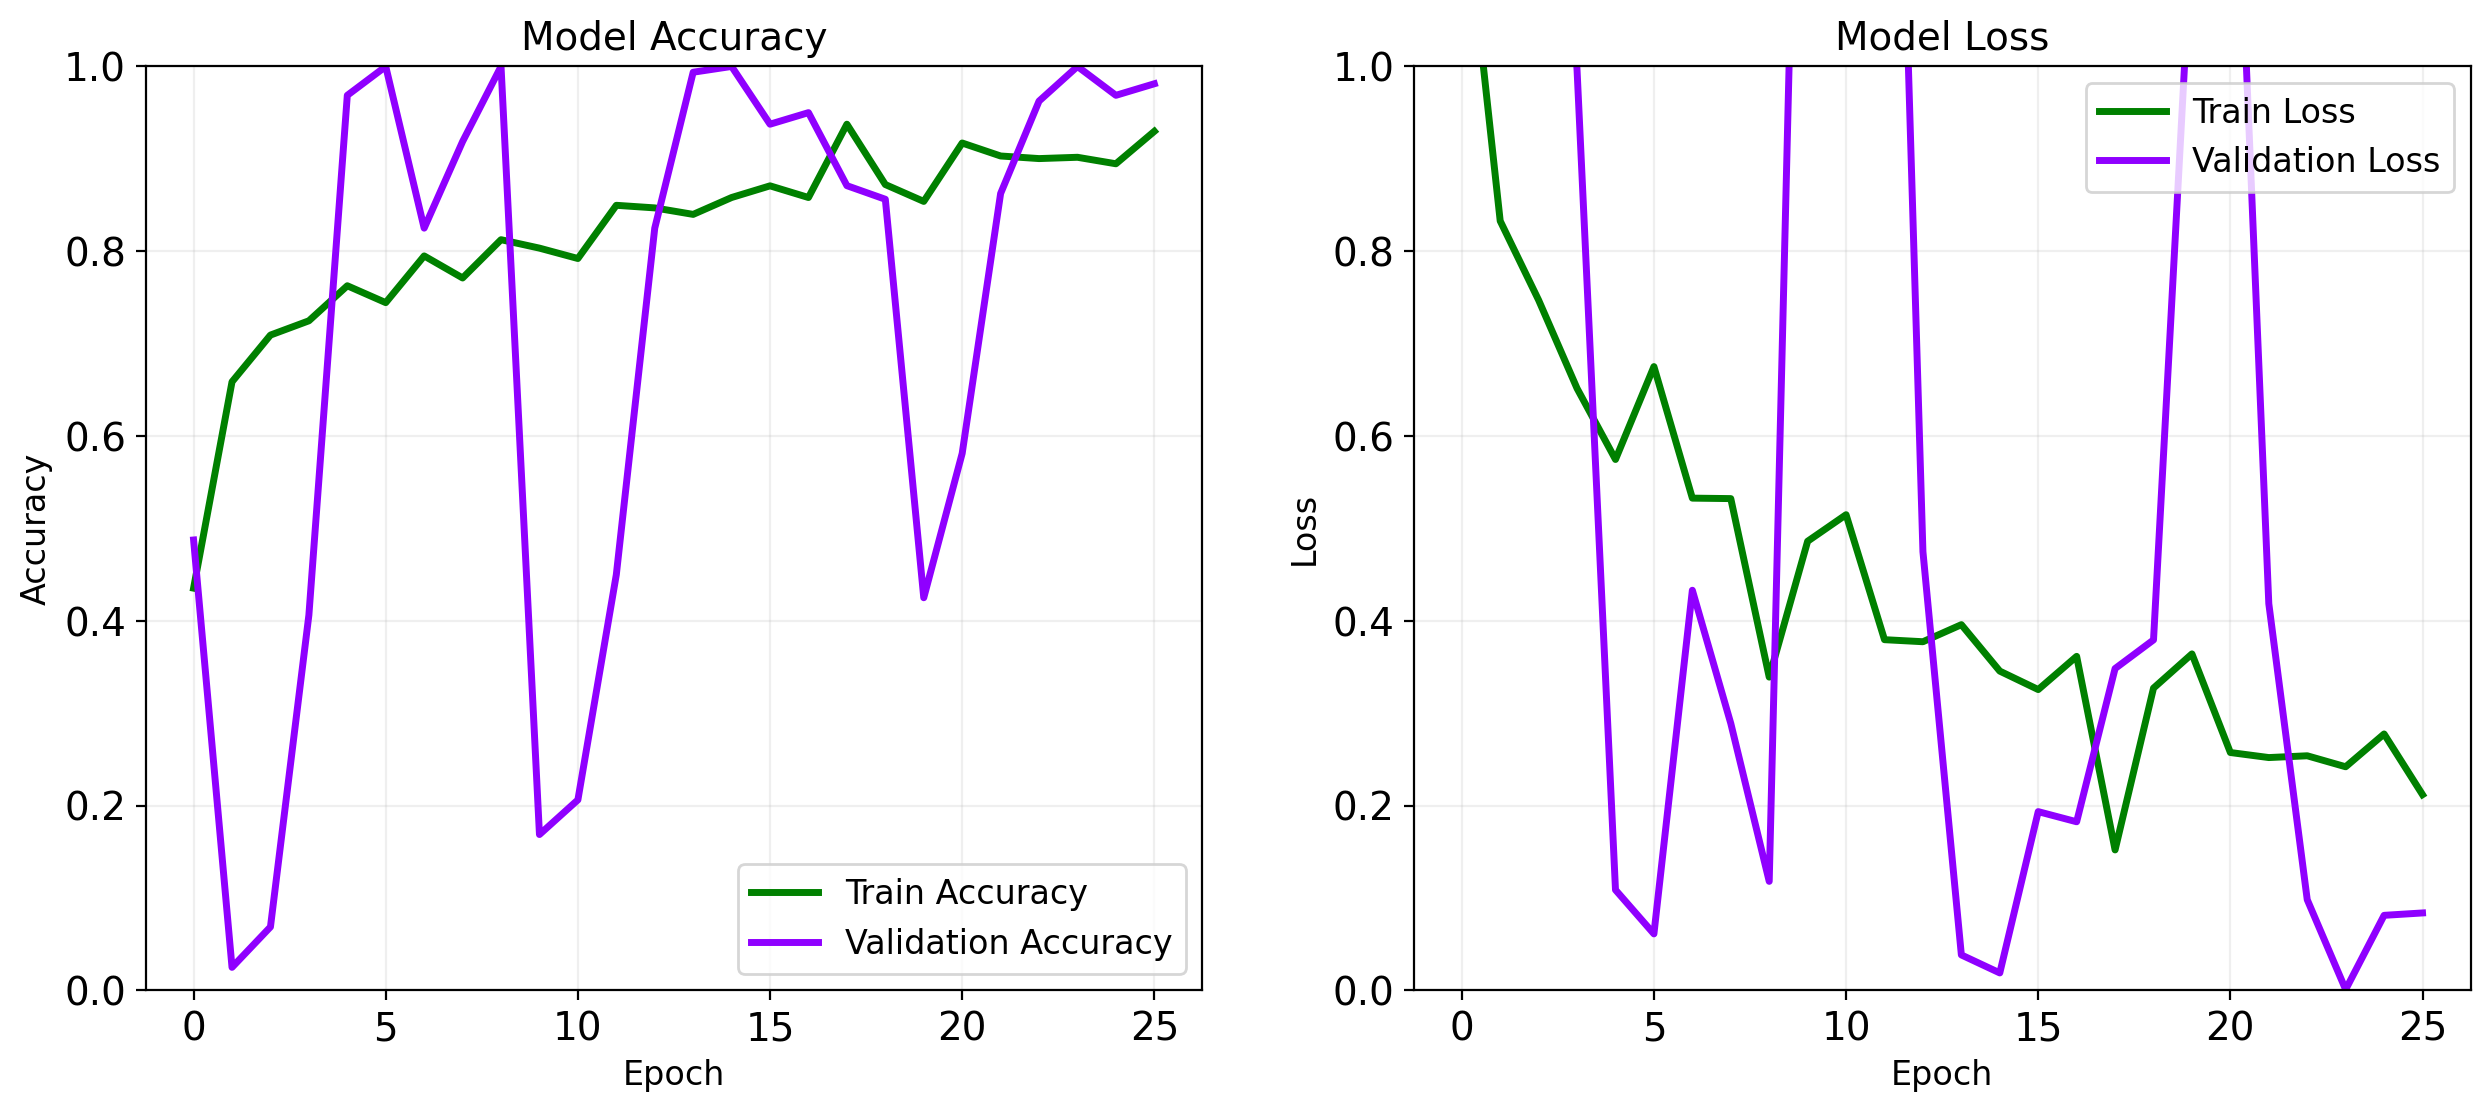

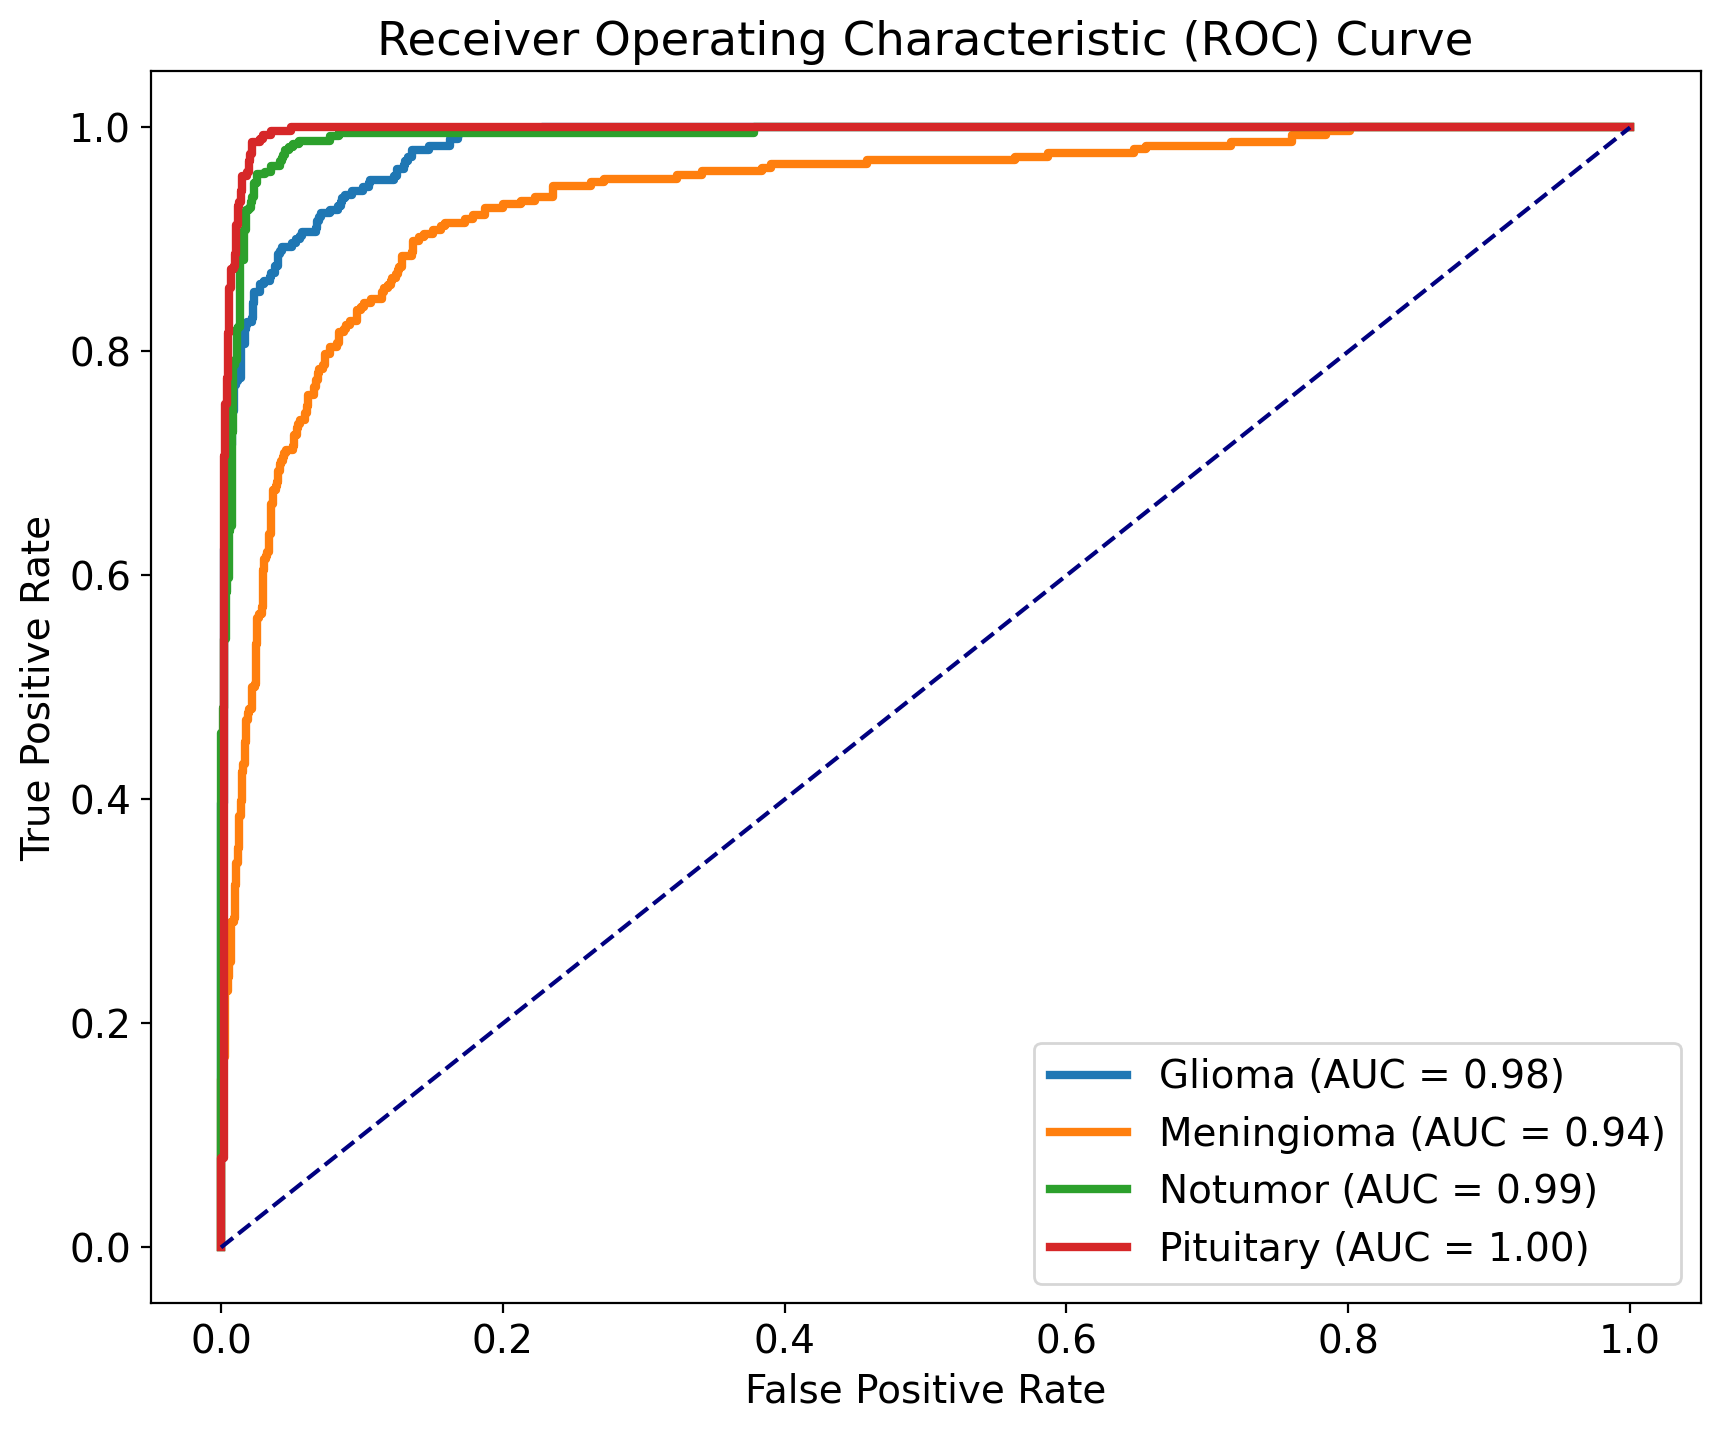

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


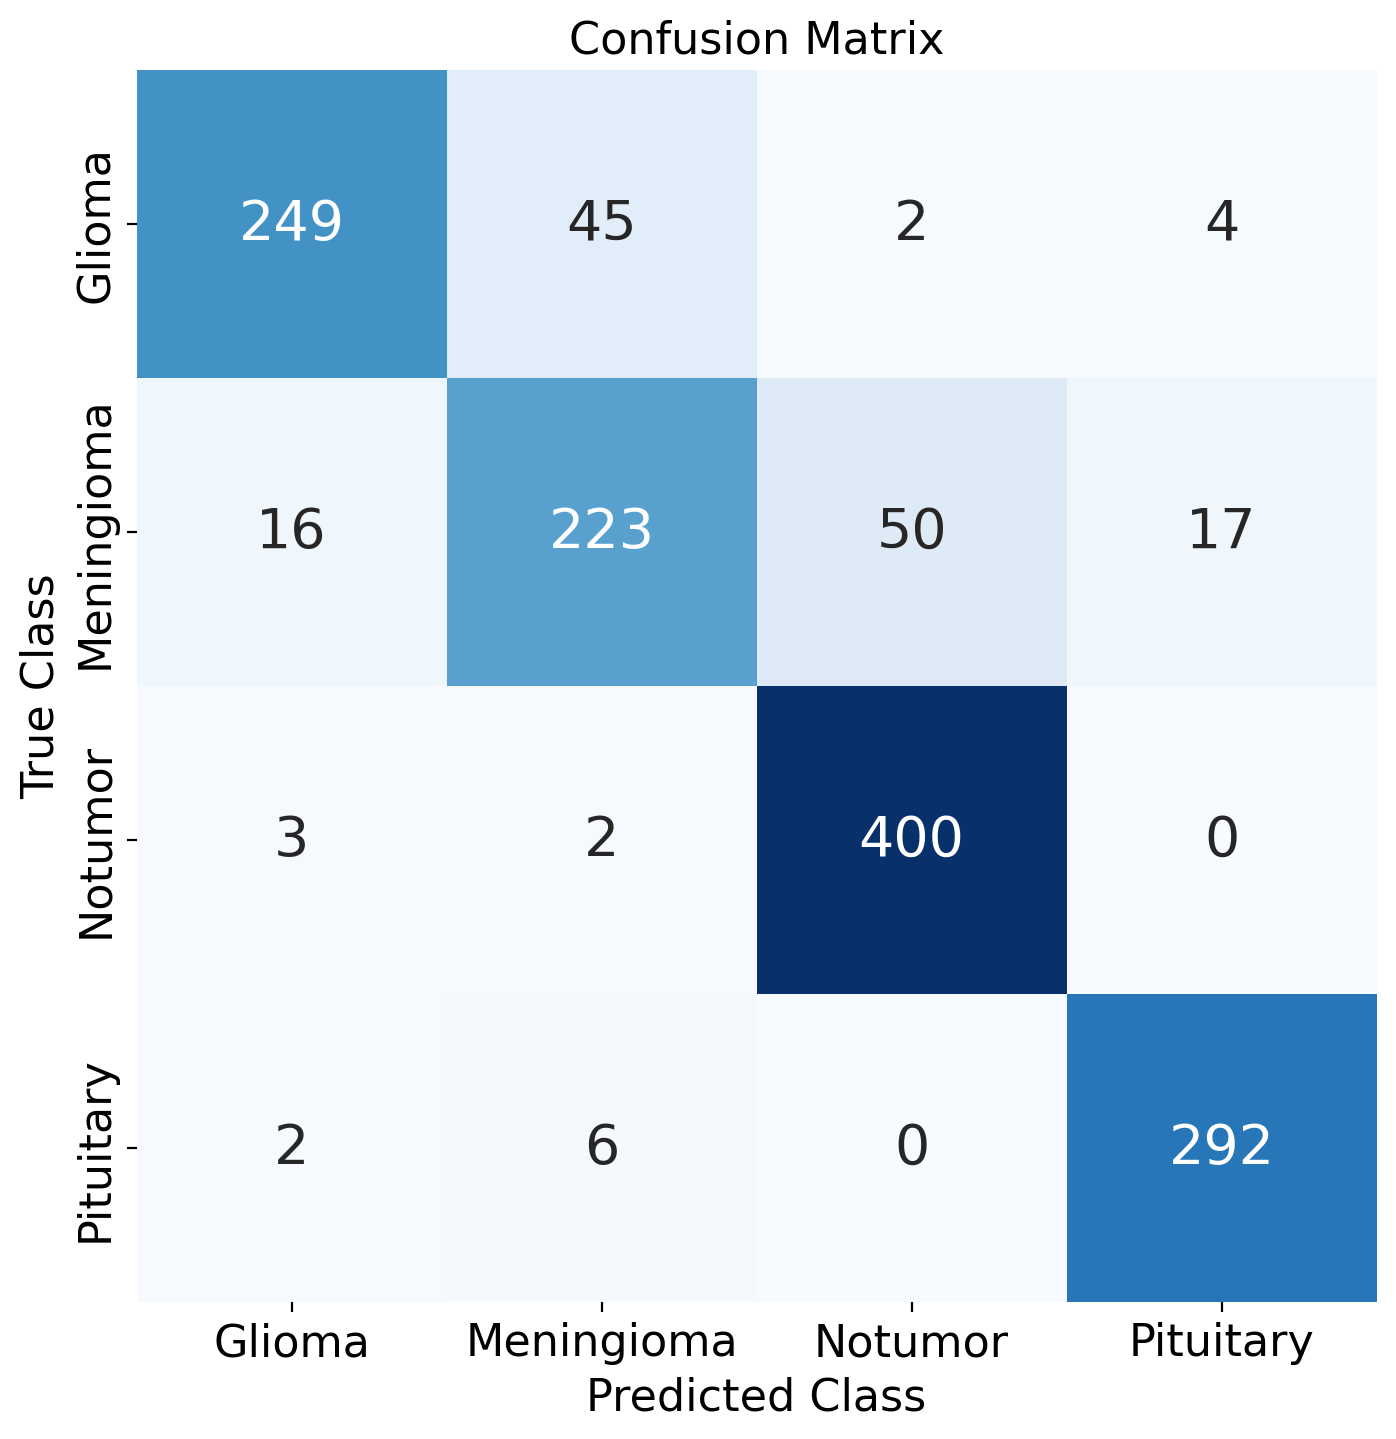

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.922222  0.830000  0.873684       300
  Meningioma   0.807971  0.728758  0.766323       306
     Notumor   0.884956  0.987654  0.933489       405
   Pituitary   0.932907  0.973333  0.952692       300

    accuracy                       0.887872      1311
   macro avg   0.887014  0.879936  0.881547      1311
weighted avg   0.886487  0.887872  0.885180      1311

Model saved in HDF5 format to /kaggle/working/model_4.h5


In [9]:
# Training batch size
batch_size = 4
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_4.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

# Training batch size = 8

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_9 has kernel size: (4, 4)
Layer conv2d_10 has kernel size: (4, 4)
Layer conv2d_11 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.4429 - loss: 1.1414 - val_accuracy: 0.2469 - val_loss: 2.1489 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7098 - loss: 0.7054 - val_accuracy: 0.5188 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7494 - loss: 0.6495 - val_accuracy: 0.9594 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7810 - loss: 0.5406 - val_accuracy: 0.9438 - val_loss: 0.2588 - learning_rate: 0.0010
Epoch 5/64
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.7621

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8743 - loss: 0.5143 - val_accuracy: 0.8065 - val_loss: 0.7989 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8270 - loss: 0.4644 - val_accuracy: 0.6219 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8212 - loss: 0.4441 - val_accuracy: 0.5656 - val_loss: 1.5284 - learning_rate: 0.0010
Epoch 8/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8076 - loss: 0.4382 - val_accuracy: 0.9469 - val_loss: 0.1640 - learning_rate: 0.0010
Epoch 9/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8558 - loss: 0.3897 - val_accuracy: 0.9594 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 10/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6257 - loss: 0.6128 - val_accuracy: 0.8065 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 11/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8521 - loss: 0.3642

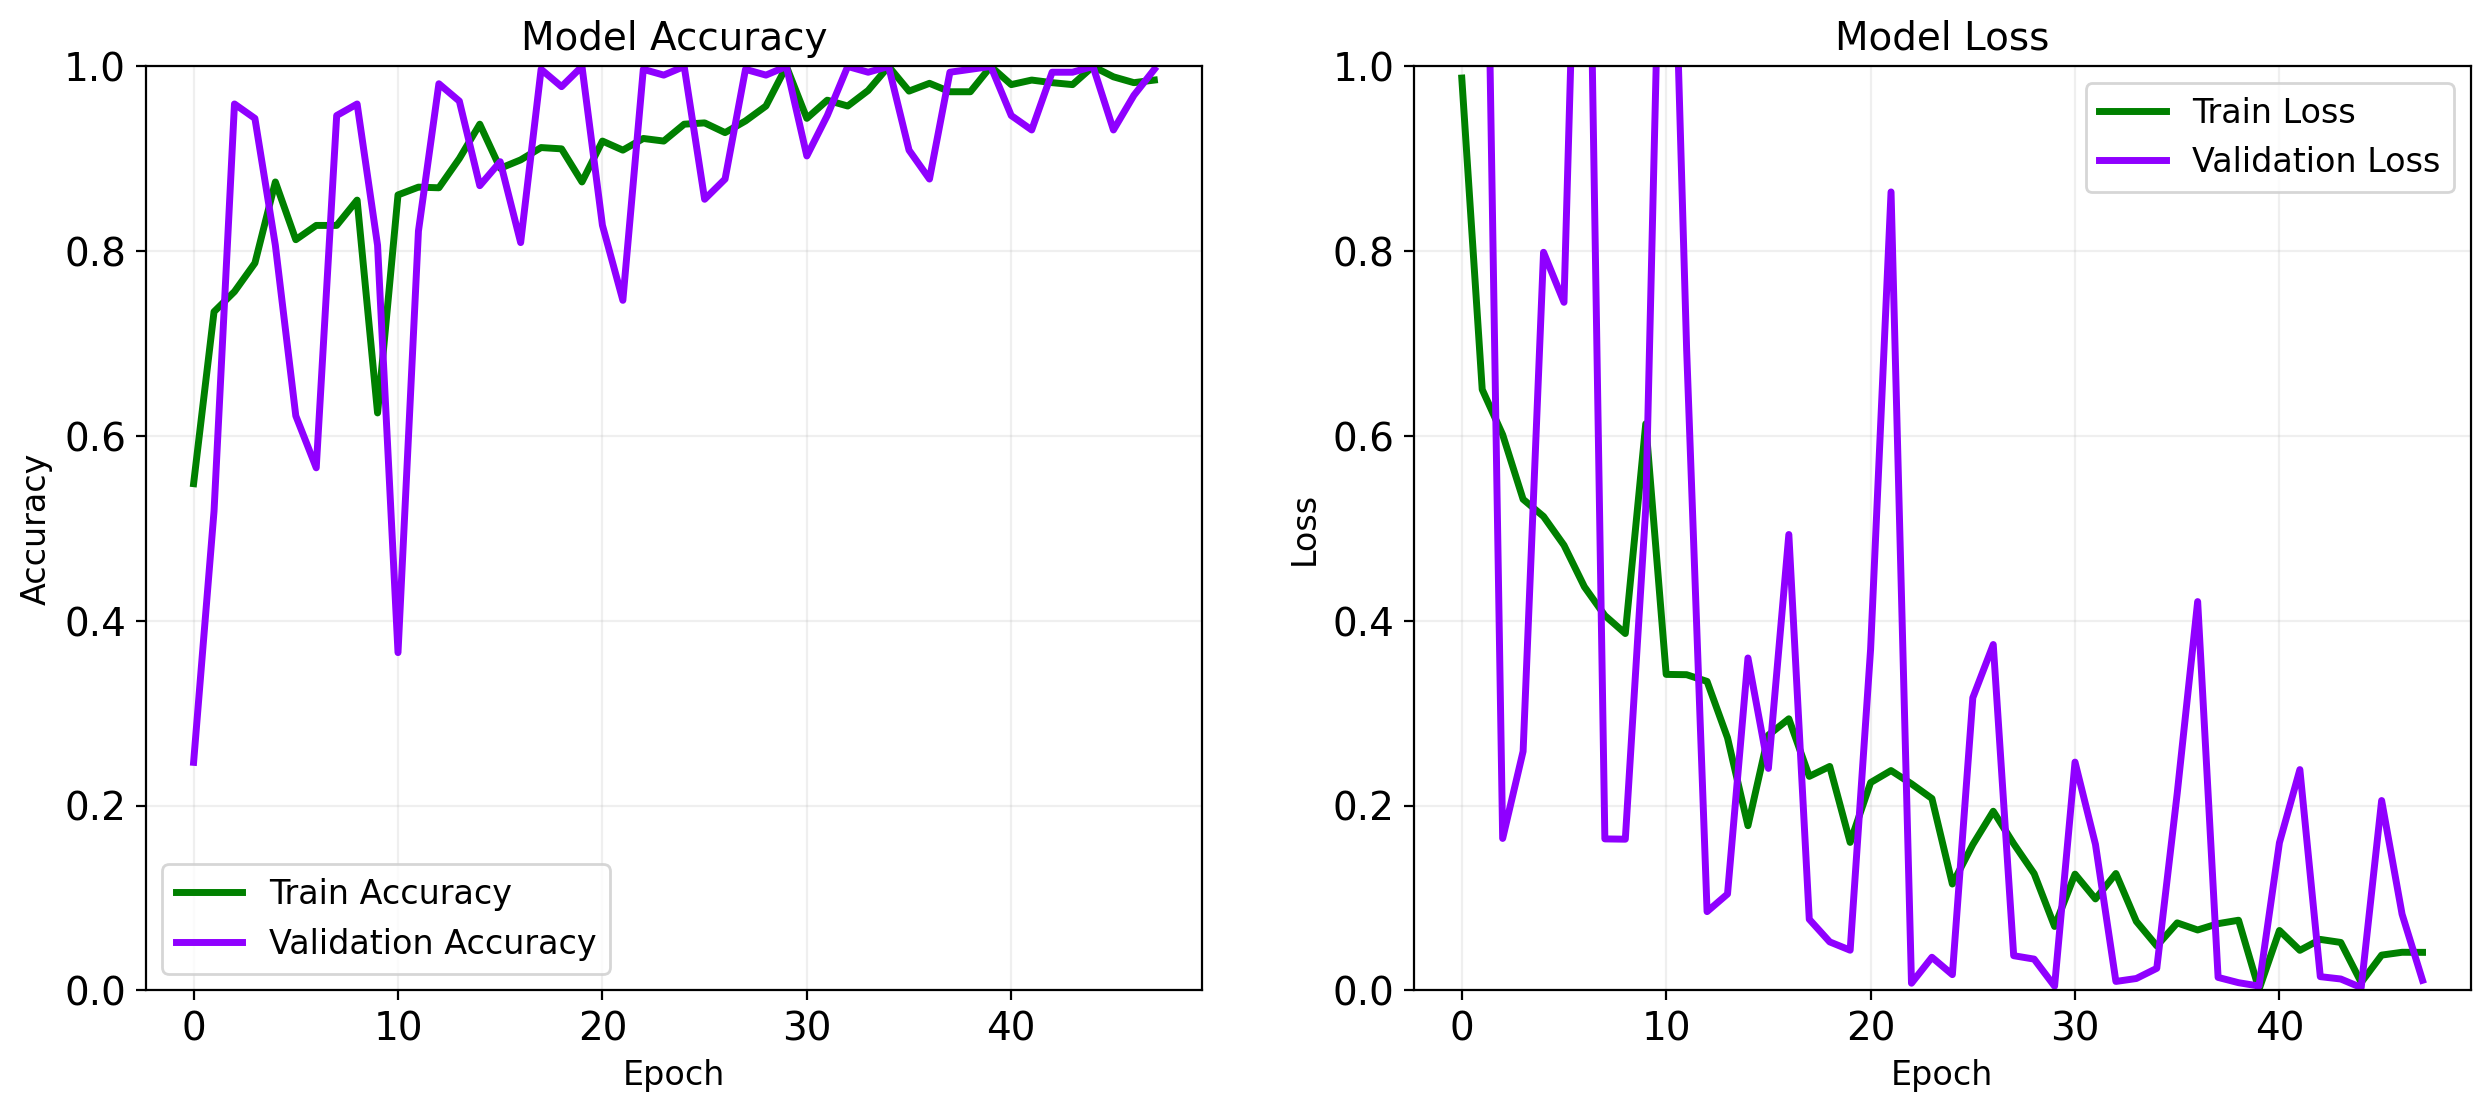

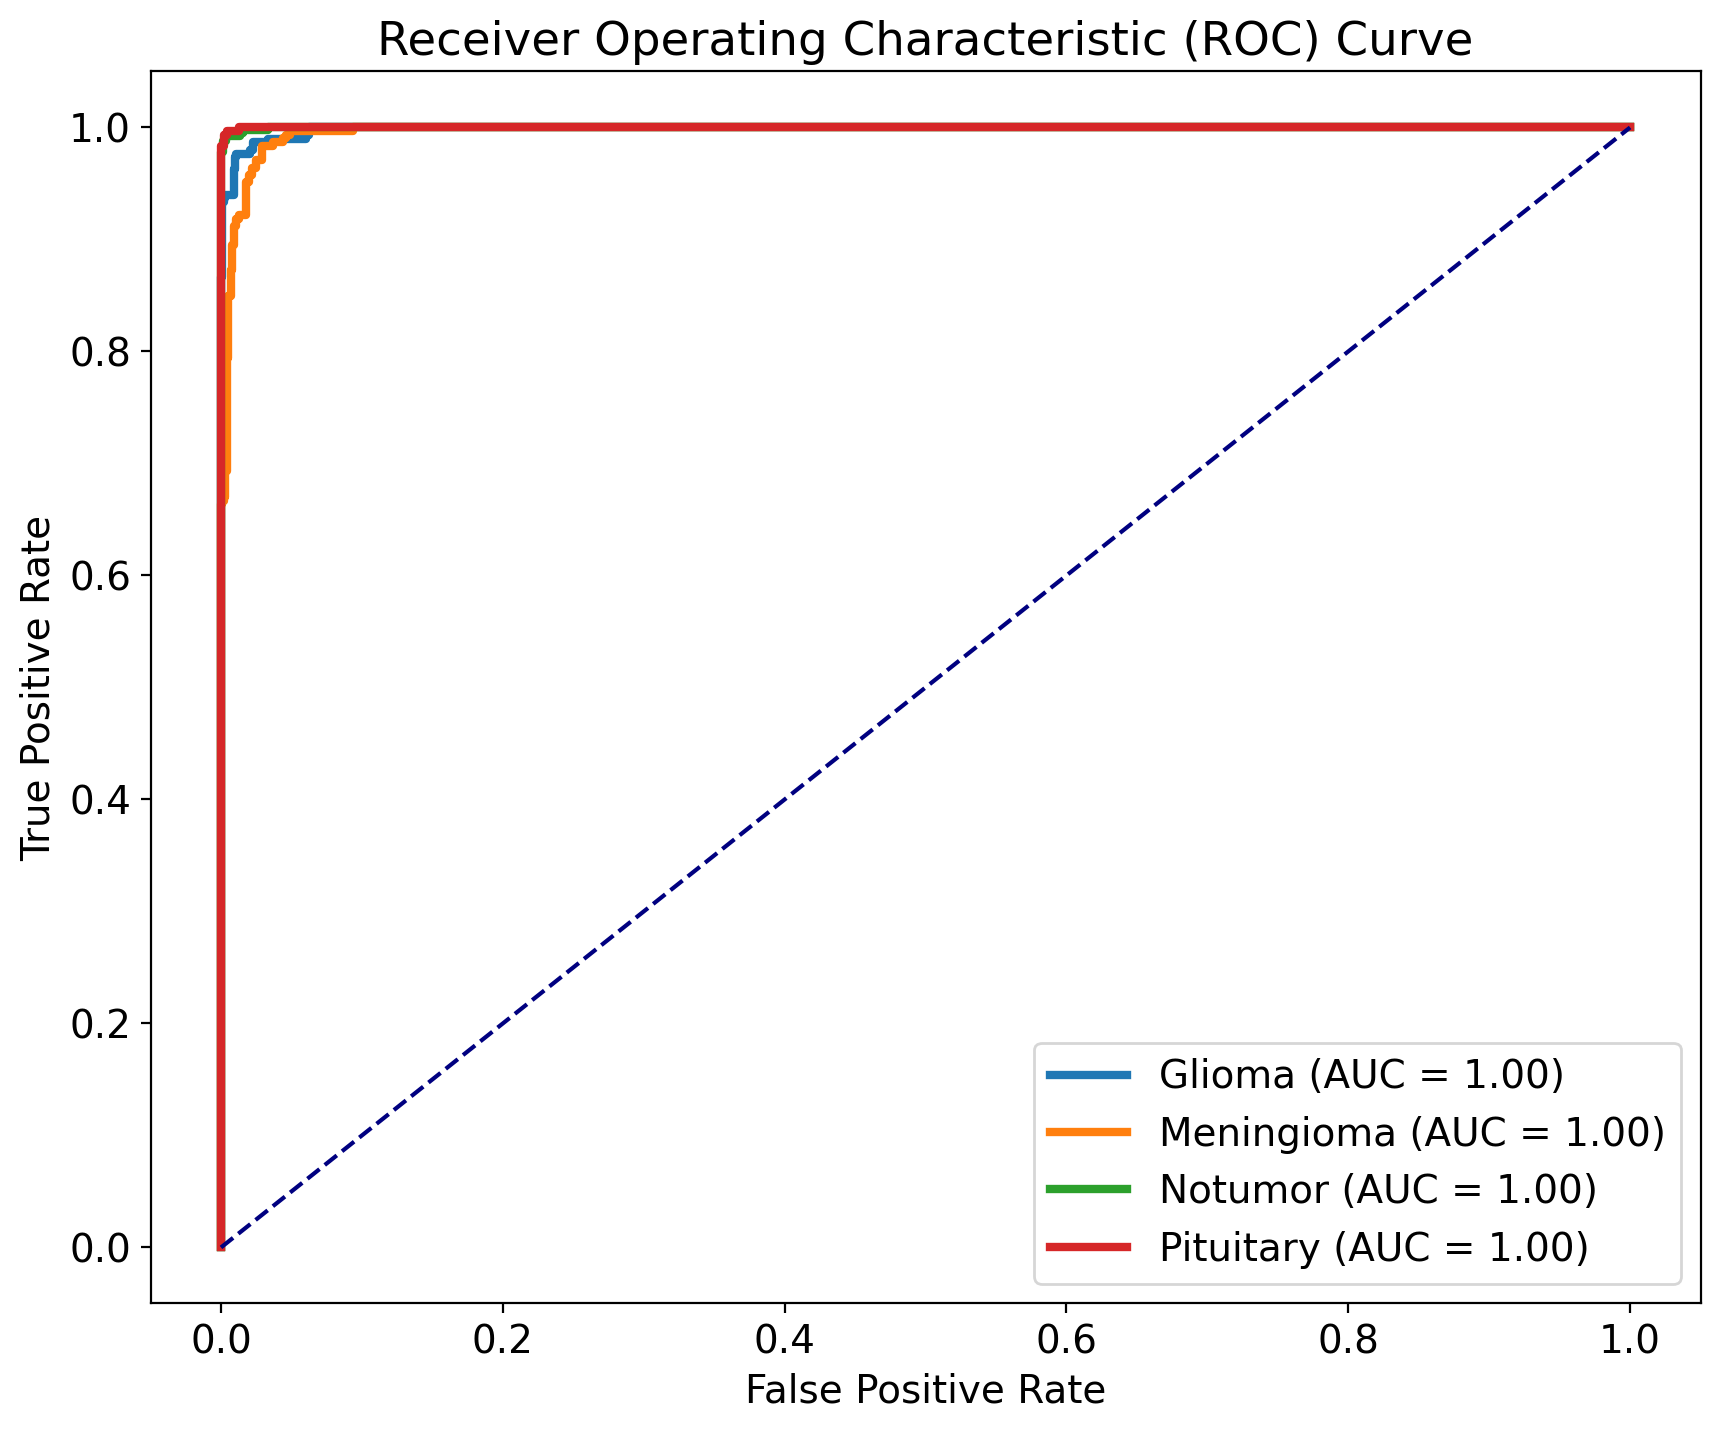

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


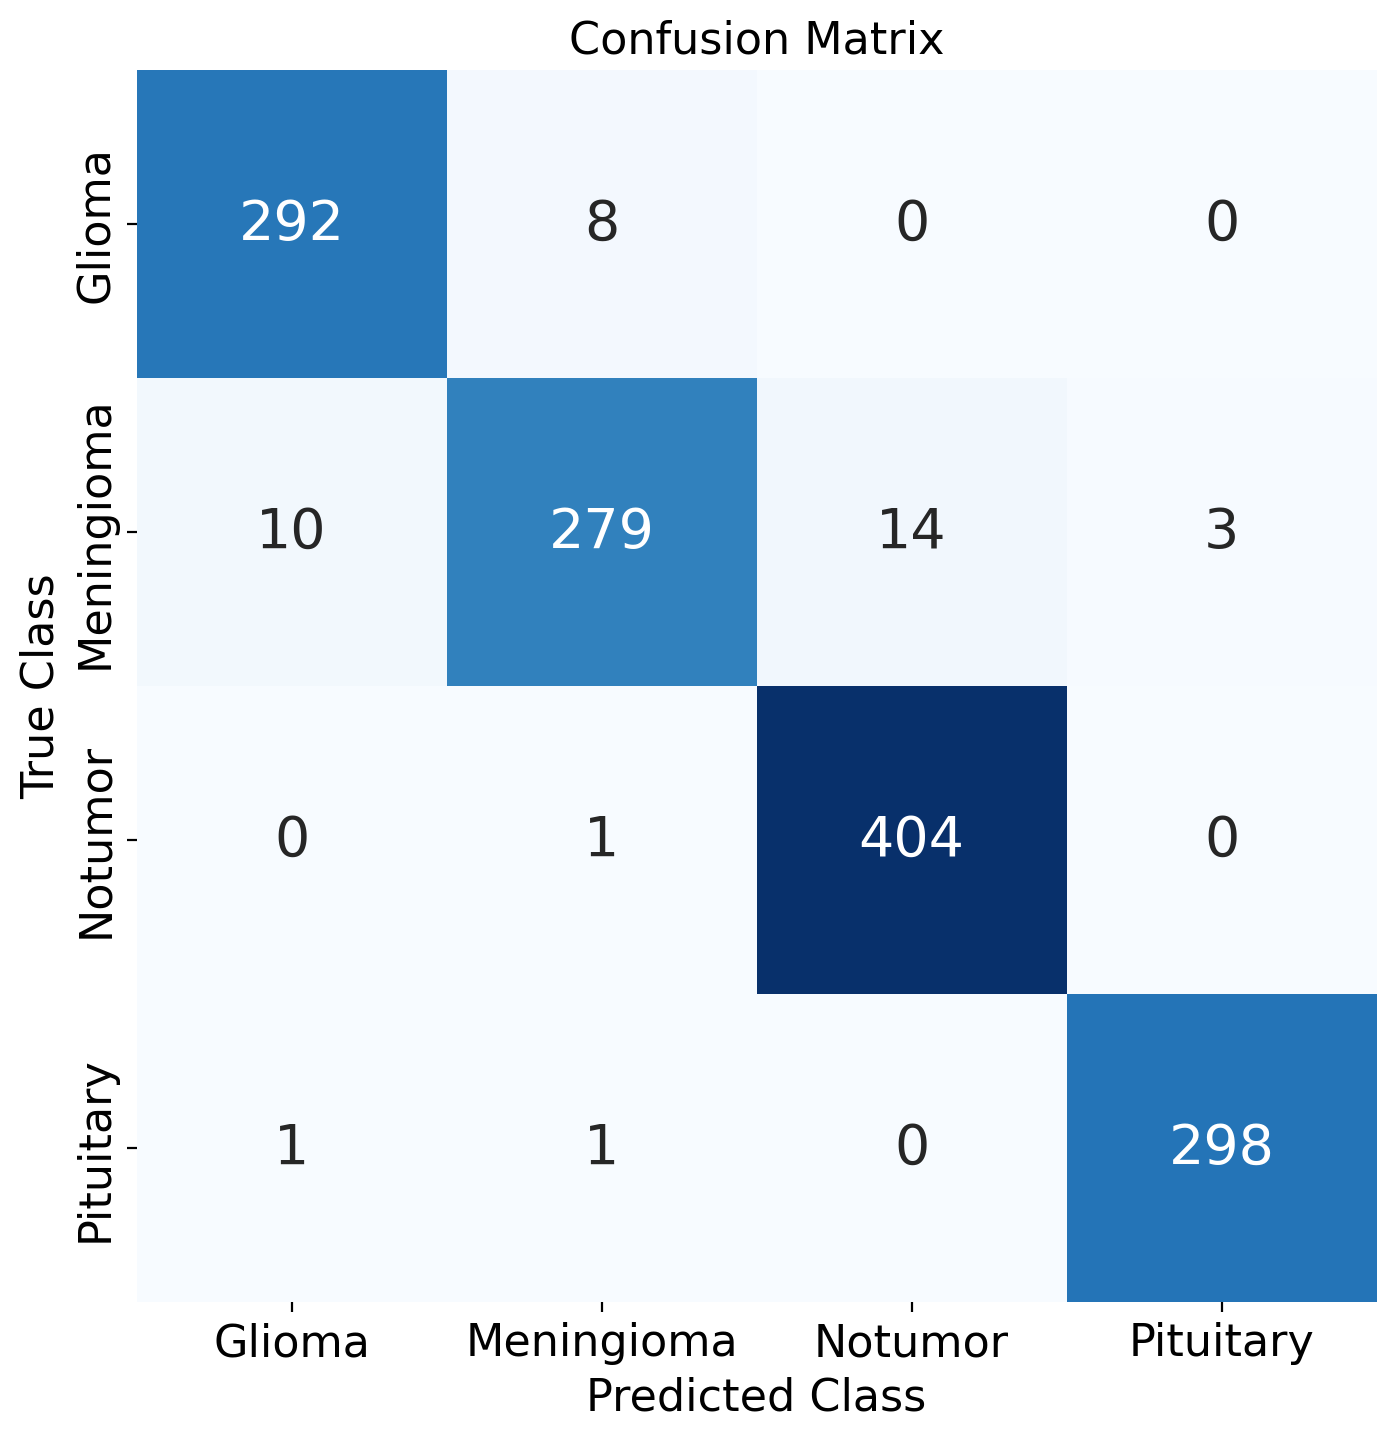

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.963696  0.973333  0.968491       300
  Meningioma   0.965398  0.911765  0.937815       306
     Notumor   0.966507  0.997531  0.981774       405
   Pituitary   0.990033  0.993333  0.991681       300

    accuracy                       0.971014      1311
   macro avg   0.971409  0.968991  0.969940      1311
weighted avg   0.970989  0.971014  0.970741      1311

Model saved in HDF5 format to /kaggle/working/model_8.h5


In [10]:
# Training batch size
batch_size = 8
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_8.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

# Training batch size = 16

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_12 has kernel size: (4, 4)
Layer conv2d_13 has kernel size: (4, 4)
Layer conv2d_14 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.5007 - loss: 1.0854 - val_accuracy: 0.4812 - val_loss: 1.3933 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.7513 - loss: 0.6372 - val_accuracy: 0.9406 - val_loss: 0.2649 - learning_rate: 0.0010
Epoch 3/64
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8750 - loss: 0.4564

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.4564 - val_accuracy: 0.7419 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.7881 - loss: 0.5120 - val_accuracy: 0.5625 - val_loss: 1.0446 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.7998 - loss: 0.4713 - val_accuracy: 0.9734 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.8750 - loss: 0.3730 - val_accuracy: 0.9355 - val_loss: 0.2530 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.8432 - loss: 0.3906 - val_accuracy: 0.6672 - val_loss: 0.8013 - learning_rate: 0.0010
Epoch 8/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.8495 - loss: 0.3840 - val_accuracy: 0.9547 - val_loss: 0.1794 - learning_rate: 0.0010
Epoch 9/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.9375 - loss: 0.33

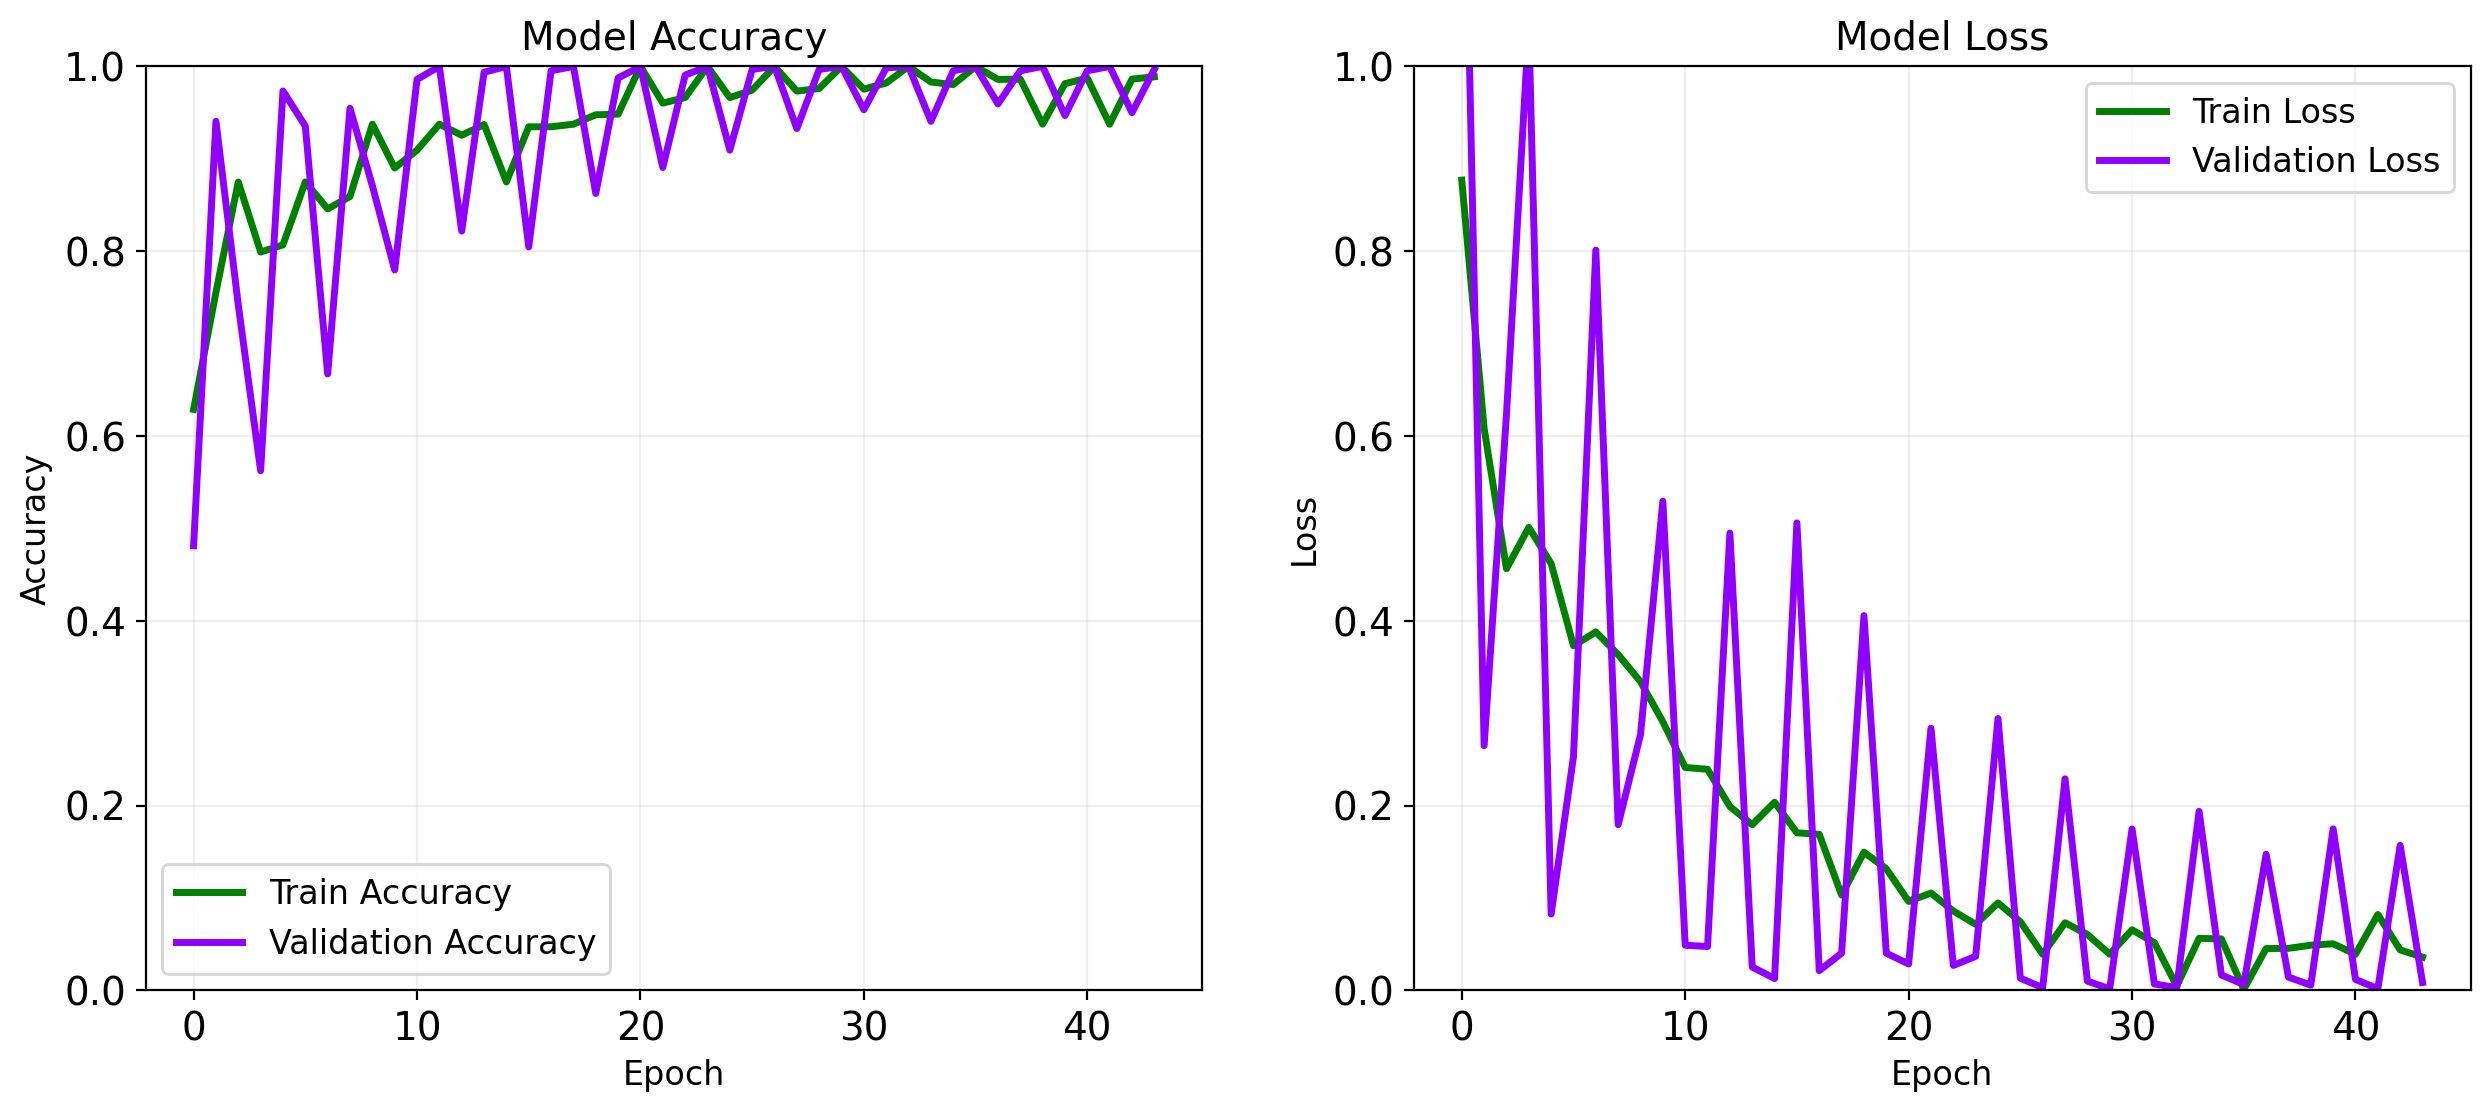

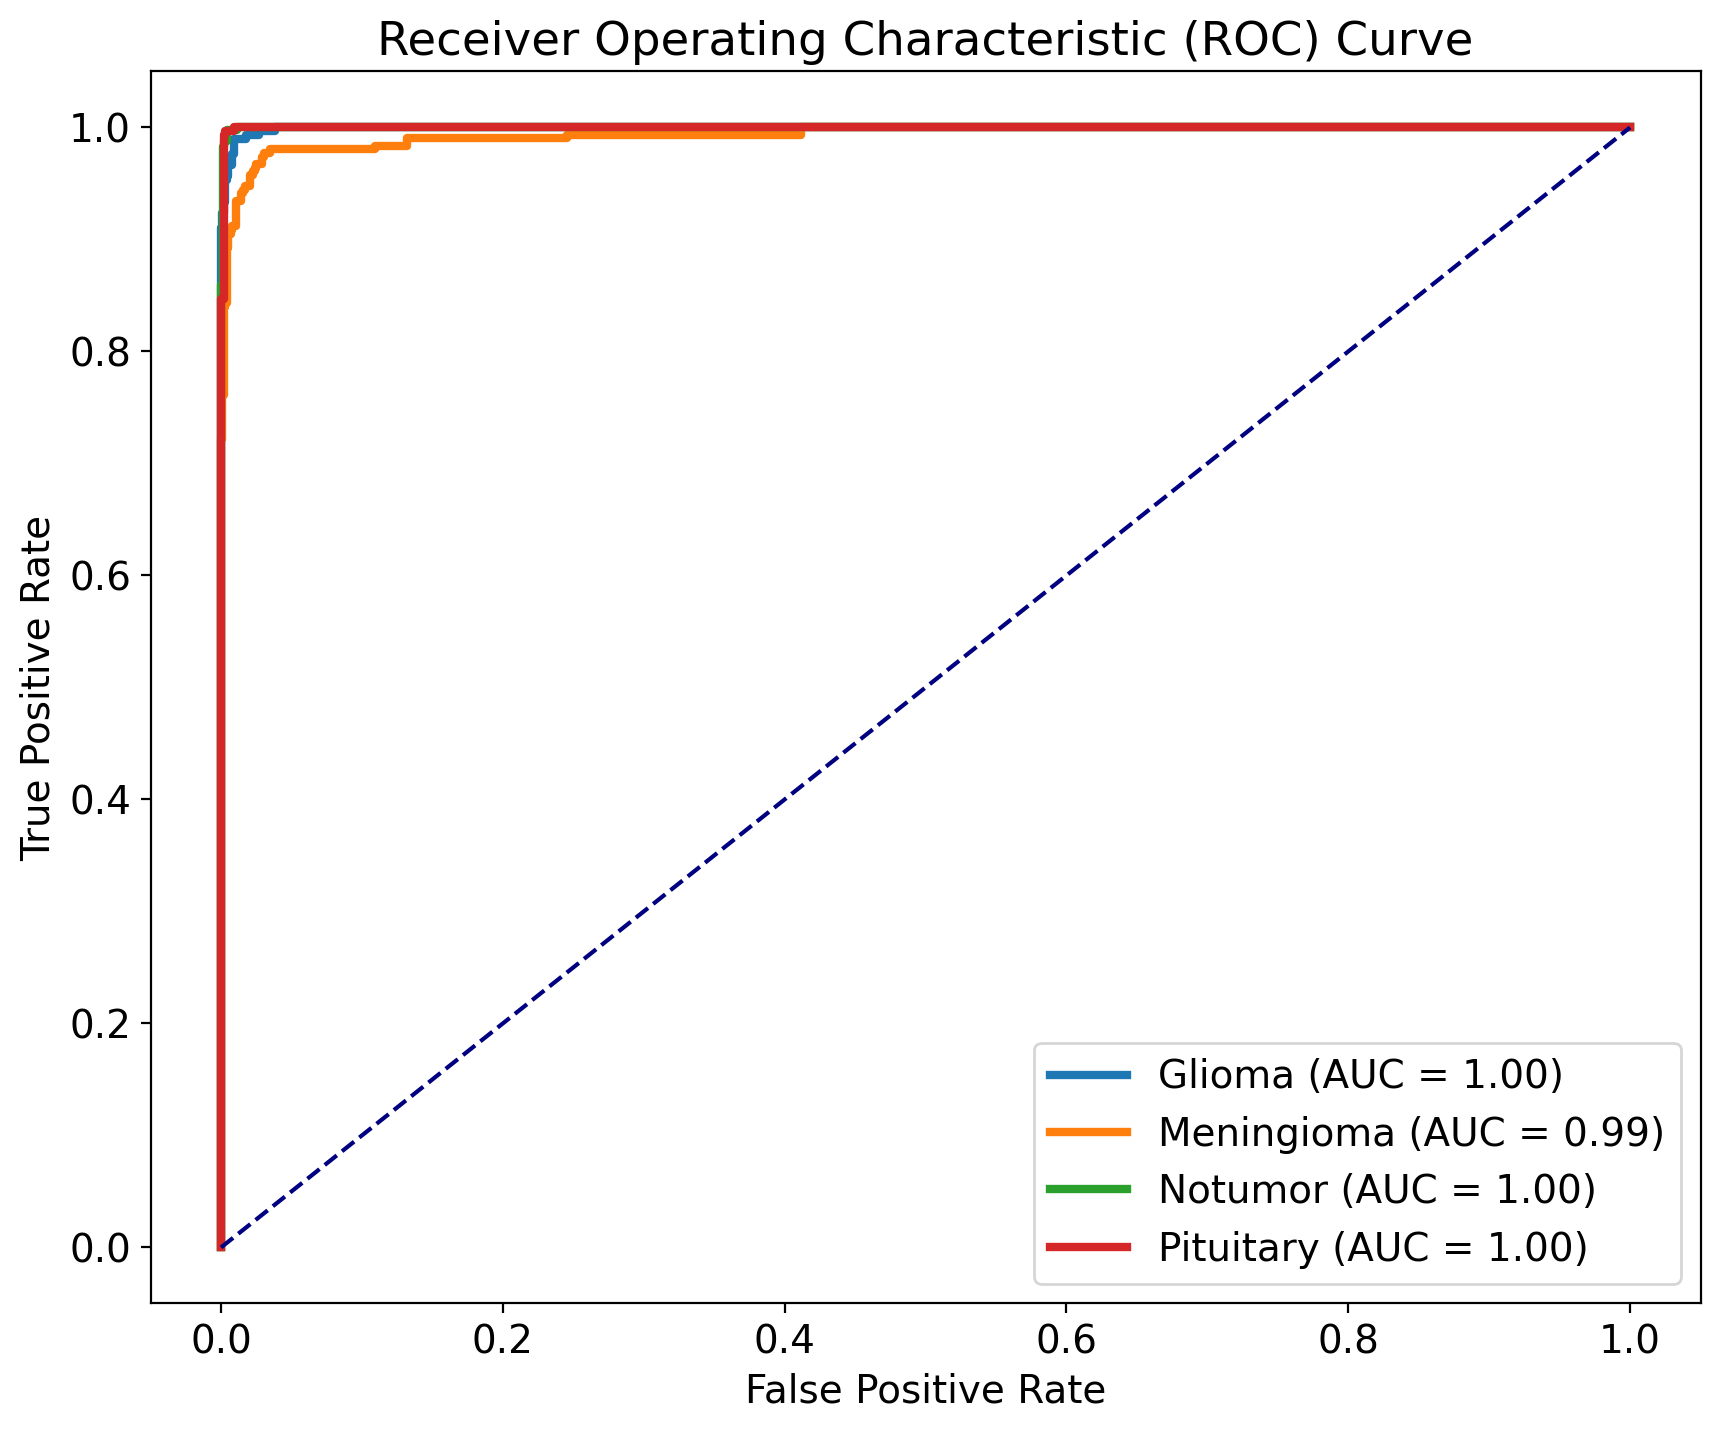

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


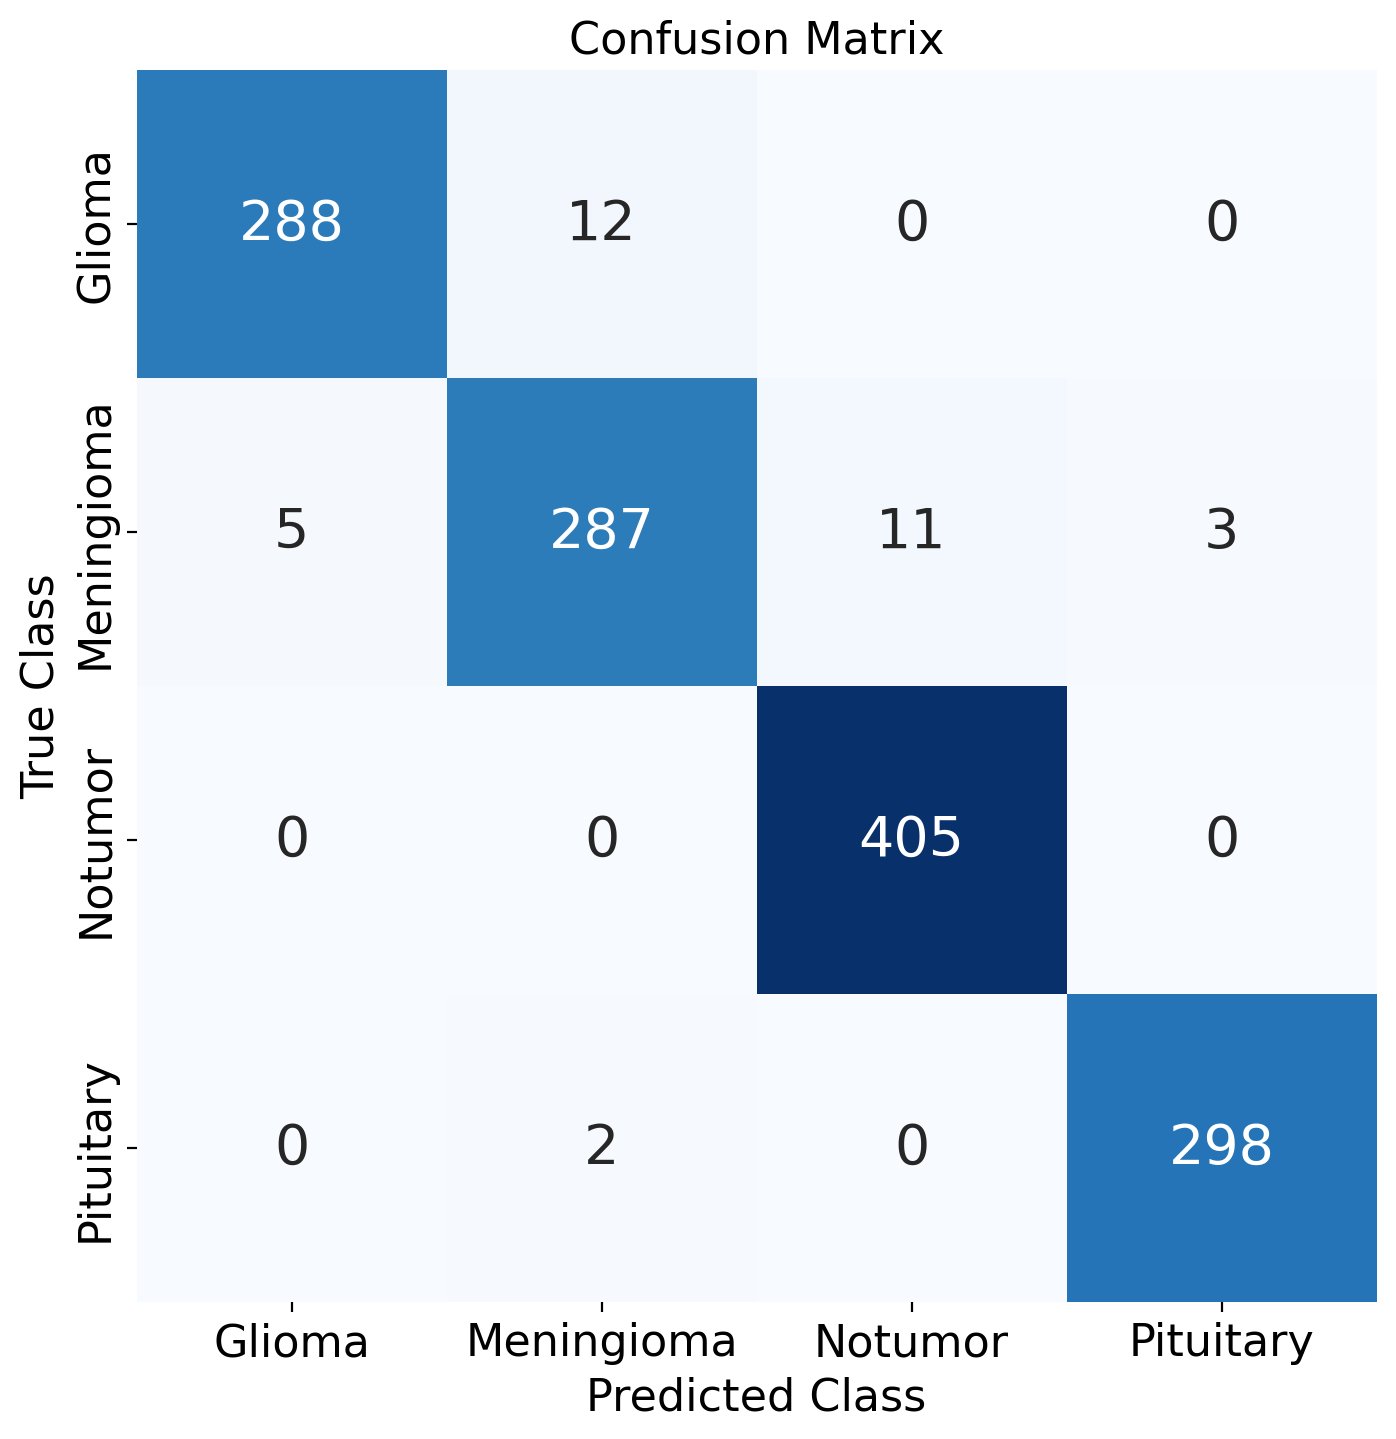

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.982935  0.960000  0.971332       300
  Meningioma   0.953488  0.937908  0.945634       306
     Notumor   0.973558  1.000000  0.986602       405
   Pituitary   0.990033  0.993333  0.991681       300

    accuracy                       0.974828      1311
   macro avg   0.975004  0.972810  0.973812      1311
weighted avg   0.974789  0.974828  0.974708      1311

Model saved in HDF5 format to /kaggle/working/model_16.h5


In [11]:
# Training batch size
batch_size = 16
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_16.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

# Training batch size = 64

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_15 has kernel size: (4, 4)
Layer conv2d_16 has kernel size: (4, 4)
Layer conv2d_17 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 87/178 ━━━━━━━━━━━━━━━━━━━━ 40s 450ms/step - accuracy: 0.5122 - loss: 1.0640

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 50s 237ms/step - accuracy: 0.5759 - loss: 0.9561 - val_accuracy: 0.7170 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.7763 - loss: 0.5651 - val_accuracy: 0.7384 - val_loss: 0.7295 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8201 - loss: 0.4583 - val_accuracy: 0.7963 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.8518 - loss: 0.3839 - val_accuracy: 0.8322 - val_loss: 0.3824 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.8714 - loss: 0.3292 - val_accuracy: 0.8574 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.9051 - loss: 0.2626 - val_accuracy: 0.8551 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.9164 - loss:

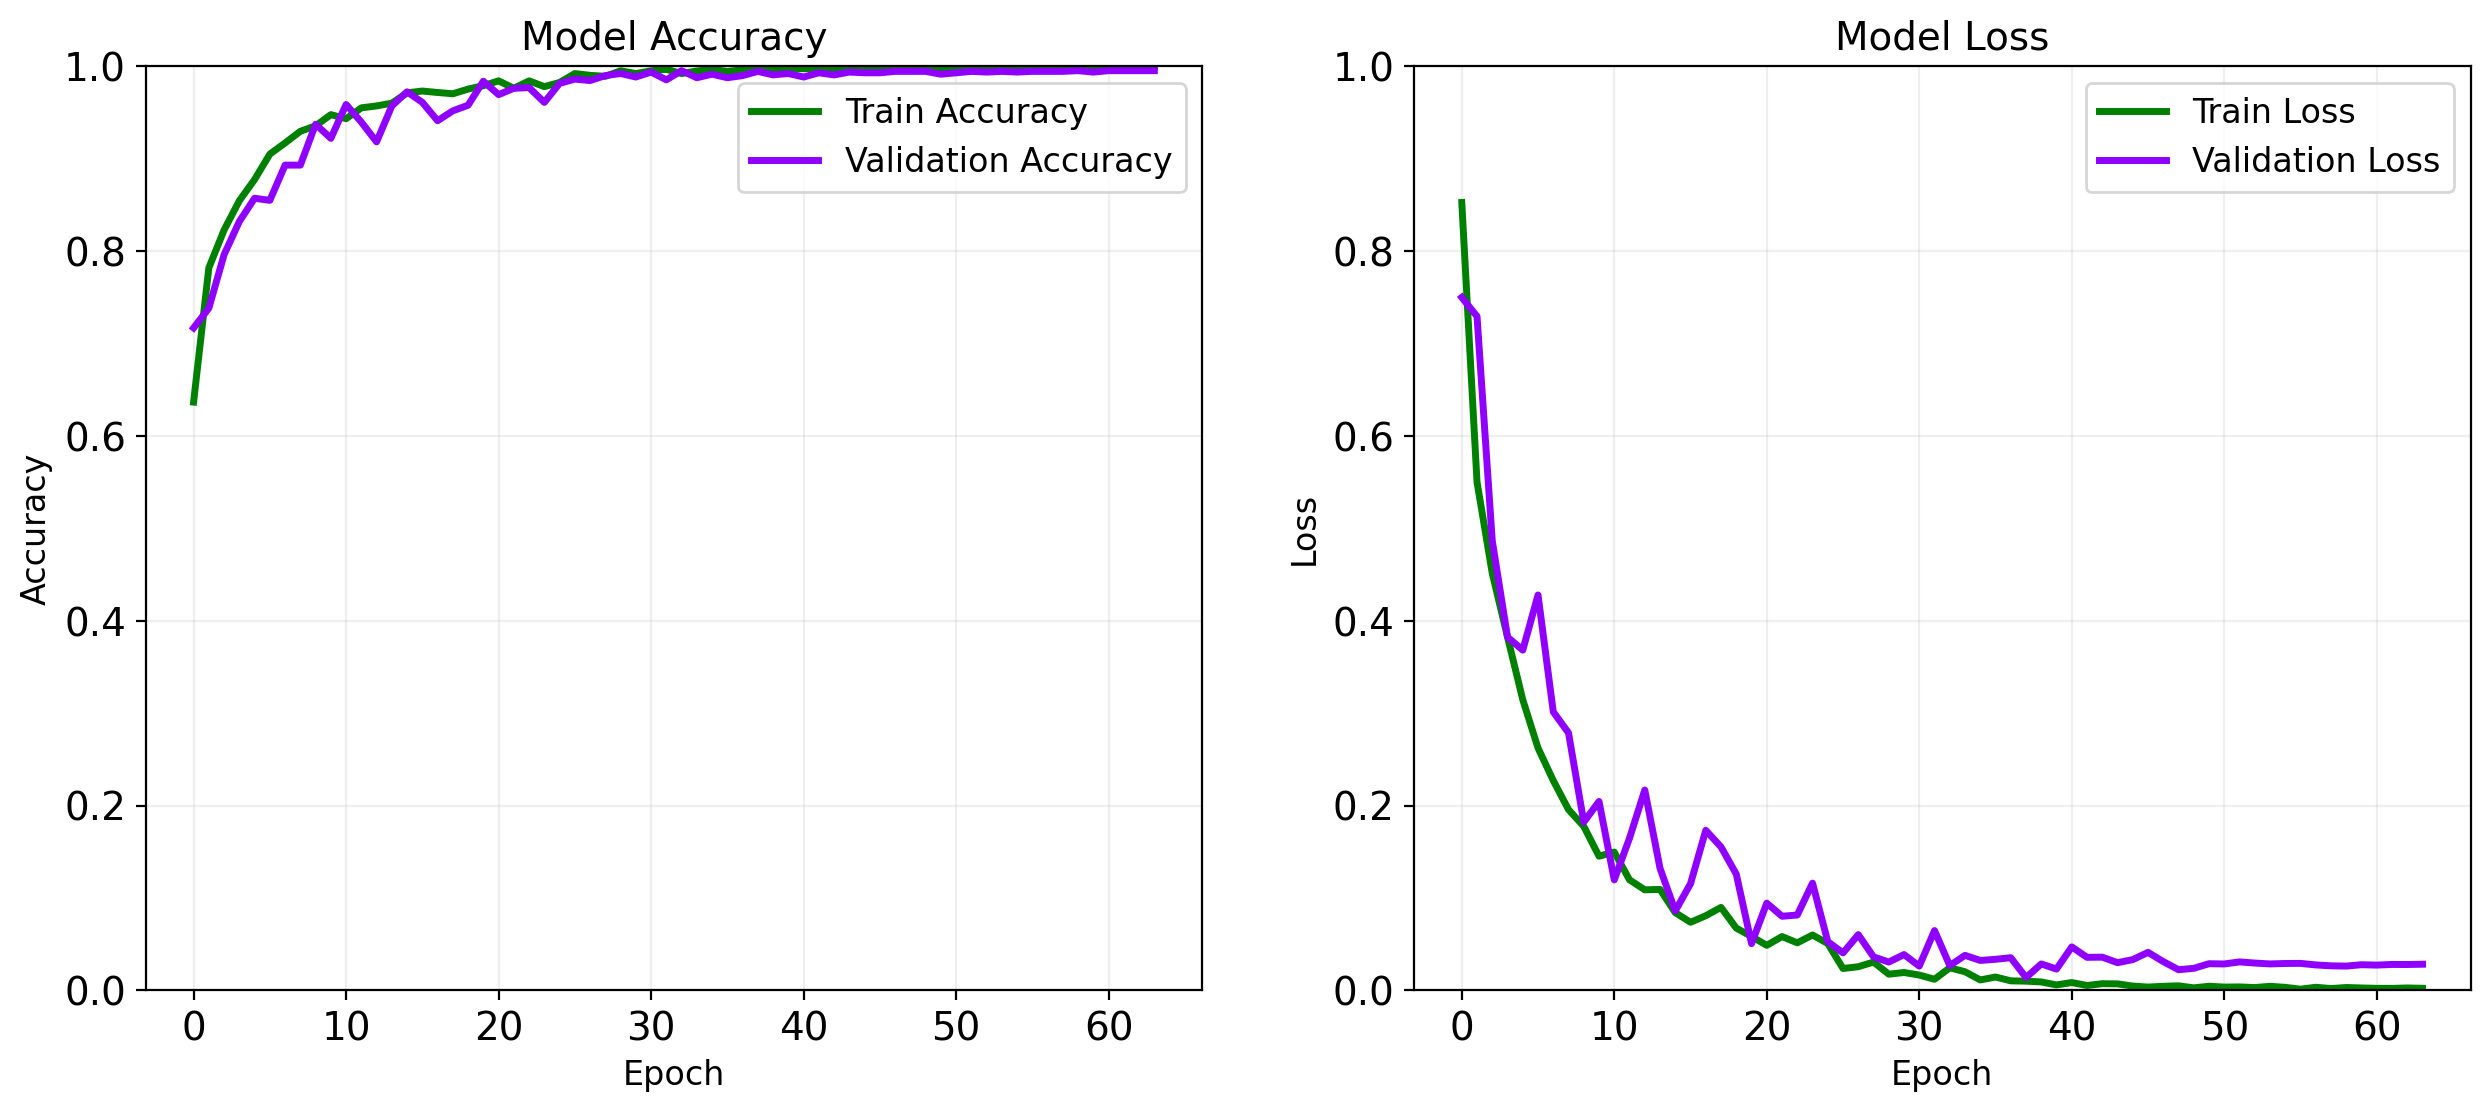

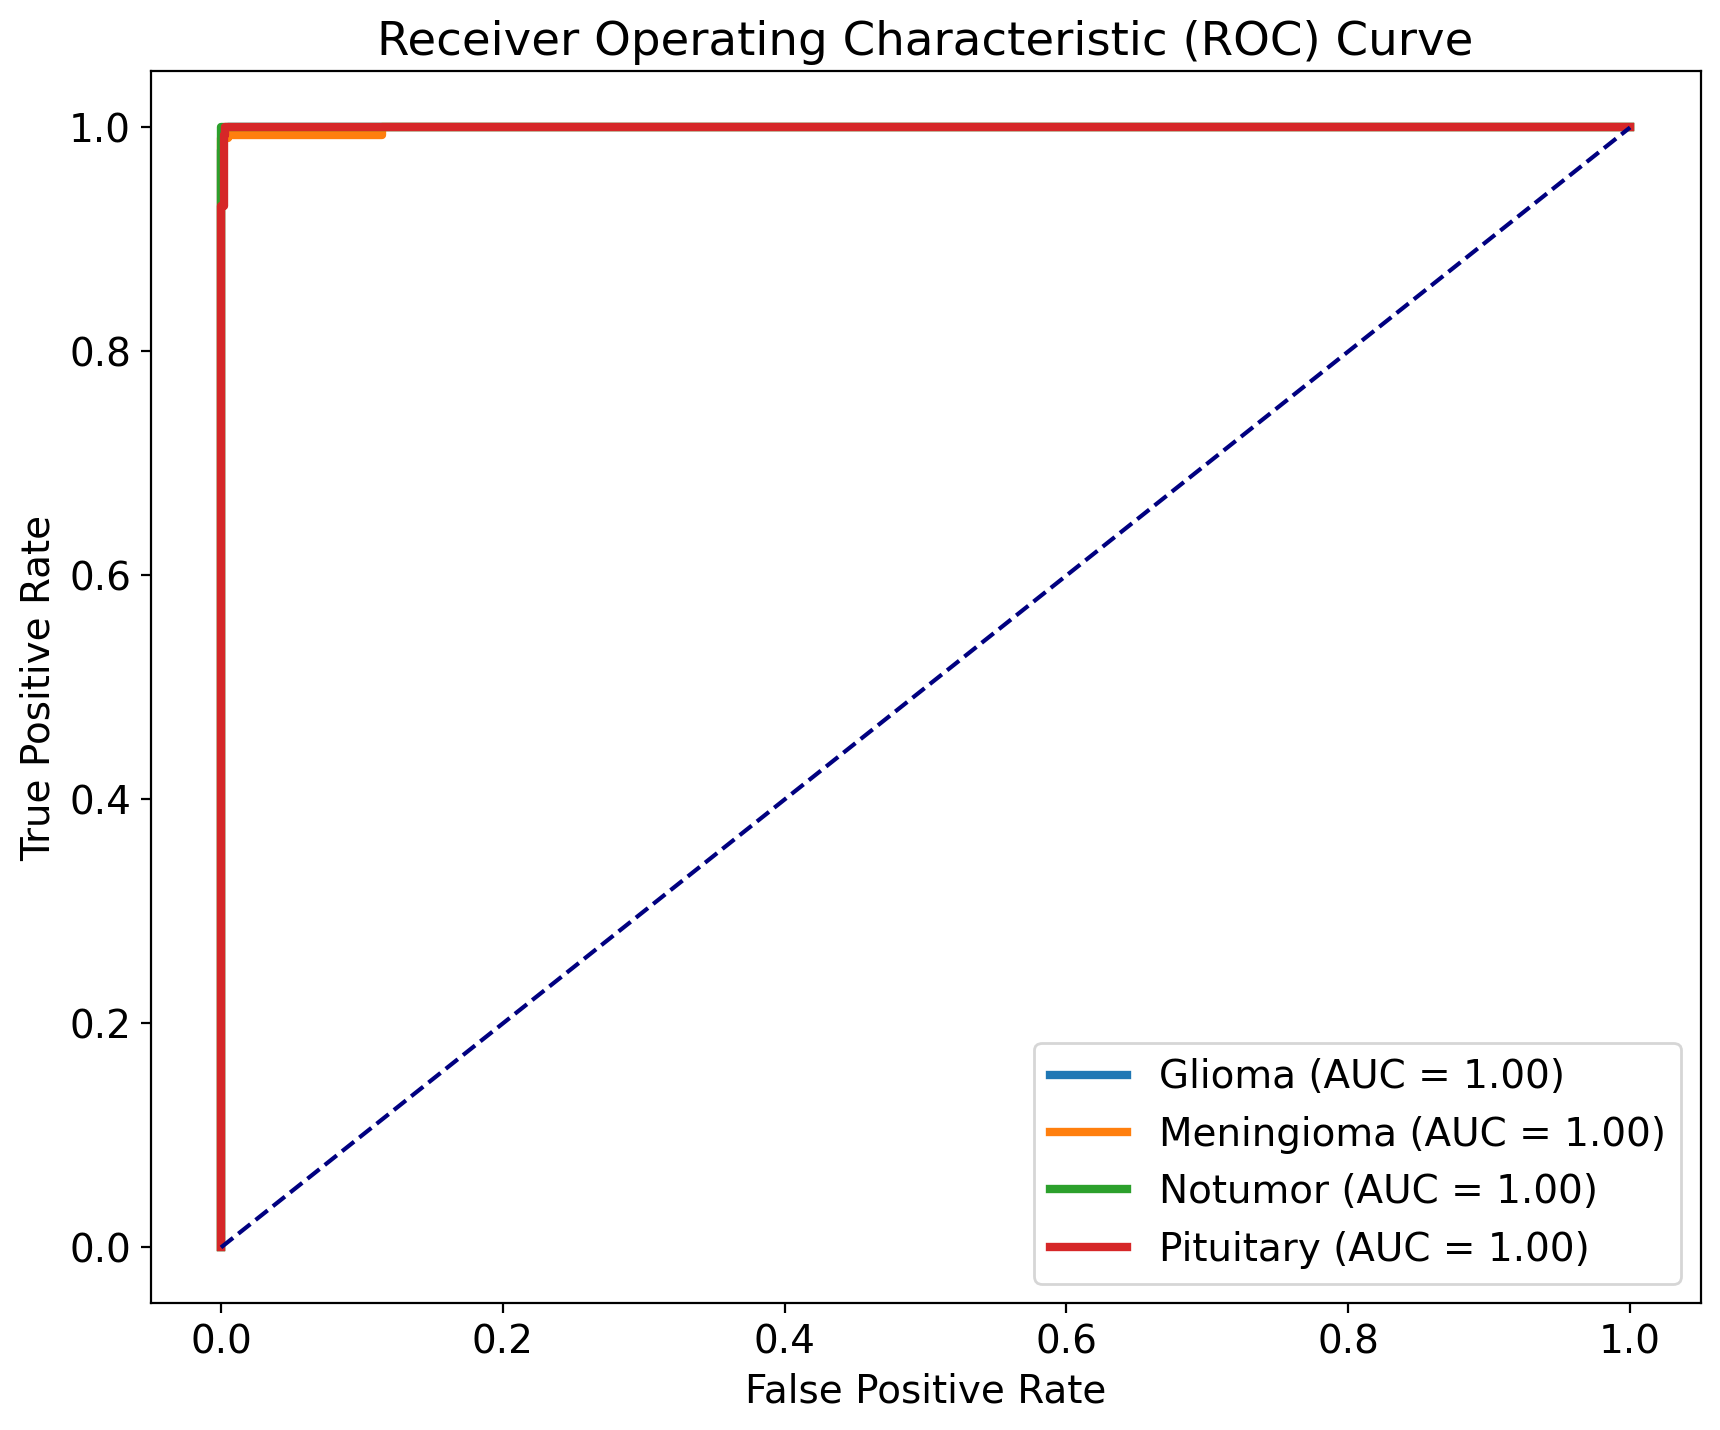

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step


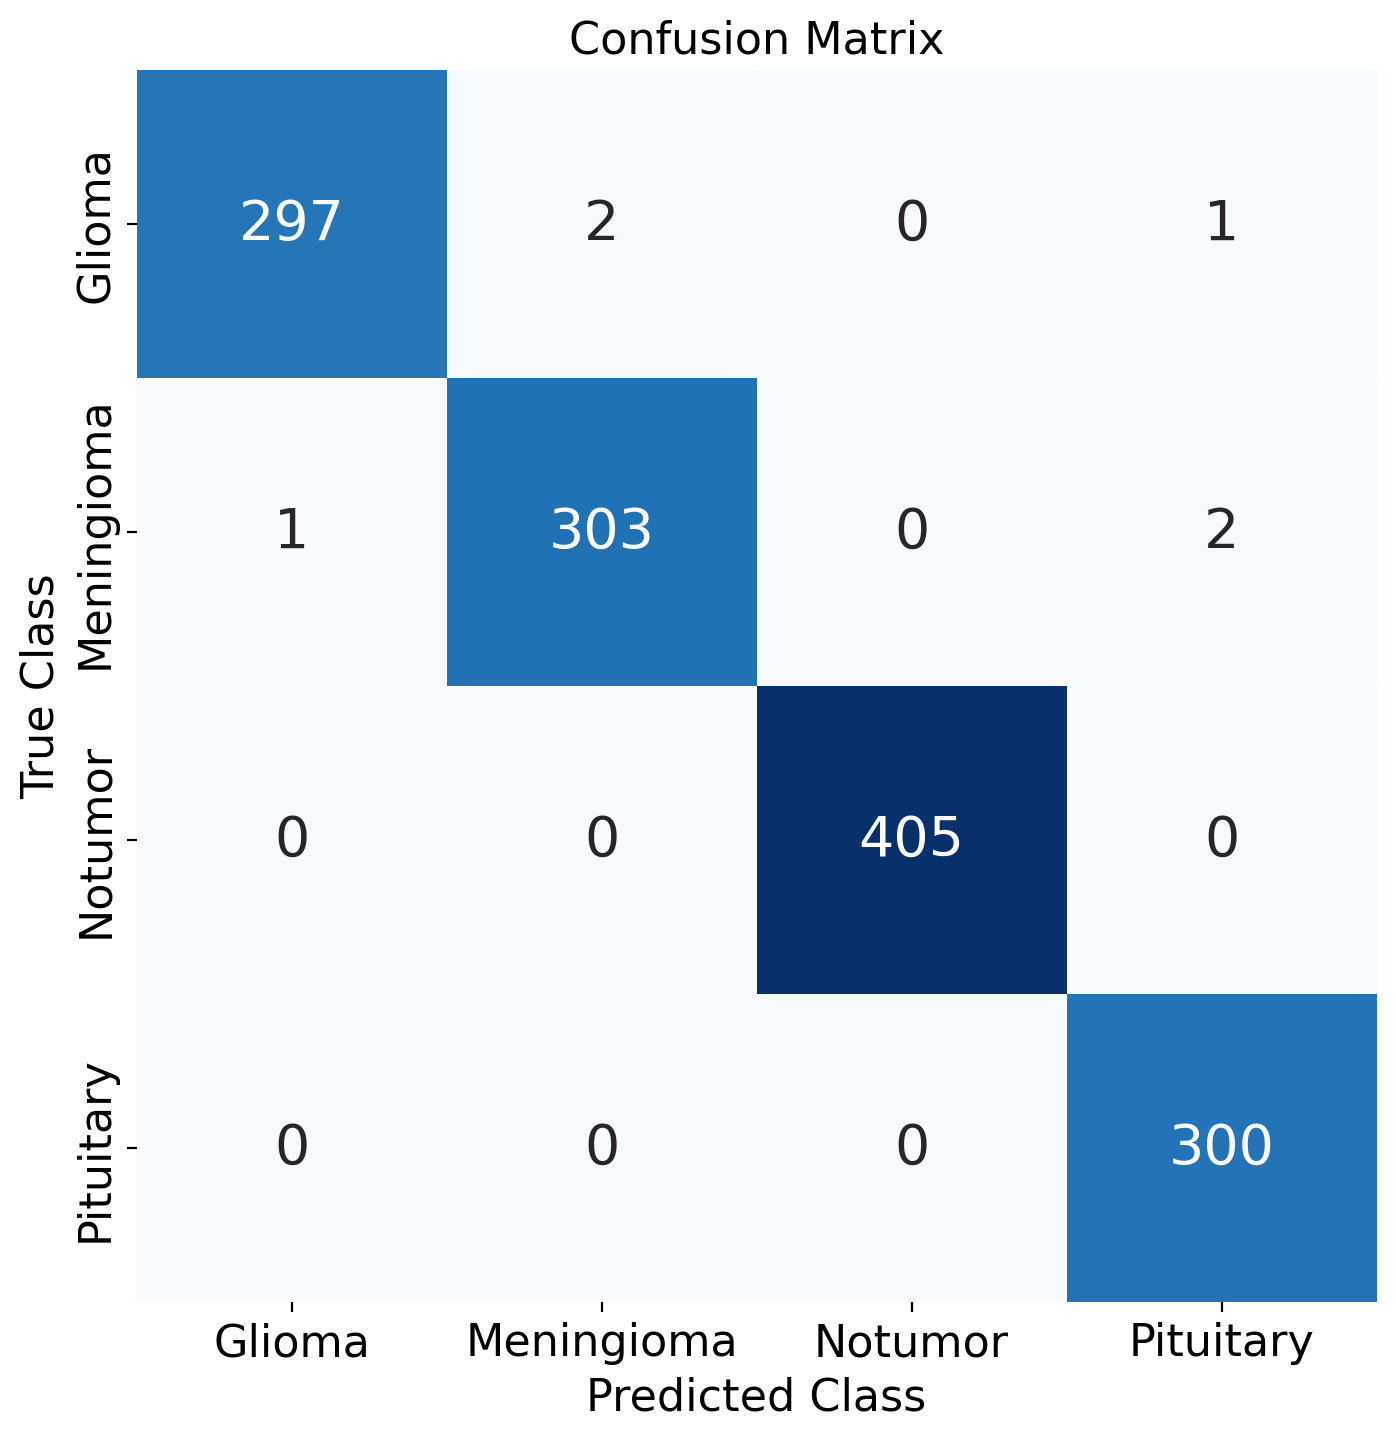

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.996644  0.990000  0.993311       300
  Meningioma   0.993443  0.990196  0.991817       306
     Notumor   1.000000  1.000000  1.000000       405
   Pituitary   0.990099  1.000000  0.995025       300

    accuracy                       0.995423      1311
   macro avg   0.995046  0.995049  0.995038      1311
weighted avg   0.995436  0.995423  0.995421      1311

Model saved in HDF5 format to /kaggle/working/model_64.h5


In [12]:
# Training batch size
batch_size = 64
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_64.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


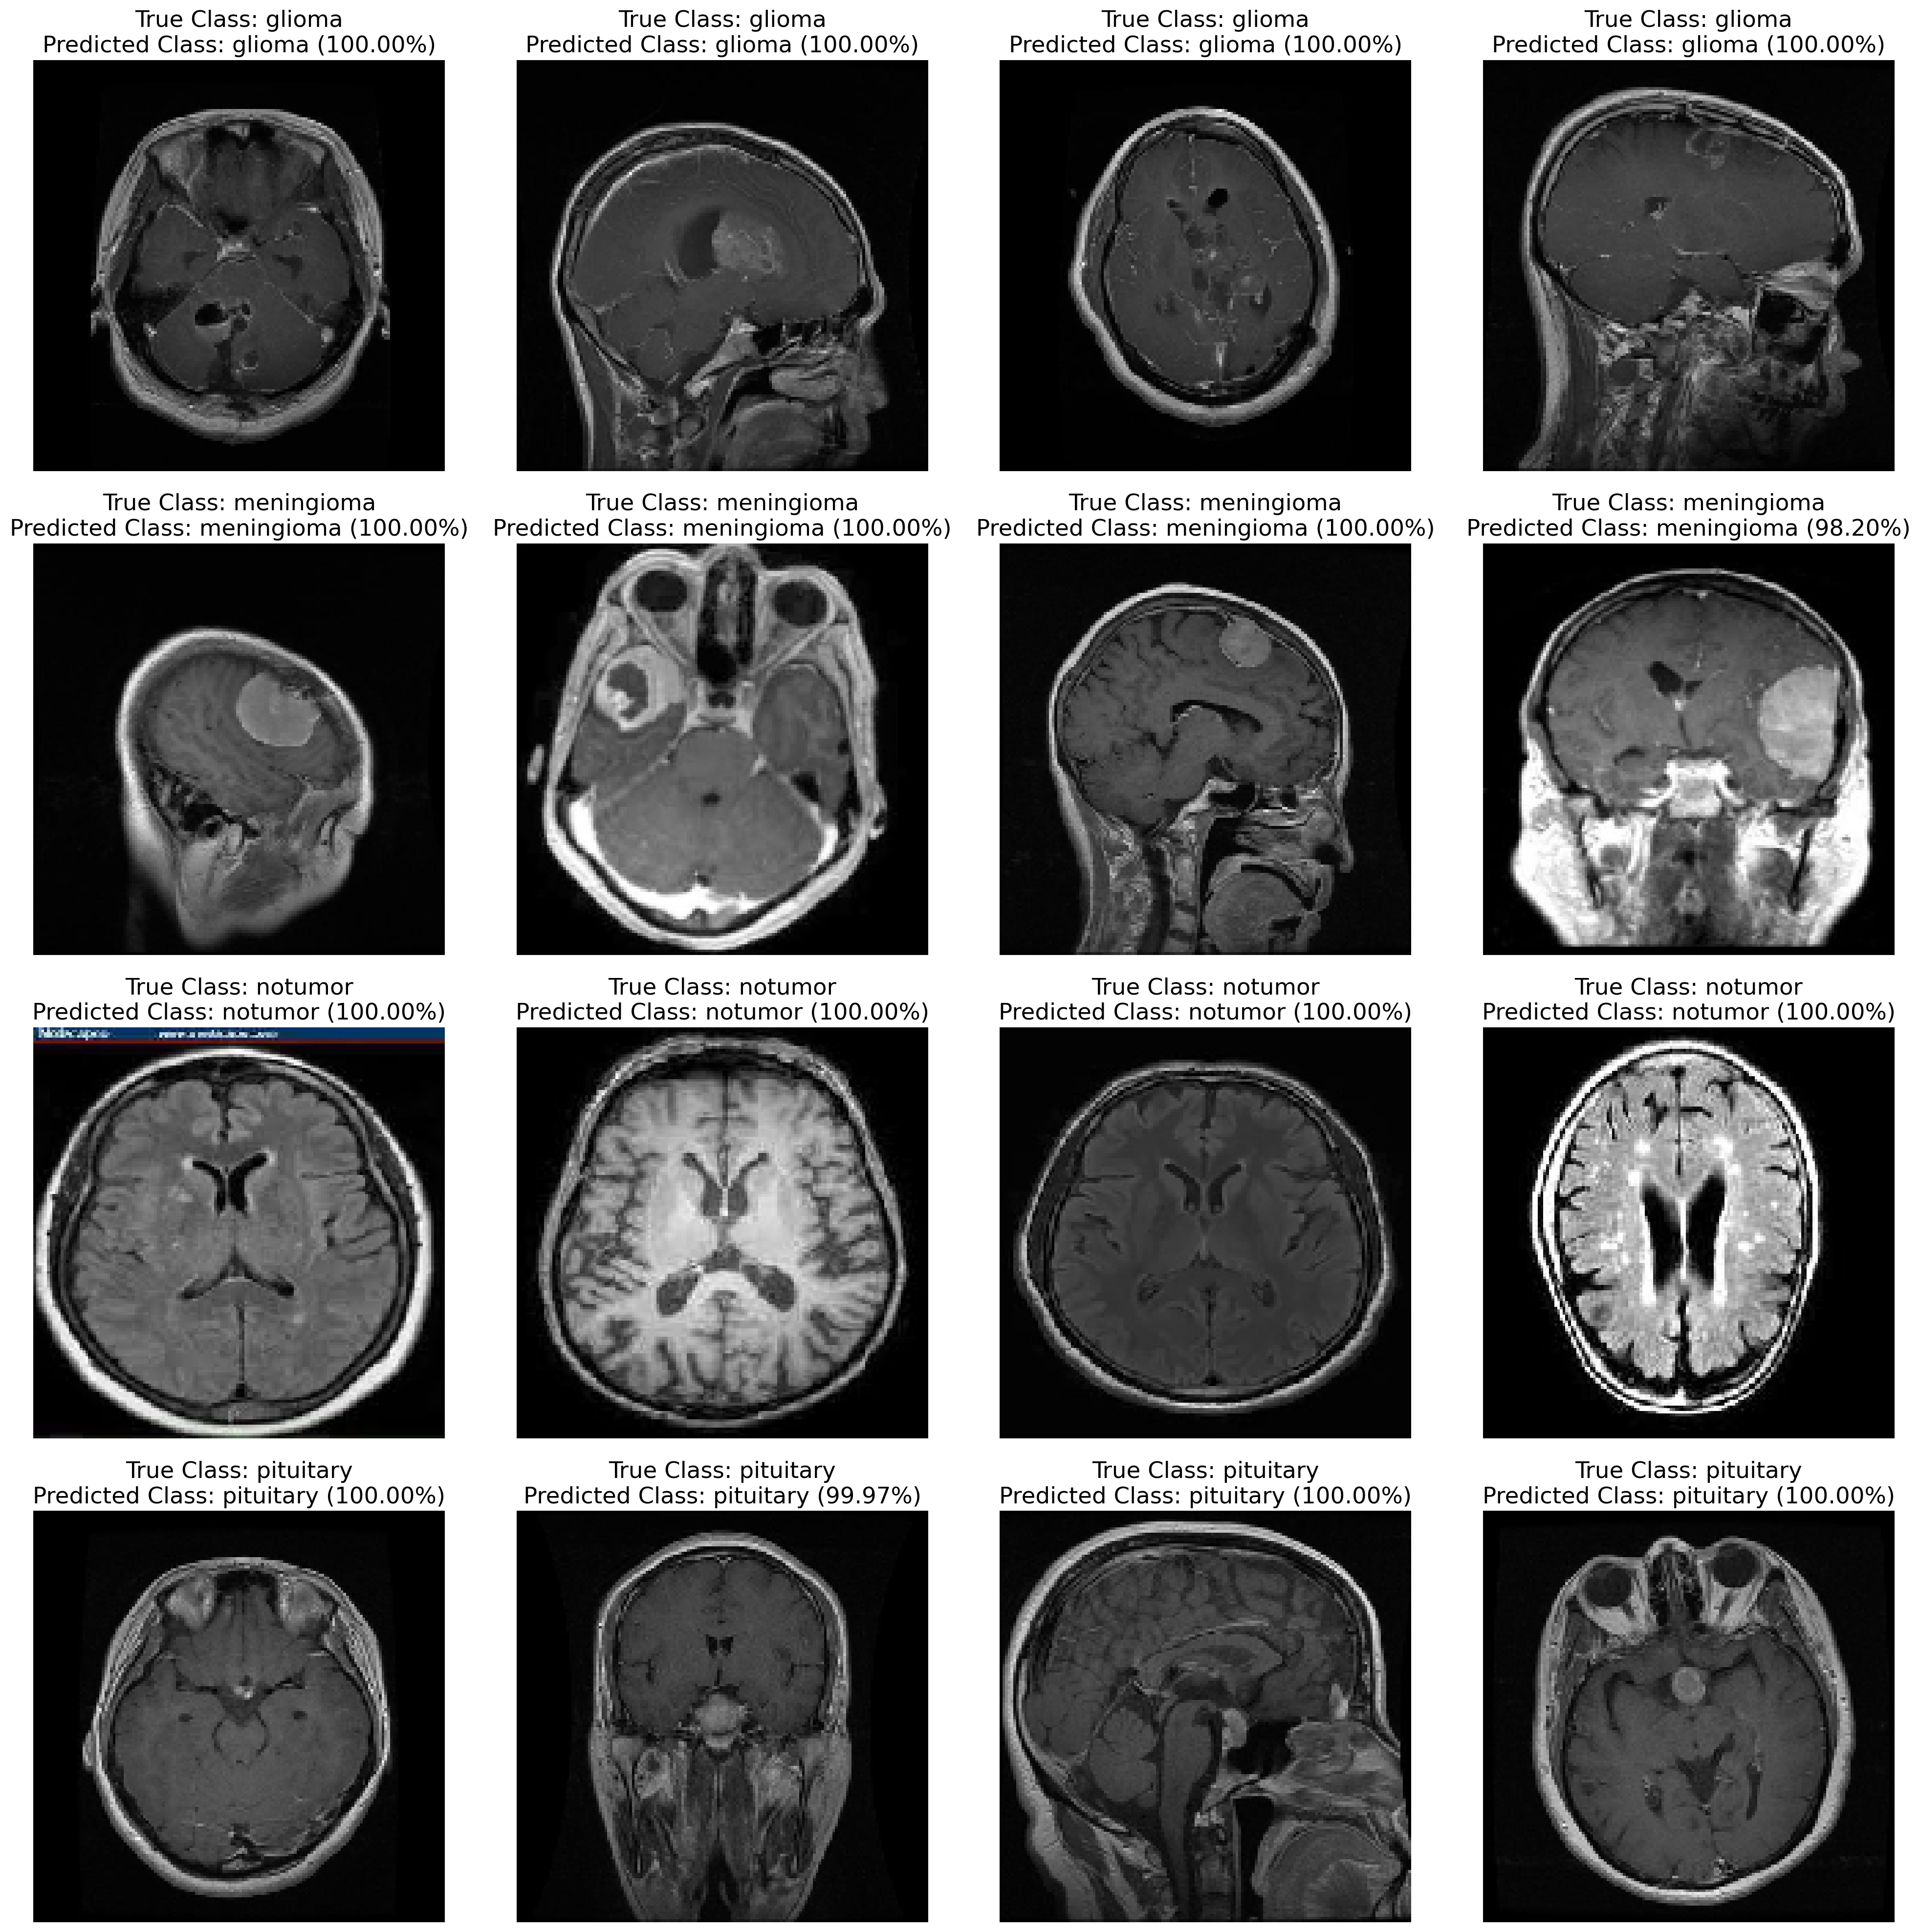

In [13]:
# Function to predict and plot 4 sample images from each class
def predict_and_plot_samples(test_path, class_names, num_samples=4):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(20, len(class_names) * 5))  # Create subplots

    for i, class_name in enumerate(class_names):
        # Get the list of images in the selected subclass
        class_dir = os.path.join(test_path, class_name)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # If there are not enough images, raise an error
        if len(images) < num_samples:
            raise ValueError(f"Not enough images found in directory {class_dir} for class {class_name}")

        # Select random images
        random_images = random.sample(images, num_samples)

        for j, random_image in enumerate(random_images):
            image_path = os.path.join(class_dir, random_image)

            # Load and preprocess the image
            img = load_img(image_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0  # Rescale to [0, 1]
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict the class
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            predicted_class_name = class_names[predicted_class]
            prediction_percentage = np.max(predictions) * 100

            # Get the true class
            true_class_index = test_generator.class_indices[class_name]
            true_class_name = class_names[true_class_index]

            # Display the image and prediction results
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"True Class: {true_class_name}\nPredicted Class: {predicted_class_name} ({prediction_percentage:.2f}%)")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Predict and display results for 4 images from each class
predict_and_plot_samples(test_dir, class_names)

In [14]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define datasets
datasets = {
    "Dataset 1": "/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset",
    "Dataset 2": "/kaggle/input/mri-brain-tumor-cleaned/brain_tumor_cleaned/Training",
    "Dataset 3": "/kaggle/input/code-to-cure/Training",
    "Dataset4": "/kaggle/input/mri-brain-tumor-classification/MRI/Training",
    "Dataset5": "/kaggle/input/brain-tumor-mri-dataset-final/Training",
}

# Function to evaluate model on a given dataset
def evaluate_on_dataset(dataset_name, dataset_path, model, image_size=(150, 150), batch_size=32):
    # Load test data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Generate classification report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=6, output_dict=True)
    accuracy = report['accuracy']
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    # Display the classification report
    print(f"\nClassification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=6))

    # Return consolidated results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Macro Average Precision": macro_avg["precision"],
        "Macro Average Recall": macro_avg["recall"],
        "Macro Average F1-Score": macro_avg["f1-score"],
        "Weighted Average Precision": weighted_avg["precision"],
        "Weighted Average Recall": weighted_avg["recall"],
        "Weighted Average F1-Score": weighted_avg["f1-score"],
    }

# Consolidate results for all datasets
results = []
for dataset_name, dataset_path in datasets.items():
    print(f"Evaluating on {dataset_name}...")
    metrics = evaluate_on_dataset(dataset_name, dataset_path, model)
    results.append(metrics)

# Save results to CSV
csv_file = "evaluation_results.csv"
csv_columns = list(results[0].keys())

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

# Display results in tabular format
df = pd.DataFrame(results)
print(df)

# Save 
df.to_csv('df64.csv', index=False)
print("DataFrame saved ")

Evaluating on Dataset 1...
Found 2175 images belonging to 4 classes.
 1/68 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step

Classification Report for Dataset 1:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000       455
  meningioma   0.998185  1.000000  0.999092       550
     notumor   1.000000  1.000000  1.000000       550
   pituitary   1.000000  0.998387  0.999193       620

    accuracy                       0.999540      2175
   macro avg   0.999546  0.999597  0.999571      2175
weighted avg   0.999541  0.999540  0.999540      2175

Evaluating on Dataset 2...
Found 5099 images belonging to 4 classes.
  2/160 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step

Classification Report for Dataset 2:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000      1321
  meningioma   0.999228  0.997689  0.998458      1298
     notumor   1.000000  1.000000  1.000000      1041
   pituitary   0.997918  0.999305  0.998611      1439

    accuracy                       0.999216      5099
   macro avg   0.999287  0.999248  0.999267      5099
weighted avg   0.999216  0.999216  0.999216      5099

Evaluating on Dataset 3...
Found 5229 images belonging to 4 classes.
  2/164 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step

Classification Report for Dataset 3:

              precision    recall  f1-score   support

      glioma   0.999178  0.999178  0.999178      1217
  meningioma   0.999172  0.996697  0.997933      1211
     notumor   0.997954  1.000000  0.998976      1463
   pituitary   0.998505  0.998505  0.998505      1338

    accuracy                       0.998661      5229
   macro avg   0.998702  0.998595  0.998648      5229
weighted avg   0.998662  0.998661  0.998661      5229

Evaluating on Dataset4...
Found 5708 images belonging to 4 classes.
  2/179 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 173ms/step

Classification Report for Dataset4:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000      1321
  meningioma   0.999252  0.997760  0.998505      1339
     notumor   1.000000  1.000000  1.000000      1591
   pituitary   0.997944  0.999314  0.998628      1457

    accuracy                       0.999299      5708
   macro avg   0.999299  0.999268  0.999283      5708
weighted avg   0.999300  0.999299  0.999299      5708

Evaluating on Dataset5...
Found 5712 images belonging to 4 classes.
  2/179 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step

Classification Report for Dataset5:

                  precision    recall  f1-score   support

    glioma_tumor   1.000000  1.000000  1.000000      1321
meningioma_tumor   0.999252  0.997760  0.998505      1339
        no_tumor   1.000000  1.000000  1.000000      1595
 pituitary_tumor   0.997944  0.999314  0.998628      1457

        accuracy                       0.999300      5712
       macro avg   0.999299  0.999268  0.999283      5712
    weighted avg   0.999300  0.999300  0.999300      5712

     Dataset  Accuracy  Macro Average Precision  Macro Average Recall  \
0  Dataset 1  0.999540                 0.999546              0.999597   
1  Dataset 2  0.999216                 0.999287              0.999248   
2  Dataset 3  0.998661                 0.998702              0.998595   
3   Dataset4  0.999299                 0.999299              0.999268   
4   Dataset5  0.999300                 0.999299              0.999268   

   Macro Ave

# Training batch size = 128

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_18 has kernel size: (4, 4)
Layer conv2d_19 has kernel size: (4, 4)
Layer conv2d_20 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 44/178 ━━━━━━━━━━━━━━━━━━━━ 1:46 792ms/step - accuracy: 0.4308 - loss: 1.1617

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 50s 213ms/step - accuracy: 0.5343 - loss: 1.0073 - val_accuracy: 0.6827 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.7494 - loss: 0.6231 - val_accuracy: 0.6598 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.7885 - loss: 0.5207 - val_accuracy: 0.7201 - val_loss: 0.7124 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.8181 - loss: 0.4604 - val_accuracy: 0.7361 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.8540 - loss: 0.3818 - val_accuracy: 0.7857 - val_loss: 0.5074 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.8618 - loss: 0.3674 - val_accuracy: 0.8131 - val_loss: 0.4893 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.8877 - loss:

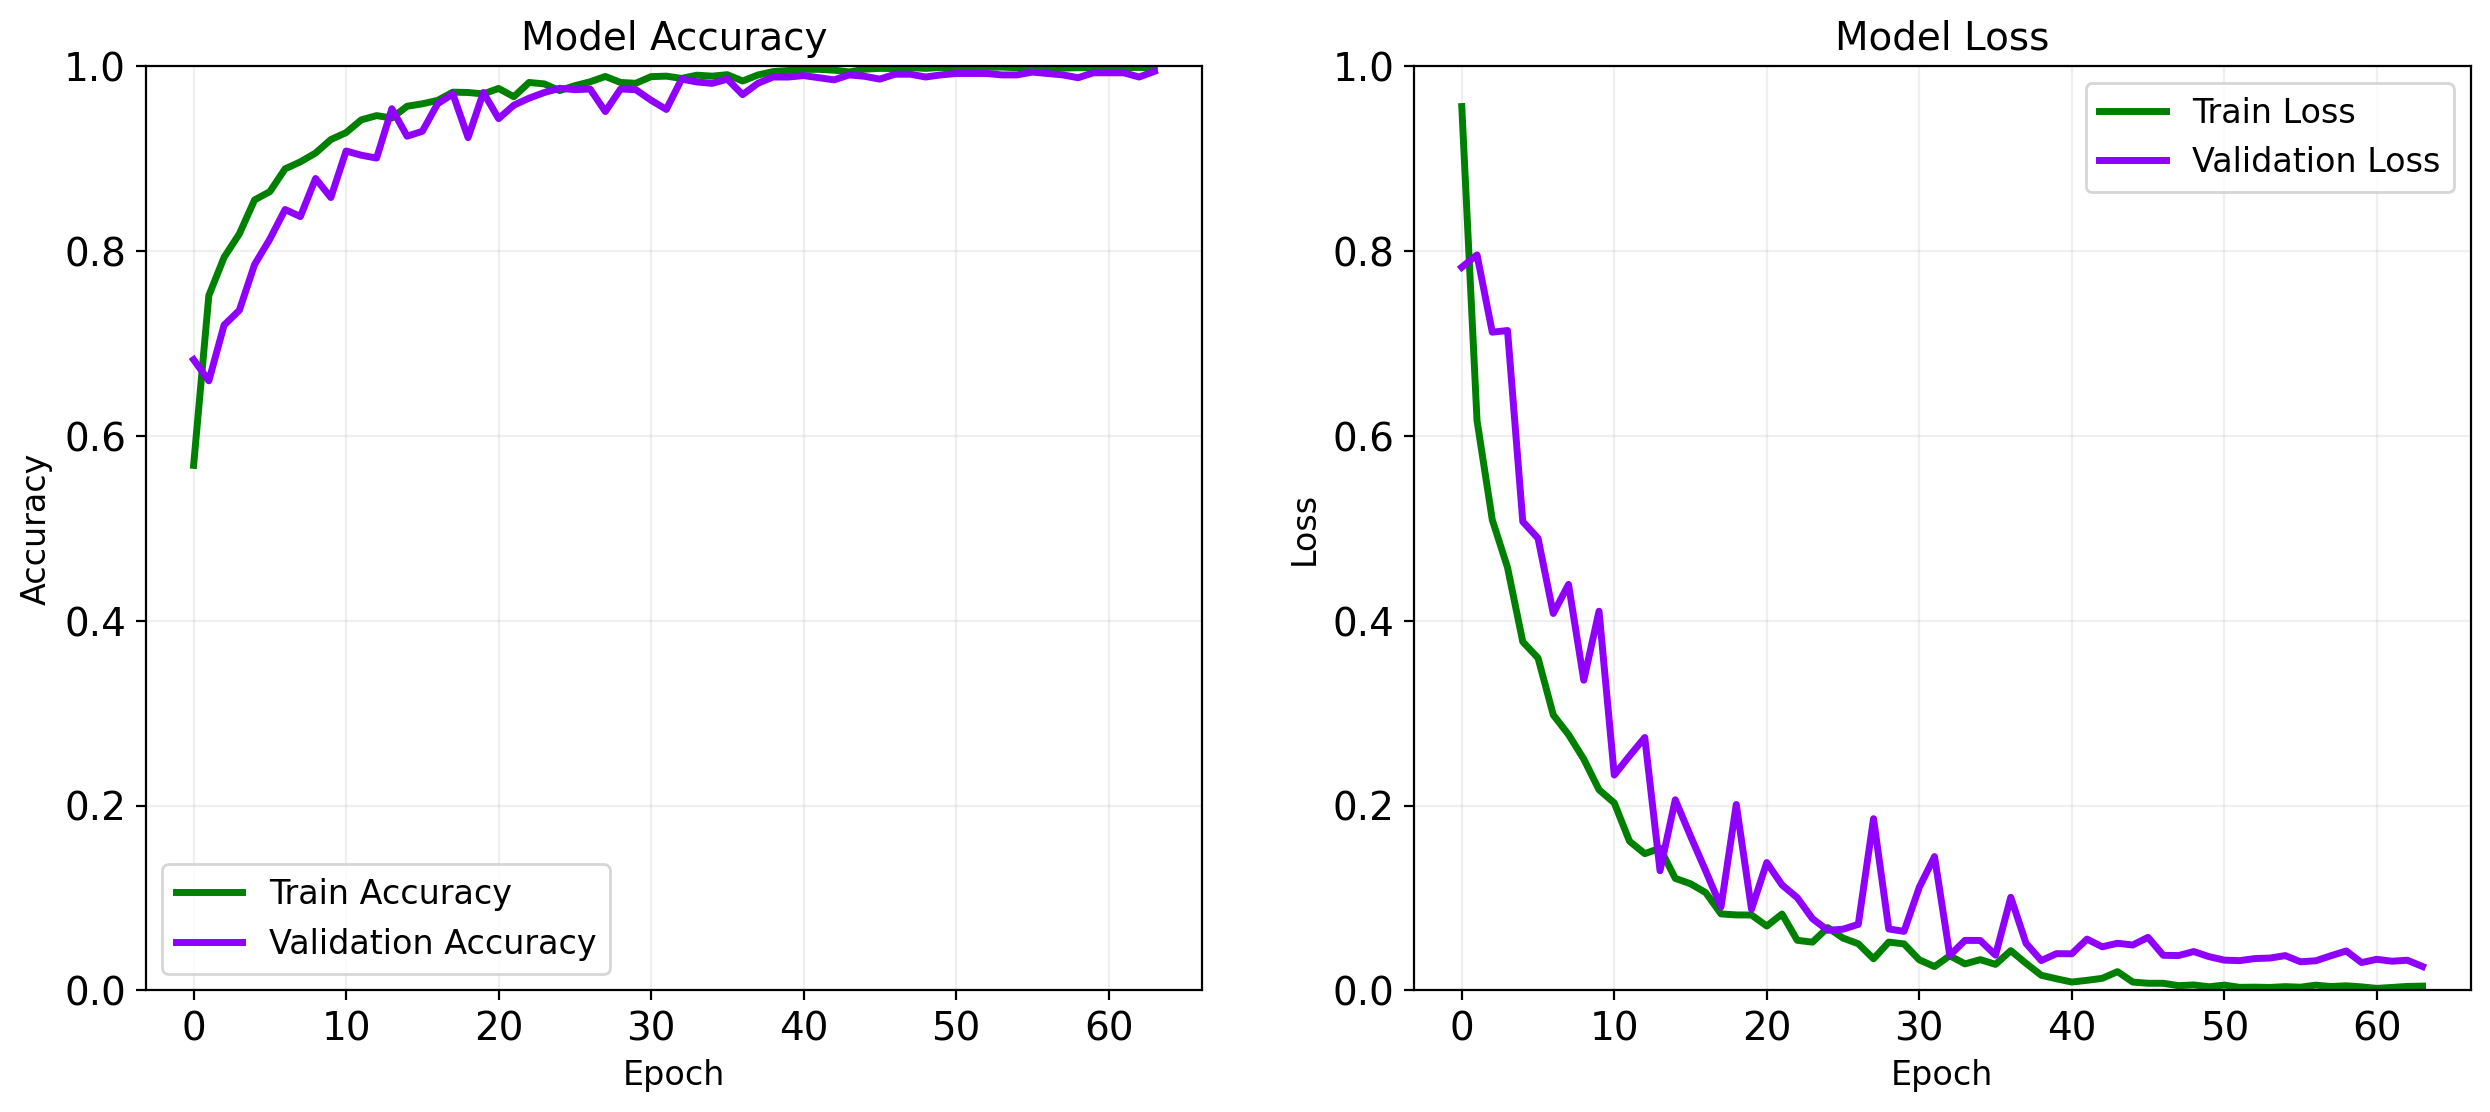

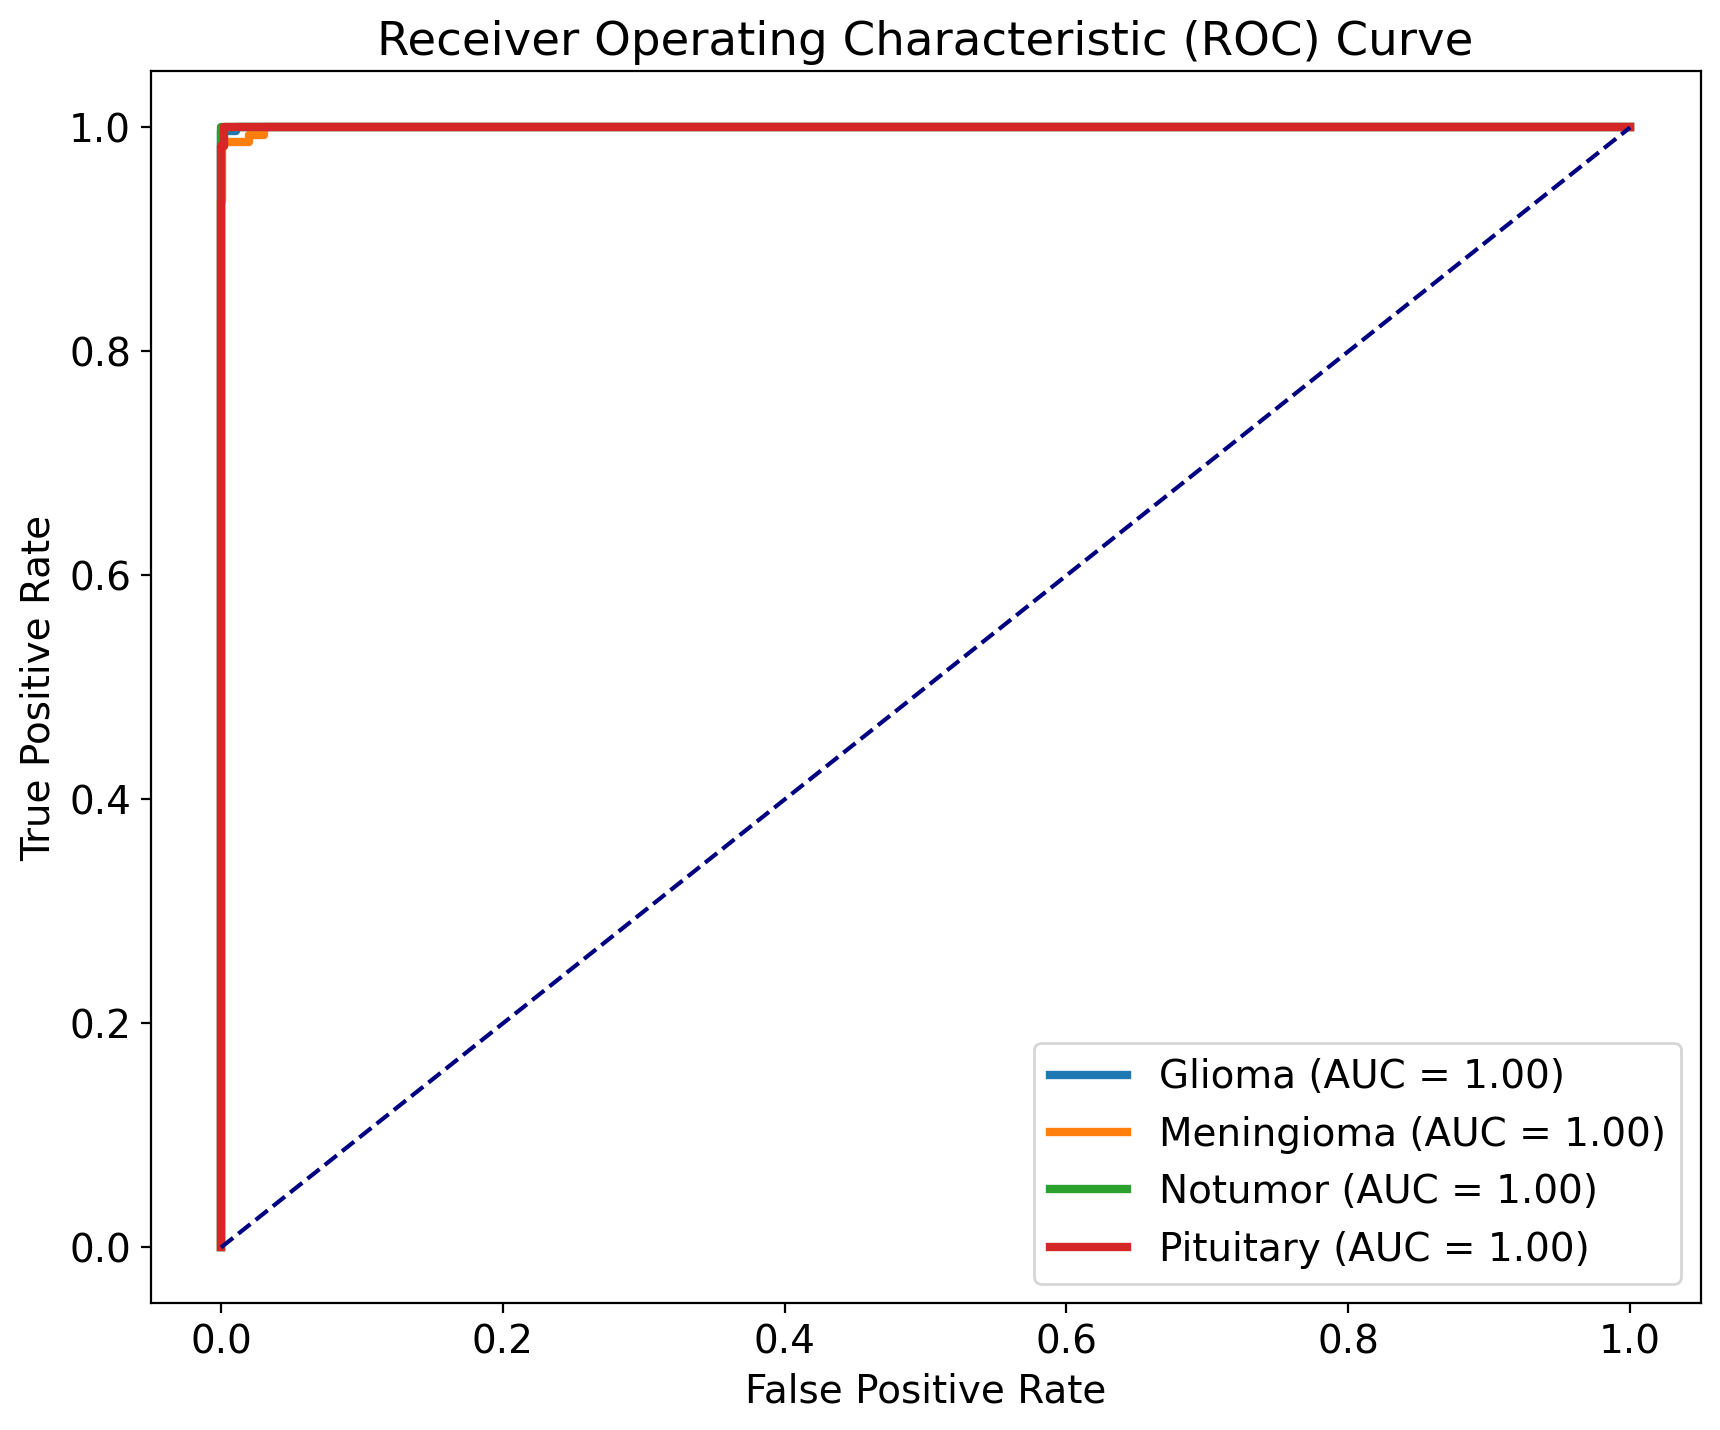

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step


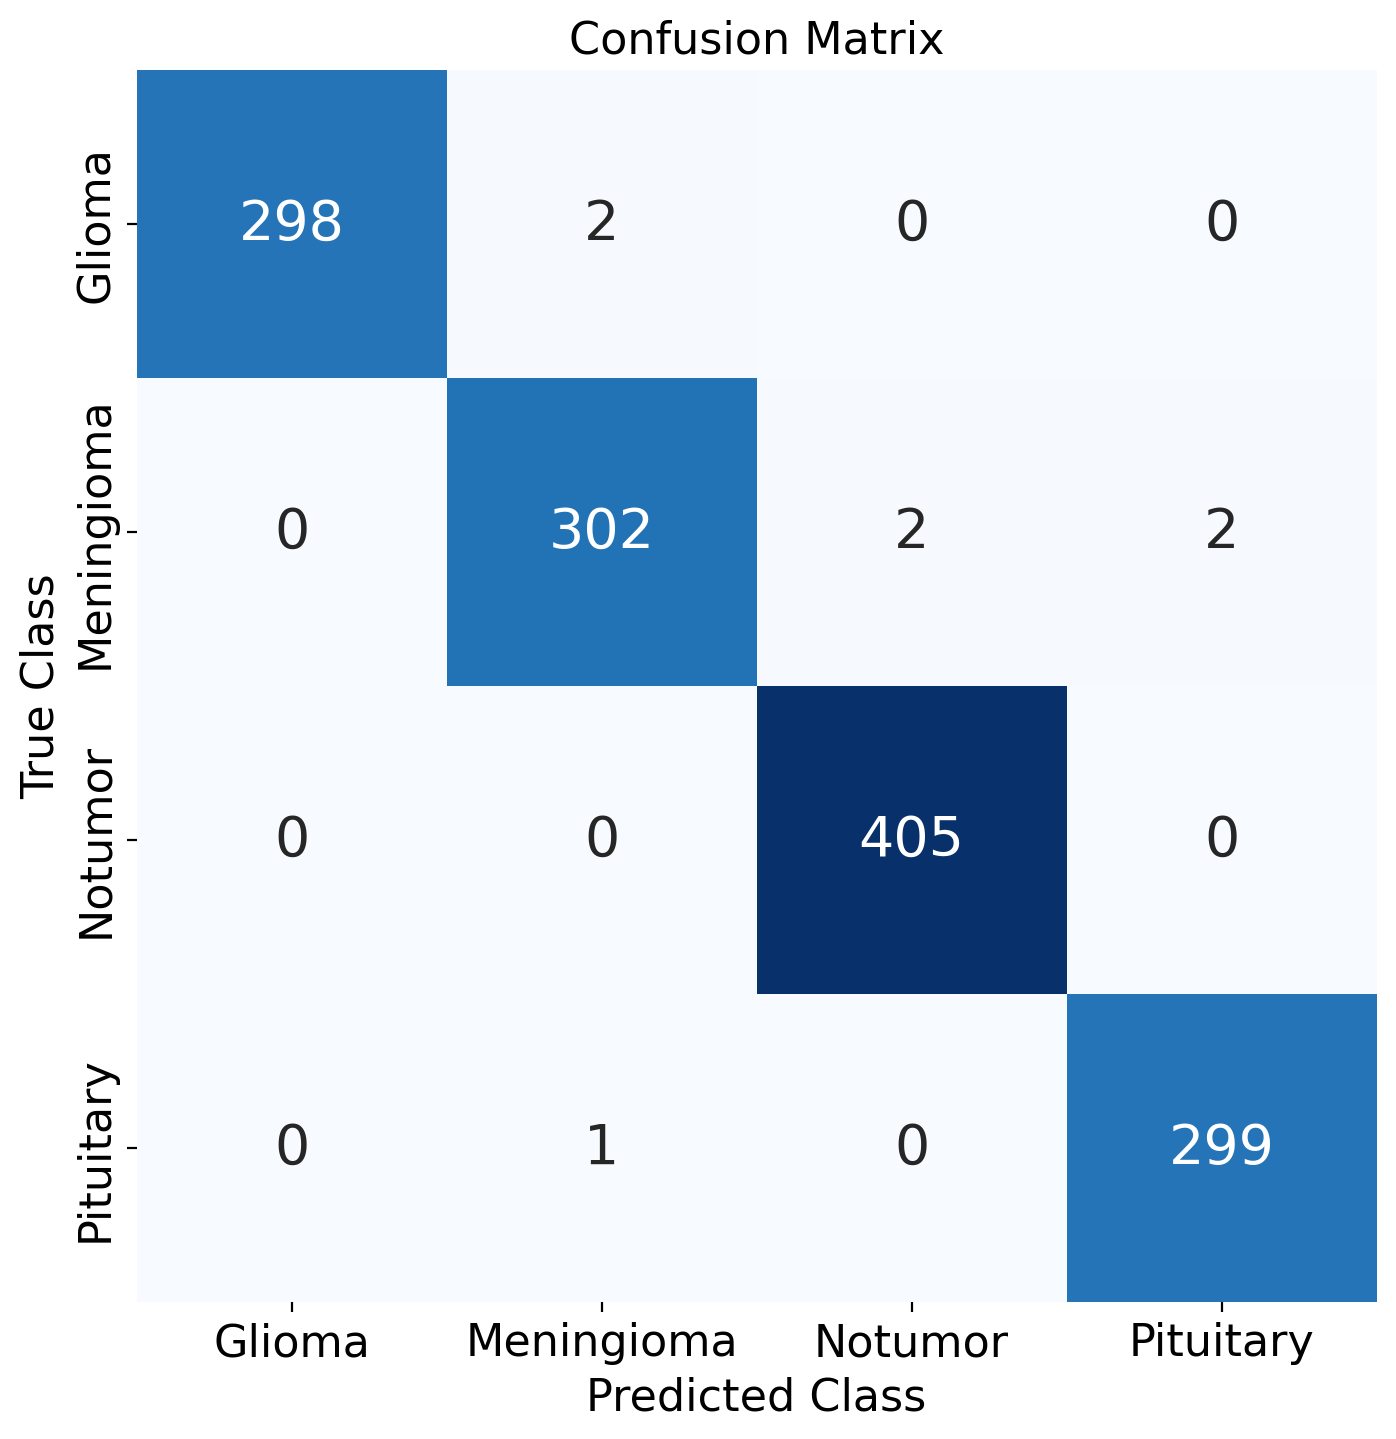

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   1.000000  0.993333  0.996656       300
  Meningioma   0.990164  0.986928  0.988543       306
     Notumor   0.995086  1.000000  0.997537       405
   Pituitary   0.993355  0.996667  0.995008       300

    accuracy                       0.994661      1311
   macro avg   0.994651  0.994232  0.994436      1311
weighted avg   0.994666  0.994661  0.994657      1311

Model saved in HDF5 format to /kaggle/working/model_128.h5


In [15]:
# Training batch size
batch_size = 128
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_128.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


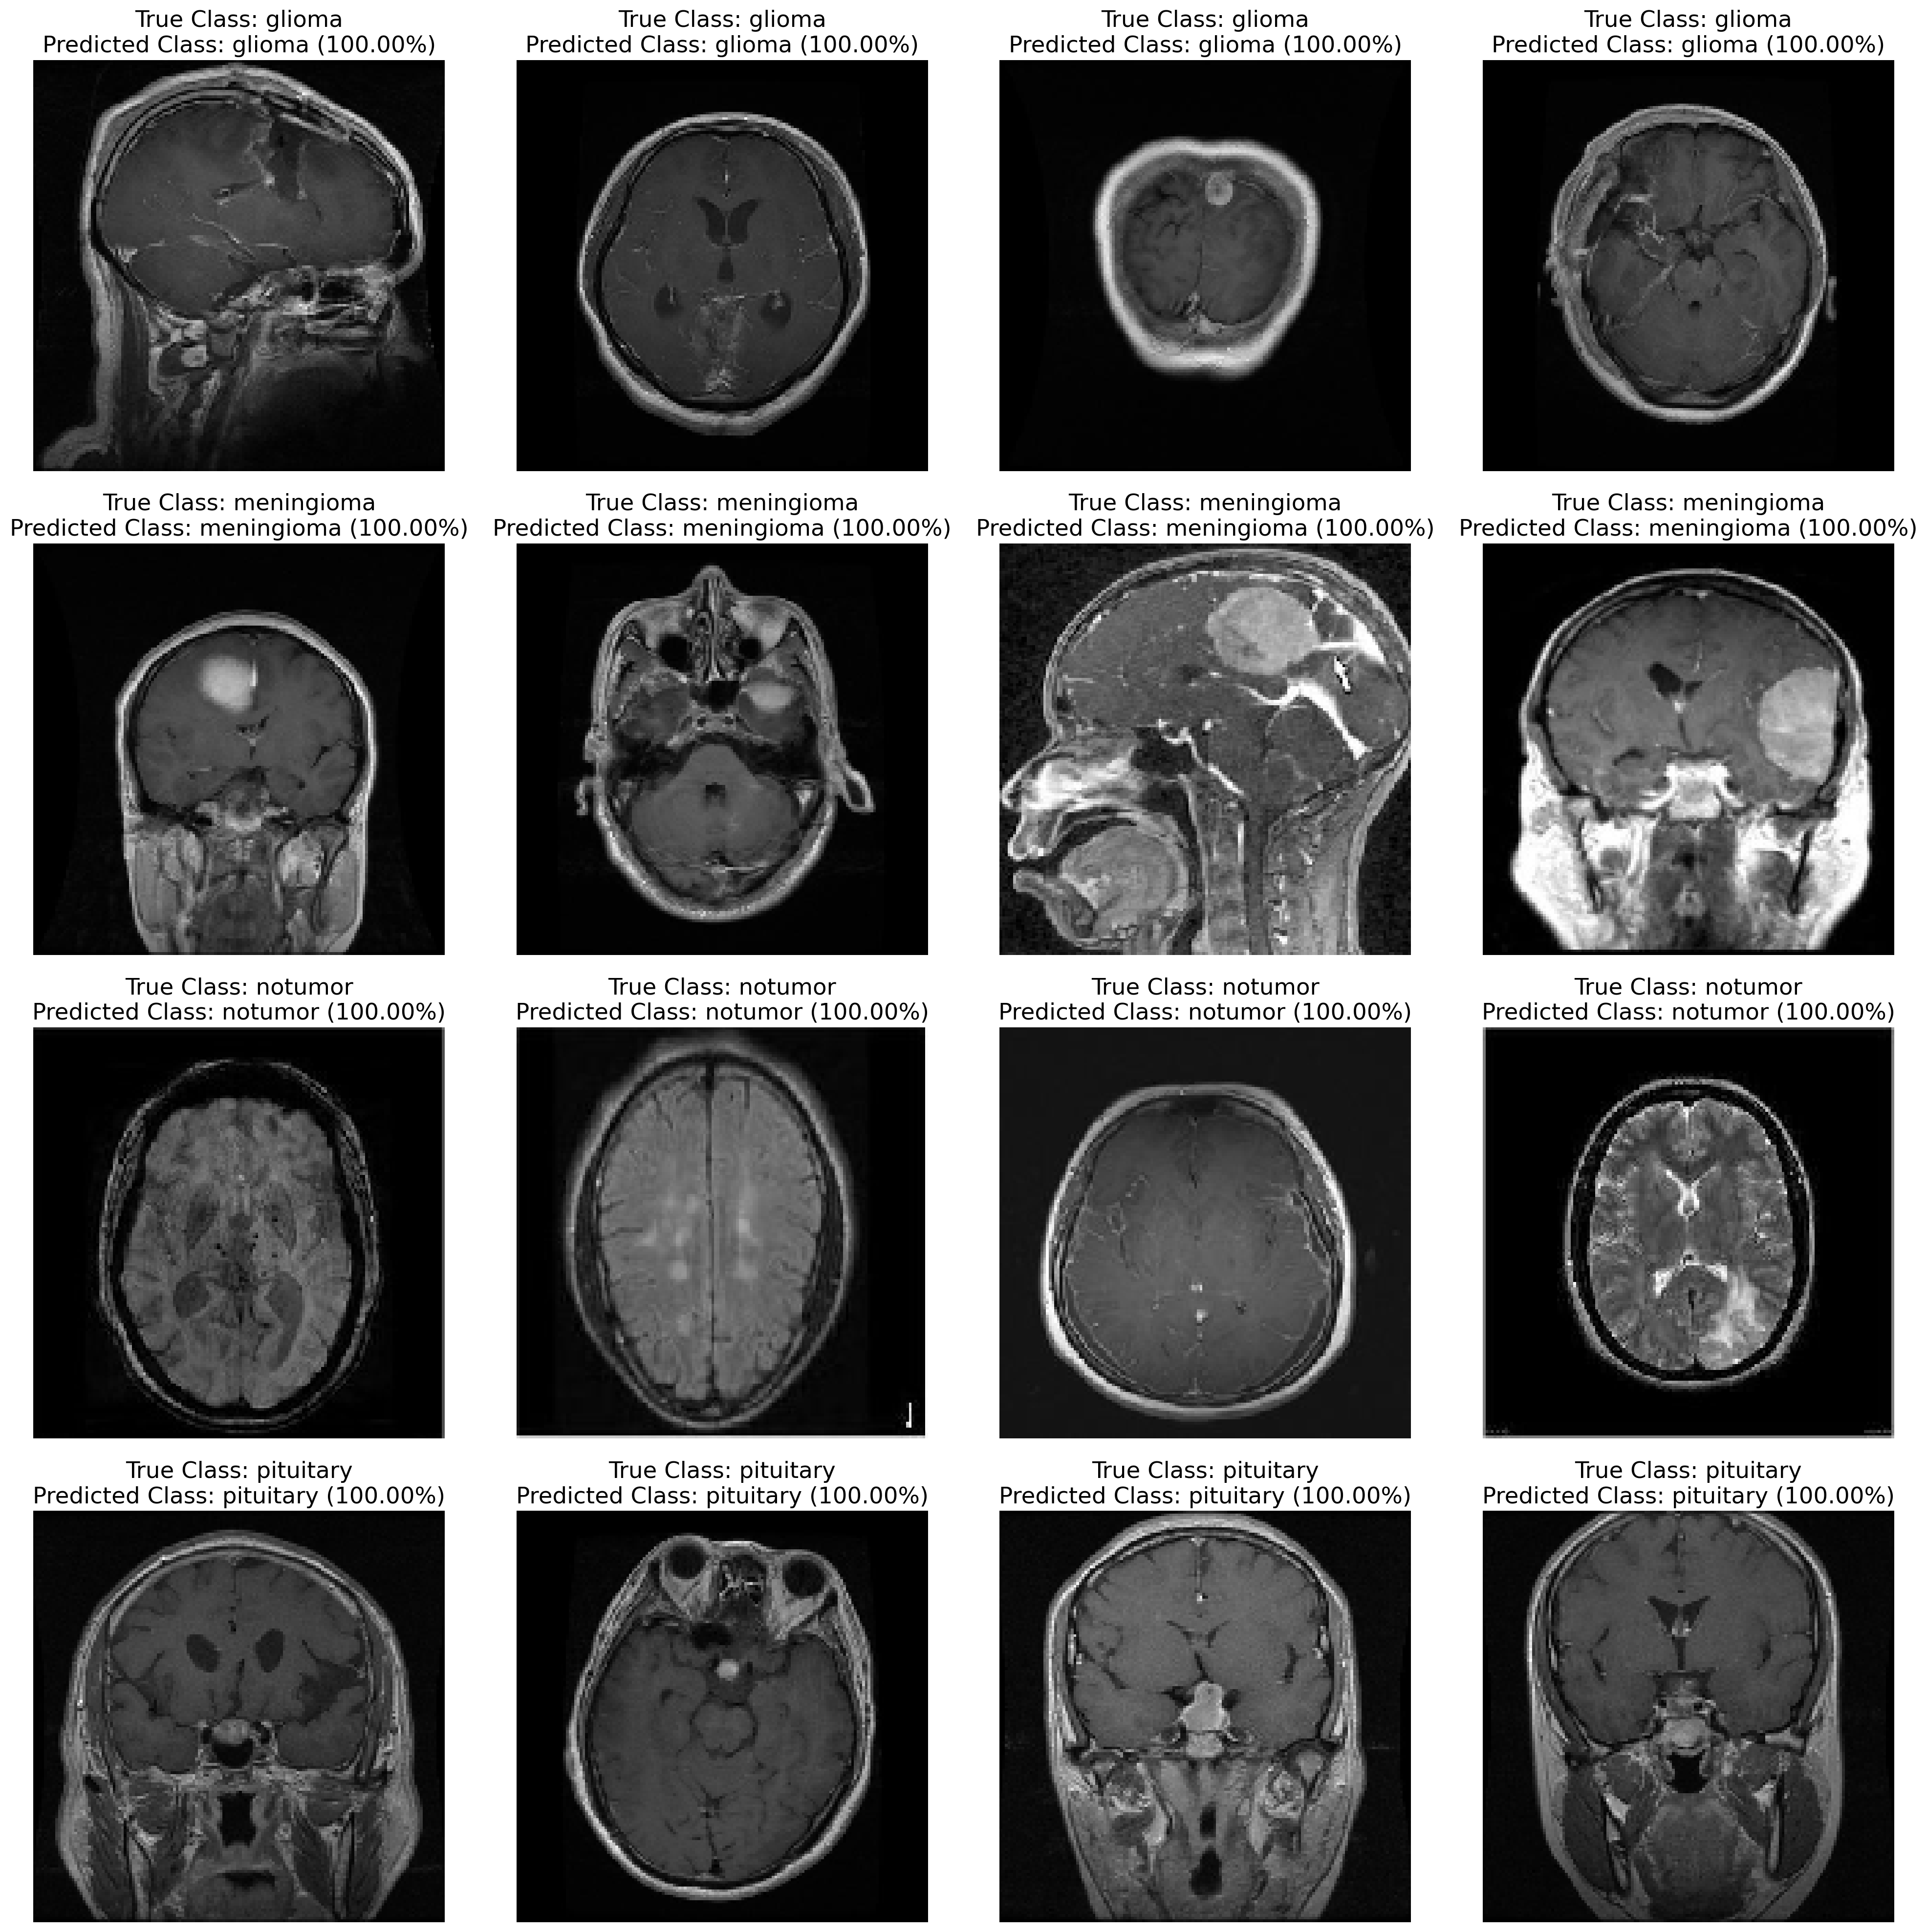

In [16]:
# Function to predict and plot 4 sample images from each class
def predict_and_plot_samples(test_path, class_names, num_samples=4):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(20, len(class_names) * 5))  # Create subplots

    for i, class_name in enumerate(class_names):
        # Get the list of images in the selected subclass
        class_dir = os.path.join(test_path, class_name)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # If there are not enough images, raise an error
        if len(images) < num_samples:
            raise ValueError(f"Not enough images found in directory {class_dir} for class {class_name}")

        # Select random images
        random_images = random.sample(images, num_samples)

        for j, random_image in enumerate(random_images):
            image_path = os.path.join(class_dir, random_image)

            # Load and preprocess the image
            img = load_img(image_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0  # Rescale to [0, 1]
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict the class
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            predicted_class_name = class_names[predicted_class]
            prediction_percentage = np.max(predictions) * 100

            # Get the true class
            true_class_index = test_generator.class_indices[class_name]
            true_class_name = class_names[true_class_index]

            # Display the image and prediction results
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"True Class: {true_class_name}\nPredicted Class: {predicted_class_name} ({prediction_percentage:.2f}%)")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Predict and display results for 4 images from each class
predict_and_plot_samples(test_dir, class_names)

In [17]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define datasets
datasets = {
    "Dataset 1": "/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset",
    "Dataset 2": "/kaggle/input/mri-brain-tumor-cleaned/brain_tumor_cleaned/Training",
    "Dataset 3": "/kaggle/input/code-to-cure/Training",
    "Dataset 4": "/kaggle/input/mri-brain-tumor-classification/MRI/Training",
    "Dataset 5": "/kaggle/input/brain-tumor-mri-dataset-final/Training",
}

# Function to evaluate model on a given dataset
def evaluate_on_dataset(dataset_name, dataset_path, model, image_size=(150, 150), batch_size=32):
    # Load test data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Generate classification report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=6, output_dict=True)
    accuracy = report['accuracy']
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    # Display the classification report
    print(f"\nClassification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=6))

    # Return consolidated results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Macro Average Precision": macro_avg["precision"],
        "Macro Average Recall": macro_avg["recall"],
        "Macro Average F1-Score": macro_avg["f1-score"],
        "Weighted Average Precision": weighted_avg["precision"],
        "Weighted Average Recall": weighted_avg["recall"],
        "Weighted Average F1-Score": weighted_avg["f1-score"],
    }

# Consolidate results for all datasets
results = []
for dataset_name, dataset_path in datasets.items():
    print(f"Evaluating on {dataset_name}...")
    metrics = evaluate_on_dataset(dataset_name, dataset_path, model)
    results.append(metrics)

# Save results to CSV
csv_file = "evaluation_results.csv"
csv_columns = list(results[0].keys())

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

# Display results in tabular format
df = pd.DataFrame(results)
print(df)

# Save 
df.to_csv('df128.csv', index=False)
print("DataFrame saved ")

Evaluating on Dataset 1...
Found 2175 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step

Classification Report for Dataset 1:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000       455
  meningioma   0.998185  1.000000  0.999092       550
     notumor   1.000000  1.000000  1.000000       550
   pituitary   1.000000  0.998387  0.999193       620

    accuracy                       0.999540      2175
   macro avg   0.999546  0.999597  0.999571      2175
weighted avg   0.999541  0.999540  0.999540      2175

Evaluating on Dataset 2...
Found 5099 images belonging to 4 classes.
  2/160 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step

Classification Report for Dataset 2:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000      1321
  meningioma   0.999230  0.999230  0.999230      1298
     notumor   1.000000  1.000000  1.000000      1041
   pituitary   0.999305  0.999305  0.999305      1439

    accuracy                       0.999608      5099
   macro avg   0.999634  0.999634  0.999634      5099
weighted avg   0.999608  0.999608  0.999608      5099

Evaluating on Dataset 3...
Found 5229 images belonging to 4 classes.
  2/164 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step

Classification Report for Dataset 3:

              precision    recall  f1-score   support

      glioma   0.993464  0.999178  0.996313      1217
  meningioma   0.999168  0.991742  0.995441      1211
     notumor   0.998635  1.000000  0.999317      1463
   pituitary   0.999253  0.999253  0.999253      1338

    accuracy                       0.997705      5229
   macro avg   0.997630  0.997543  0.997581      5229
weighted avg   0.997713  0.997705  0.997704      5229

Evaluating on Dataset 4...
Found 5708 images belonging to 4 classes.
  3/179 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step

Classification Report for Dataset 4:

              precision    recall  f1-score   support

      glioma   1.000000  1.000000  1.000000      1321
  meningioma   0.999253  0.999253  0.999253      1339
     notumor   1.000000  1.000000  1.000000      1591
   pituitary   0.999314  0.999314  0.999314      1457

    accuracy                       0.999650      5708
   macro avg   0.999642  0.999642  0.999642      5708
weighted avg   0.999650  0.999650  0.999650      5708

Evaluating on Dataset 5...
Found 5712 images belonging to 4 classes.
  2/179 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step

Classification Report for Dataset 5:

                  precision    recall  f1-score   support

    glioma_tumor   1.000000  1.000000  1.000000      1321
meningioma_tumor   0.999253  0.999253  0.999253      1339
        no_tumor   1.000000  1.000000  1.000000      1595
 pituitary_tumor   0.999314  0.999314  0.999314      1457

        accuracy                       0.999650      5712
       macro avg   0.999642  0.999642  0.999642      5712
    weighted avg   0.999650  0.999650  0.999650      5712

     Dataset  Accuracy  Macro Average Precision  Macro Average Recall  \
0  Dataset 1  0.999540                 0.999546              0.999597   
1  Dataset 2  0.999608                 0.999634              0.999634   
2  Dataset 3  0.997705                 0.997630              0.997543   
3  Dataset 4  0.999650                 0.999642              0.999642   
4  Dataset 5  0.999650                 0.999642              0.999642   

   Macro Ave

# Training batch size = 256

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Layer conv2d_21 has kernel size: (4, 4)
Layer conv2d_22 has kernel size: (4, 4)
Layer conv2d_23 has kernel size: (4, 4)
Epoch 1/64


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 23/178 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.3641 - loss: 1.3030

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.4466 - loss: 1.1755 - val_accuracy: 0.5454 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 2/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.6911 - loss: 0.7412 - val_accuracy: 0.7109 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 3/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.7523 - loss: 0.6221 - val_accuracy: 0.7086 - val_loss: 0.7859 - learning_rate: 0.0010
Epoch 4/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - accuracy: 0.7869 - loss: 0.5365 - val_accuracy: 0.7376 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 5/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.8189 - loss: 0.4534 - val_accuracy: 0.8070 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 6/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.8096 - loss: 0.4600 - val_accuracy: 0.7300 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 7/64
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.8486 - loss:

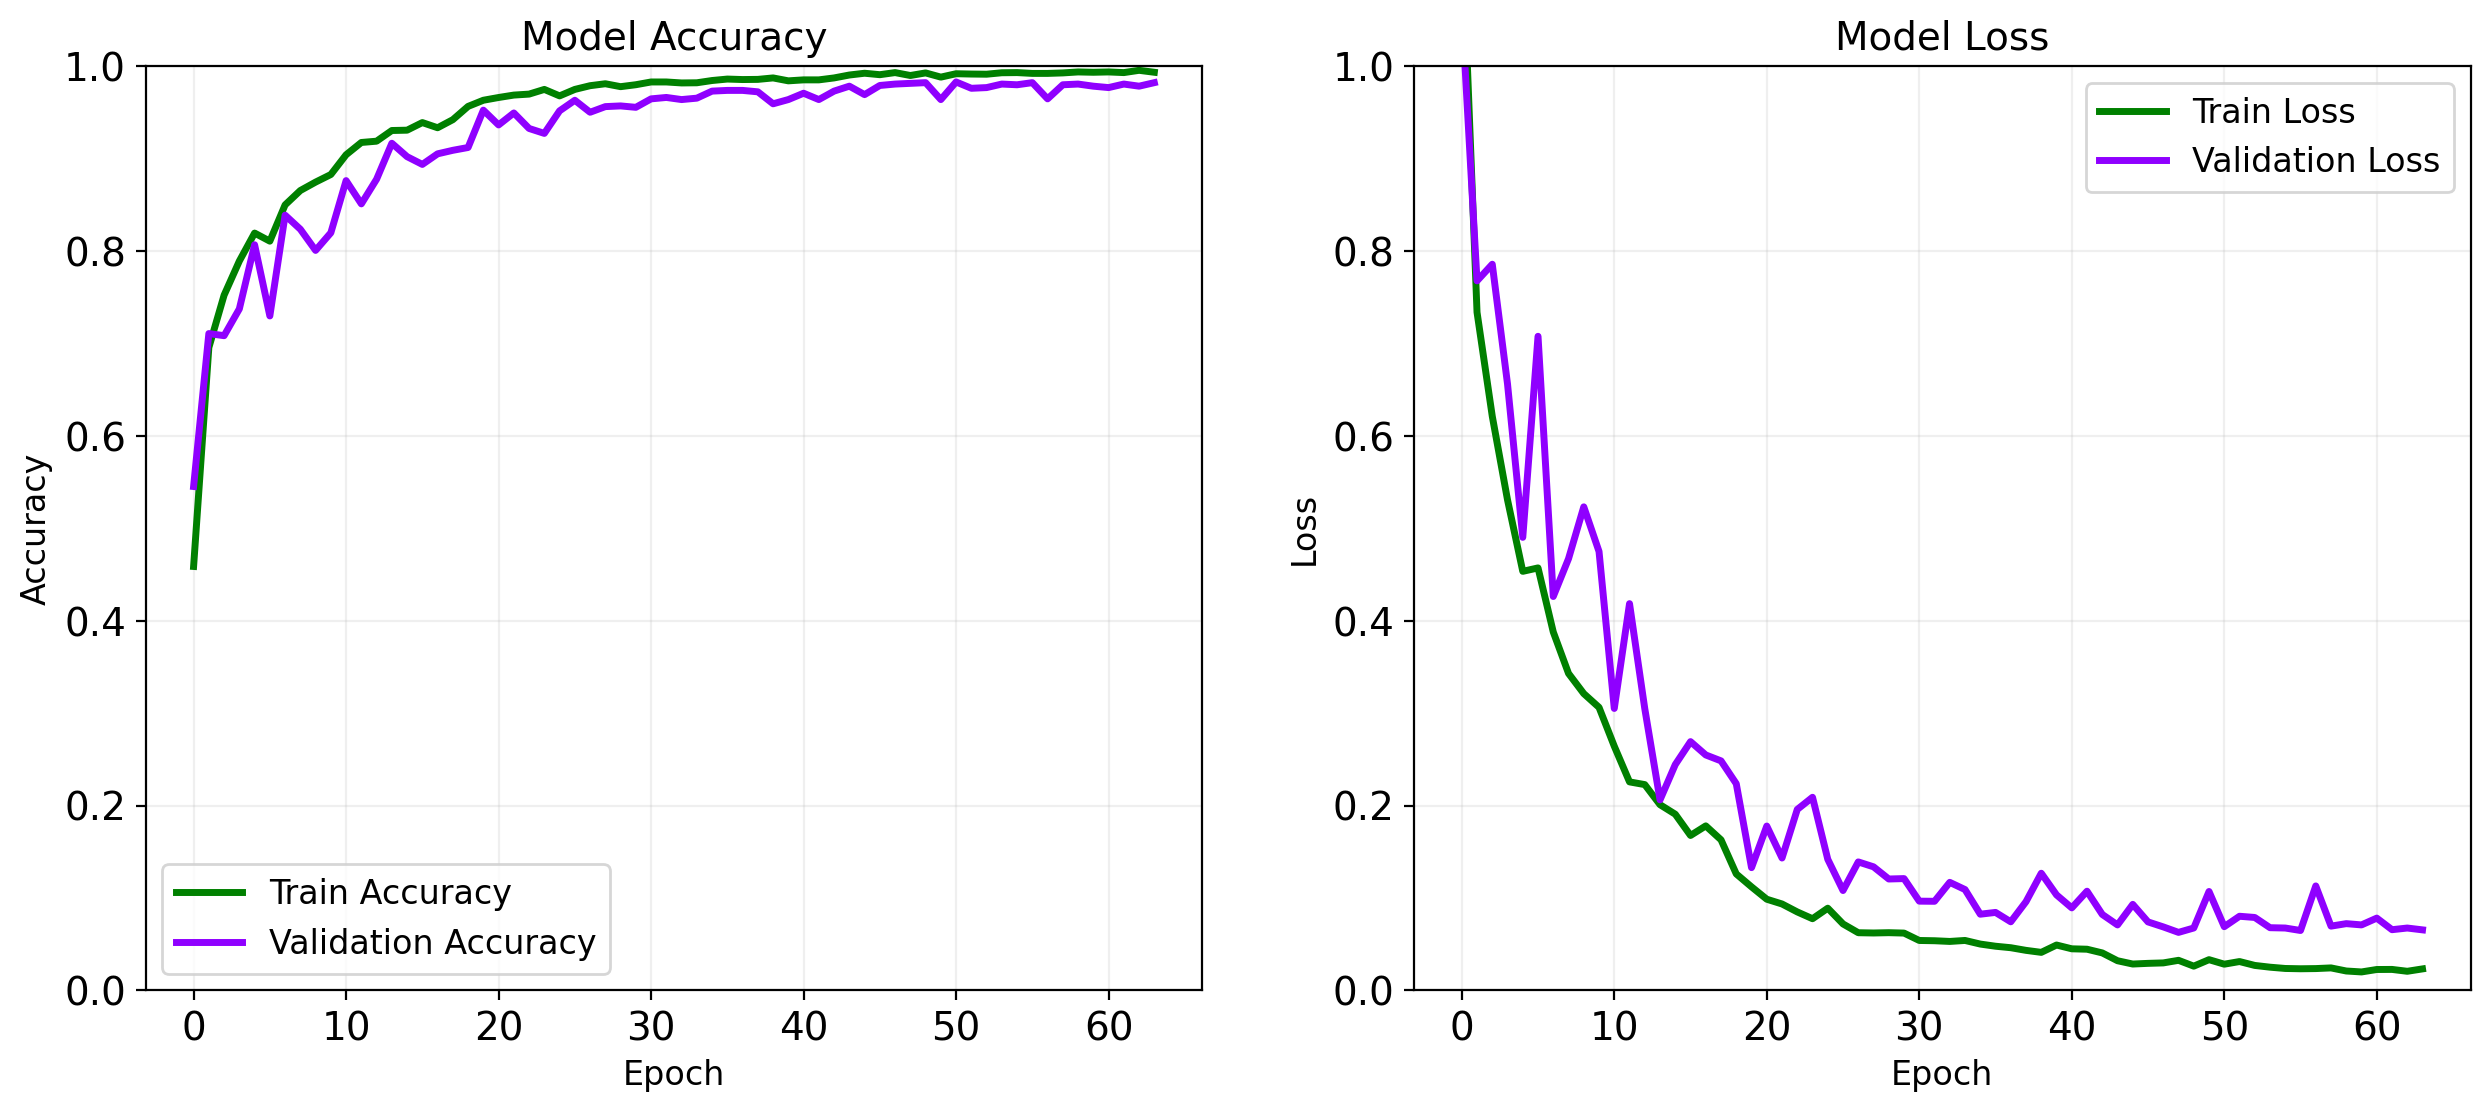

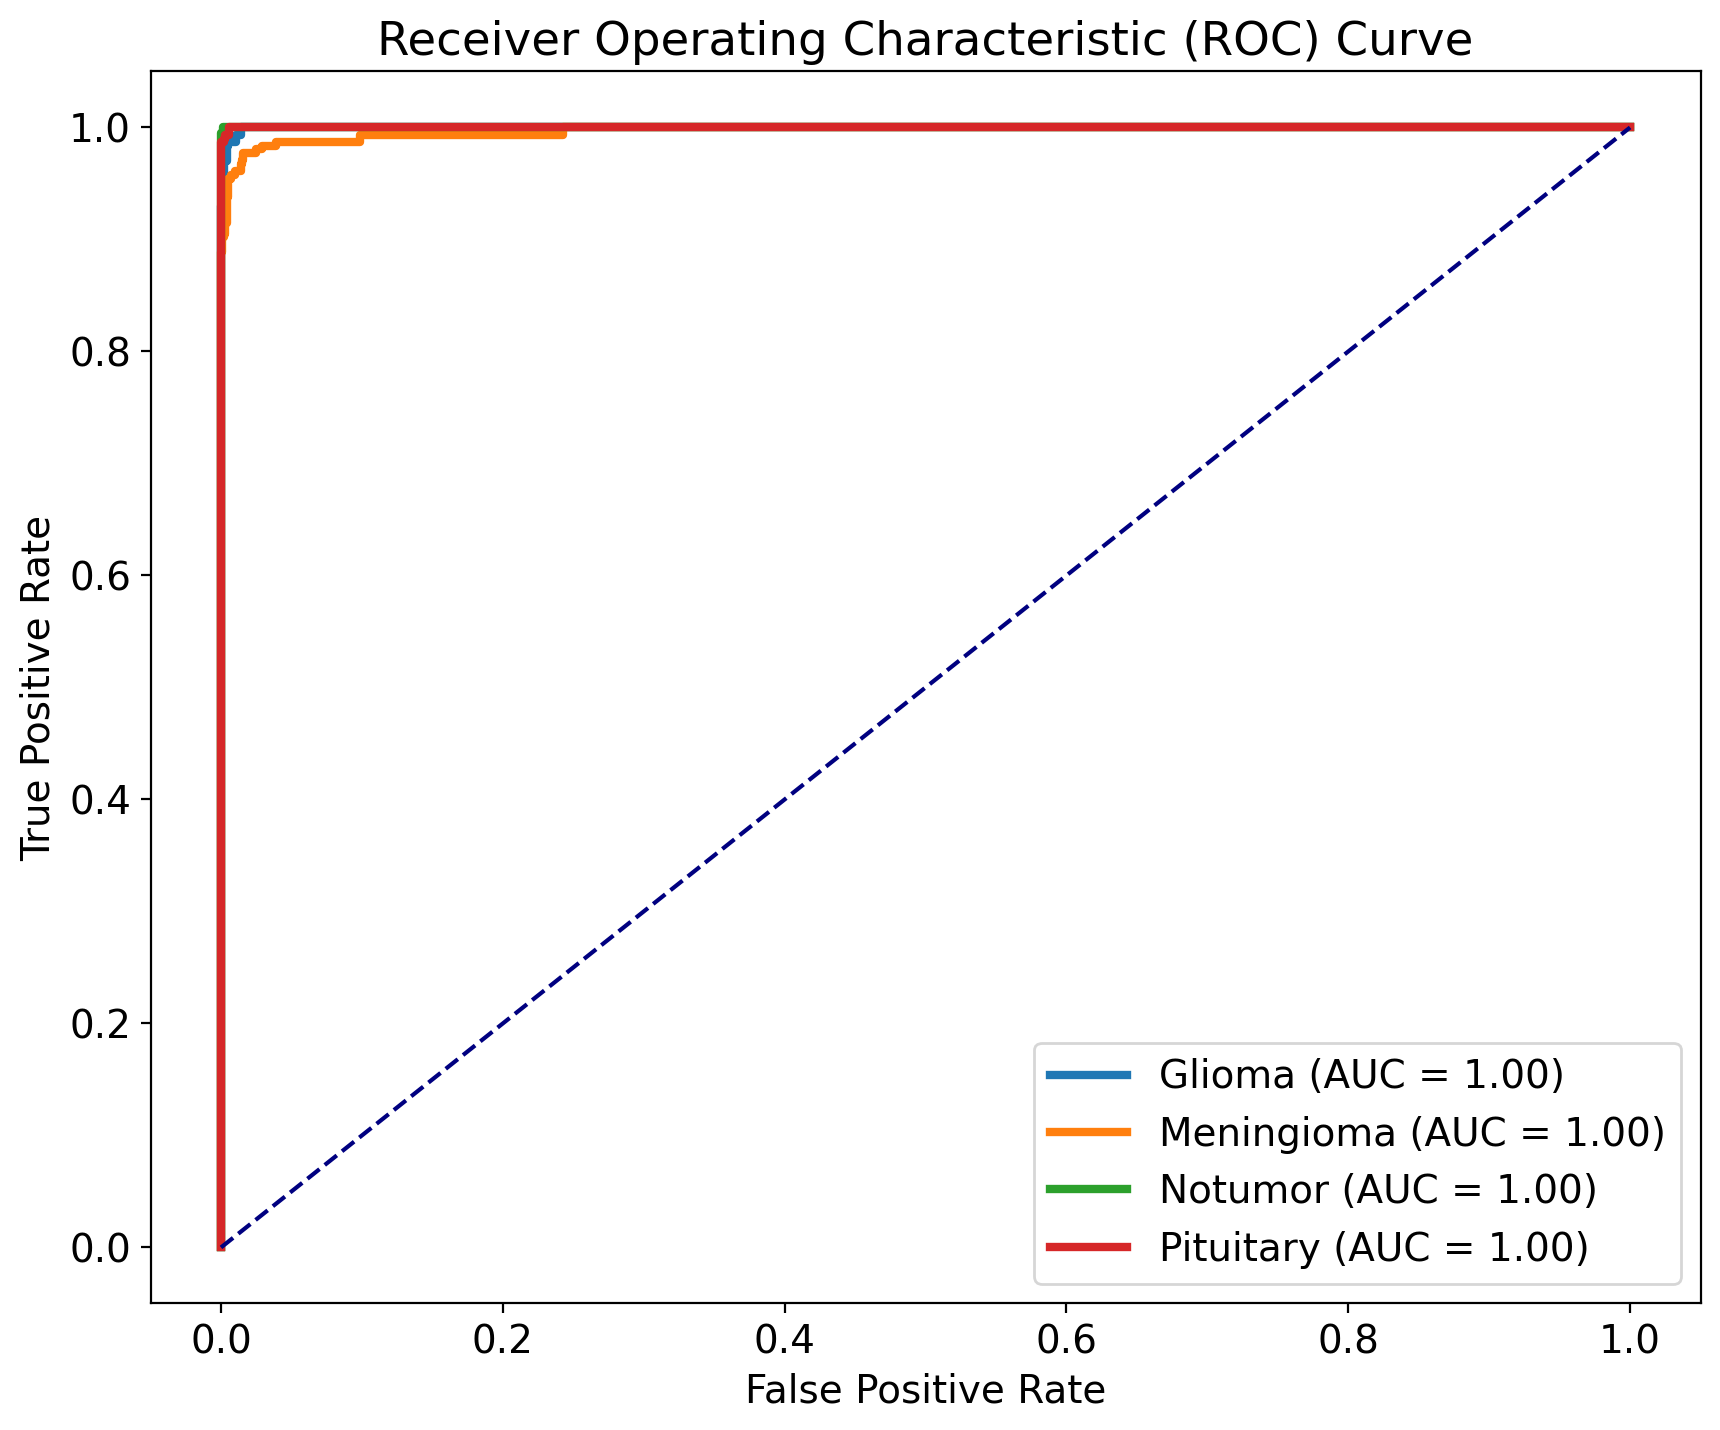

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step


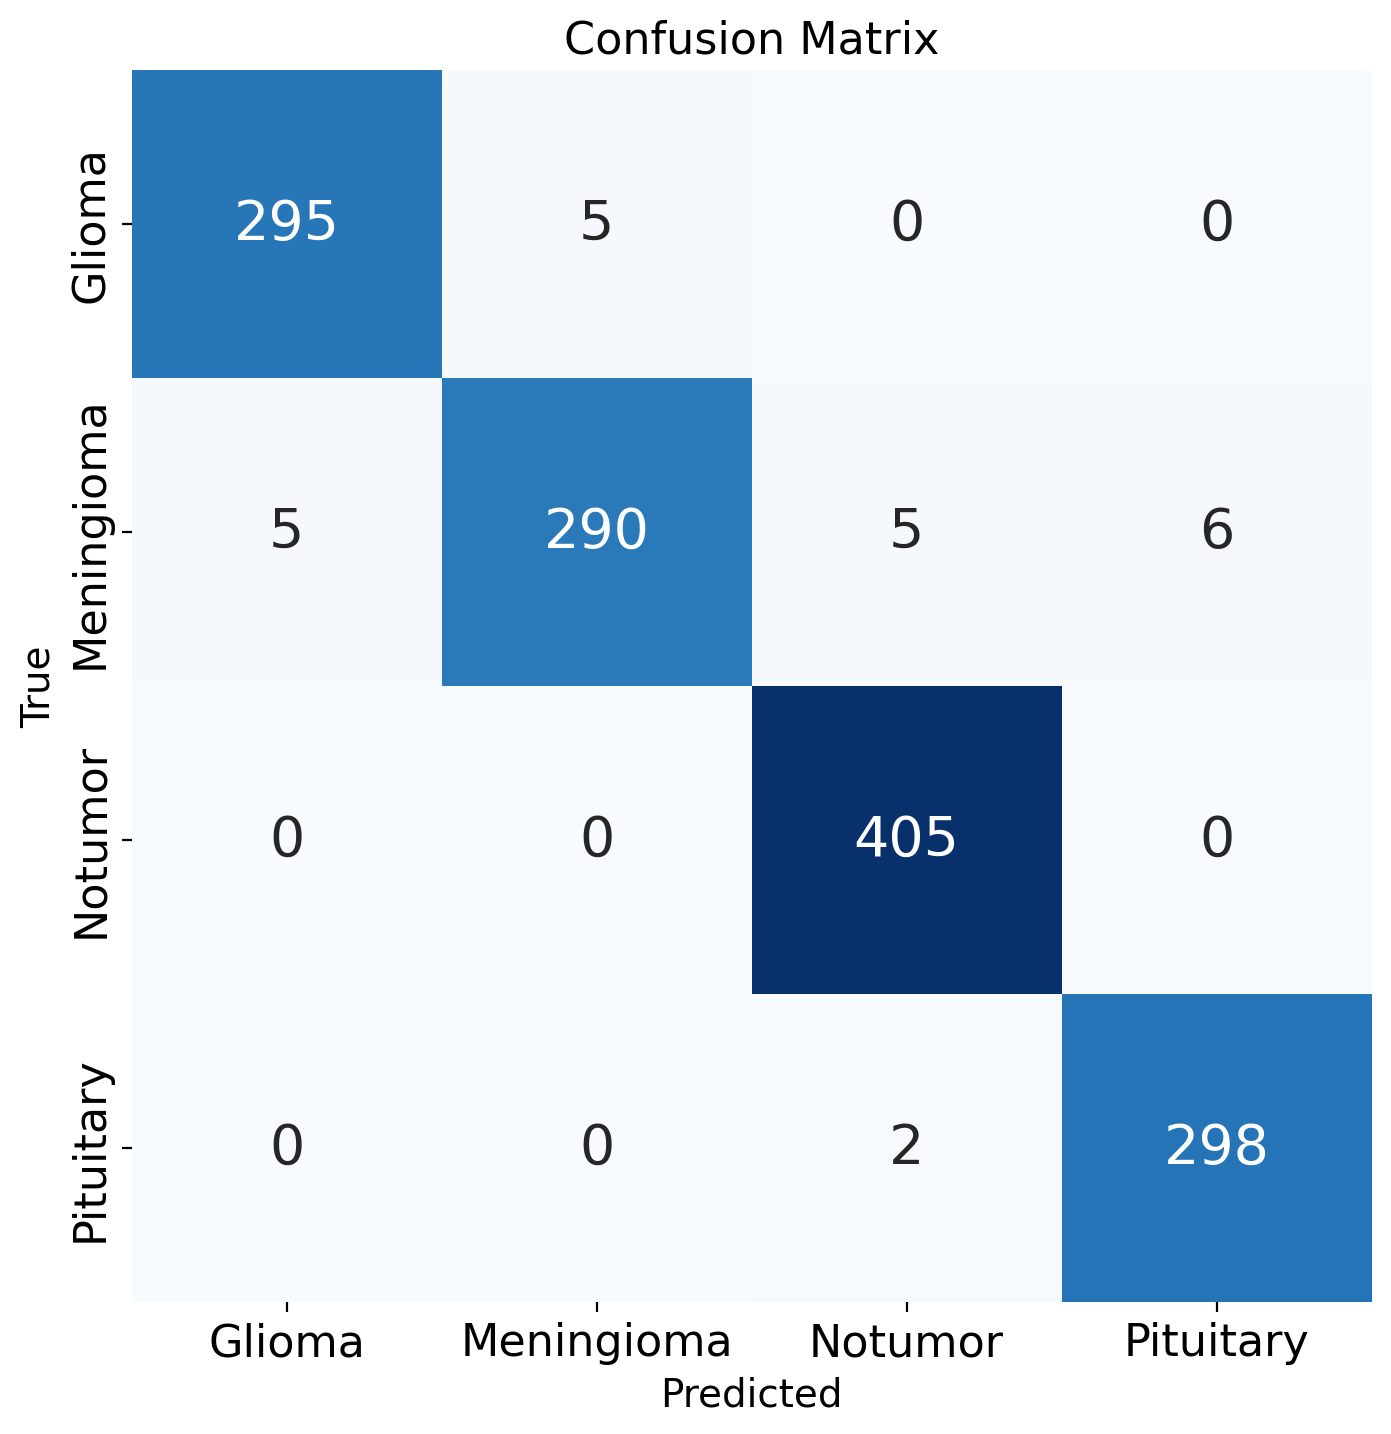

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma   0.983333  0.983333  0.983333       300
  Meningioma   0.983051  0.947712  0.965058       306
     Notumor   0.983010  1.000000  0.991432       405
   Pituitary   0.980263  0.993333  0.986755       300

    accuracy                       0.982456      1311
   macro avg   0.982414  0.981095  0.981645      1311
weighted avg   0.982465  0.982456  0.982353      1311

Model saved in HDF5 format to /kaggle/working/model_256.h5


In [18]:
# Training batch size
batch_size = 256
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)
# Define the model architecture 1
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.35, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
# Display the kernel size for each convolutional layer
for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Layer {layer.name} has kernel size: {layer.kernel_size}")
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)), verbose=1)

# Binarize the true labels
class_names = list(train_generator.class_indices.keys())
y_true_bin = label_binarize(y_true, classes=list(train_generator.class_indices.values()))

_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], color='green', linewidth=2.5, label='Train Accuracy')  # Green
ax[0].plot(history.history['val_accuracy'], color='#8F00FF', linewidth=2.5, label='Validation Accuracy')  # Magenta
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.2)

# Loss Plot
ax[1].plot(history.history['loss'], color='green', linewidth=2.5, label='Train Loss')  # Purple
ax[1].plot(history.history['val_loss'], color='#8F00FF', linewidth=2.5, label='Validation Loss')  # Pink
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_ylim(0, 1)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.2)
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    class_name_title_case = class_name.title()  # Convert to title case
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f'{class_name_title_case} (AUC = {roc_auc:.2f})')  # Increased line width

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})  # Increased font size
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center', fontsize=16)
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center', fontsize=16)
plt.show()

# Classification Report
from sklearn.metrics import classification_report

# Obtain true labels and predicted labels
y_true = test_generator.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels from the model

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[name.title() for name in class_indices_train_list], digits=6))

model_save_path = '/kaggle/working/model_256.h5'
model.save(model_save_path)
print(f"Model saved in HDF5 format to {model_save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


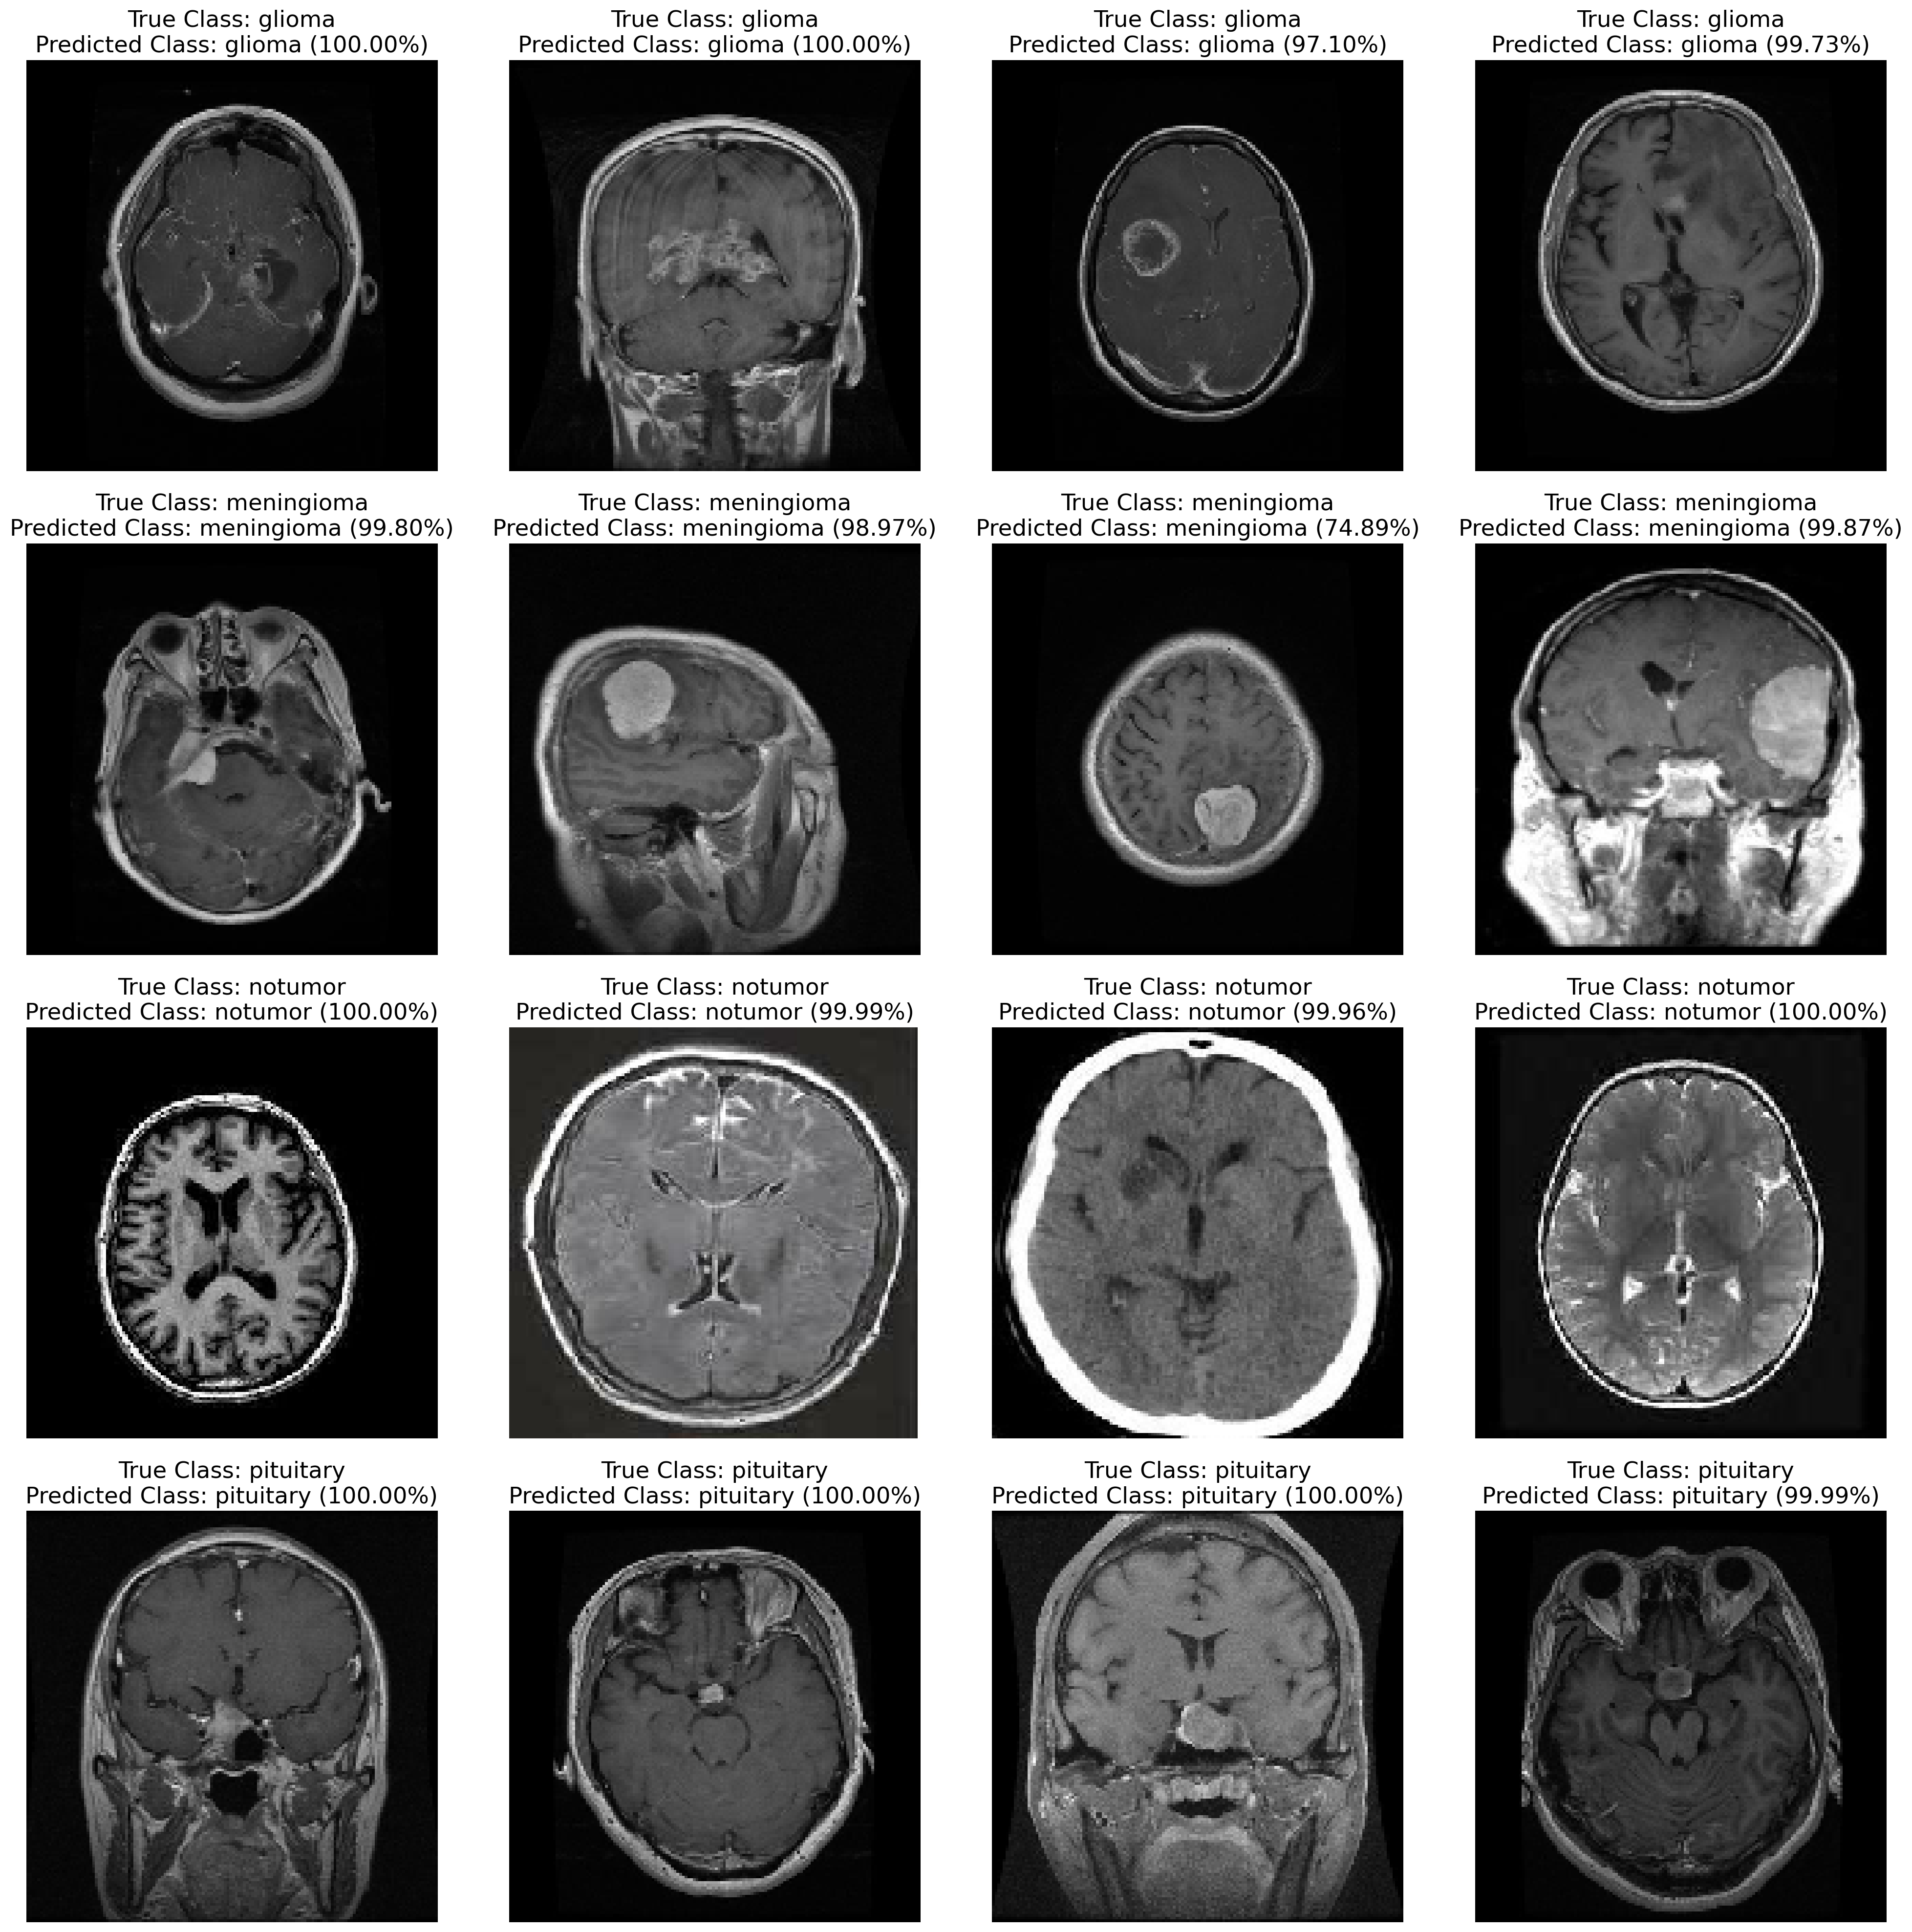

In [19]:
# Function to predict and plot 4 sample images from each class
def predict_and_plot_samples(test_path, class_names, num_samples=4):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(20, len(class_names) * 5))  # Create subplots

    for i, class_name in enumerate(class_names):
        # Get the list of images in the selected subclass
        class_dir = os.path.join(test_path, class_name)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # If there are not enough images, raise an error
        if len(images) < num_samples:
            raise ValueError(f"Not enough images found in directory {class_dir} for class {class_name}")

        # Select random images
        random_images = random.sample(images, num_samples)

        for j, random_image in enumerate(random_images):
            image_path = os.path.join(class_dir, random_image)

            # Load and preprocess the image
            img = load_img(image_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0  # Rescale to [0, 1]
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict the class
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            predicted_class_name = class_names[predicted_class]
            prediction_percentage = np.max(predictions) * 100

            # Get the true class
            true_class_index = test_generator.class_indices[class_name]
            true_class_name = class_names[true_class_index]

            # Display the image and prediction results
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"True Class: {true_class_name}\nPredicted Class: {predicted_class_name} ({prediction_percentage:.2f}%)")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Predict and display results for 4 images from each class
predict_and_plot_samples(test_dir, class_names)

In [20]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define datasets
datasets = {
    "Dataset 1": "/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset",
    "Dataset 2": "/kaggle/input/mri-brain-tumor-cleaned/brain_tumor_cleaned/Training",
    "Dataset 3": "/kaggle/input/code-to-cure/Training",
    "Dataset 4": "/kaggle/input/mri-brain-tumor-classification/MRI/Training",
    "Dataset 5": "/kaggle/input/brain-tumor-mri-dataset-final/Training",
}

# Function to evaluate model on a given dataset
def evaluate_on_dataset(dataset_name, dataset_path, model, image_size=(150, 150), batch_size=32):
    # Load test data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Generate classification report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=6, output_dict=True)
    accuracy = report['accuracy']
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    # Display the classification report
    print(f"\nClassification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=6))

    # Return consolidated results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Macro Average Precision": macro_avg["precision"],
        "Macro Average Recall": macro_avg["recall"],
        "Macro Average F1-Score": macro_avg["f1-score"],
        "Weighted Average Precision": weighted_avg["precision"],
        "Weighted Average Recall": weighted_avg["recall"],
        "Weighted Average F1-Score": weighted_avg["f1-score"],
    }

# Consolidate results for all datasets
results = []
for dataset_name, dataset_path in datasets.items():
    print(f"Evaluating on {dataset_name}...")
    metrics = evaluate_on_dataset(dataset_name, dataset_path, model)
    results.append(metrics)

# Save results to CSV
csv_file = "evaluation_results.csv"
csv_columns = list(results[0].keys())

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

# Display results in tabular format
df = pd.DataFrame(results)
print(df)

# Save 
df.to_csv('df256.csv', index=False)
print("DataFrame saved ")

Evaluating on Dataset 1...
Found 2175 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step

Classification Report for Dataset 1:

              precision    recall  f1-score   support

      glioma   0.989059  0.993407  0.991228       455
  meningioma   0.998145  0.978182  0.988062       550
     notumor   0.983900  1.000000  0.991885       550
   pituitary   0.998387  0.998387  0.998387       620

    accuracy                       0.992644      2175
   macro avg   0.992373  0.992494  0.992391      2175
weighted avg   0.992711  0.992644  0.992634      2175

Evaluating on Dataset 2...
Found 5099 images belonging to 4 classes.
  2/160 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step

Classification Report for Dataset 2:

              precision    recall  f1-score   support

      glioma   0.991679  0.992430  0.992054      1321
  meningioma   0.997649  0.980740  0.989122      1298
     notumor   0.985795  1.000000  0.992847      1041
   pituitary   0.995156  0.999305  0.997226      1439

    accuracy                       0.992940      5099
   macro avg   0.992570  0.993119  0.992812      5099
weighted avg   0.992979  0.992940  0.992929      5099

Evaluating on Dataset 3...
Found 5229 images belonging to 4 classes.
  2/164 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step

Classification Report for Dataset 3:

              precision    recall  f1-score   support

      glioma   0.954762  0.988496  0.971336      1217
  meningioma   0.995571  0.928159  0.960684      1211
     notumor   0.975317  0.999316  0.987171      1463
   pituitary   0.994780  0.997010  0.995894      1338

    accuracy                       0.979728      5229
   macro avg   0.980108  0.978245  0.978771      5229
weighted avg   0.980204  0.979728  0.979583      5229

Evaluating on Dataset 4...
Found 5708 images belonging to 4 classes.
  3/179 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step

Classification Report for Dataset 4:

              precision    recall  f1-score   support

      glioma   0.990930  0.992430  0.991679      1321
  meningioma   0.997719  0.979836  0.988696      1339
     notumor   0.990044  1.000000  0.994997      1591
   pituitary   0.995215  0.999314  0.997260      1457

    accuracy                       0.993343      5708
   macro avg   0.993477  0.992895  0.993158      5708
weighted avg   0.993369  0.993343  0.993329      5708

Evaluating on Dataset 5...
Found 5712 images belonging to 4 classes.
  3/179 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step

Classification Report for Dataset 5:

                  precision    recall  f1-score   support

    glioma_tumor   0.990930  0.992430  0.991679      1321
meningioma_tumor   0.997719  0.979836  0.988696      1339
        no_tumor   0.990068  1.000000  0.995009      1595
 pituitary_tumor   0.995215  0.999314  0.997260      1457

        accuracy                       0.993347      5712
       macro avg   0.993483  0.992895  0.993161      5712
    weighted avg   0.993374  0.993347  0.993333      5712

     Dataset  Accuracy  Macro Average Precision  Macro Average Recall  \
0  Dataset 1  0.992644                 0.992373              0.992494   
1  Dataset 2  0.992940                 0.992570              0.993119   
2  Dataset 3  0.979728                 0.980108              0.978245   
3  Dataset 4  0.993343                 0.993477              0.992895   
4  Dataset 5  0.993347                 0.993483              0.992895   

   Macro Ave